## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleeean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

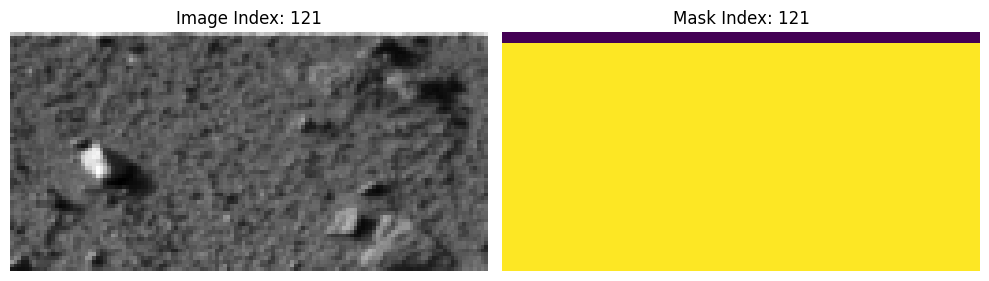

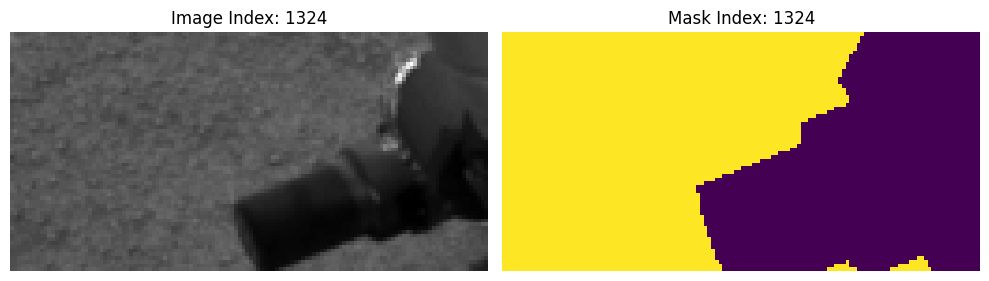

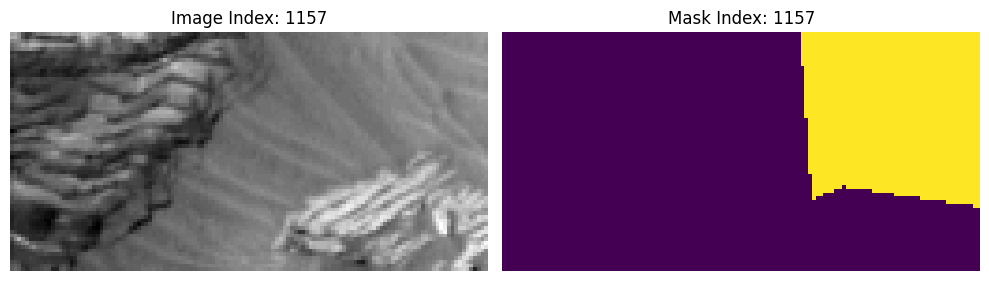

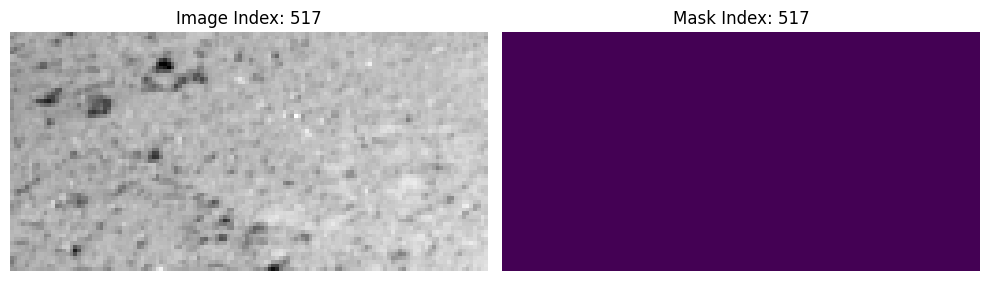

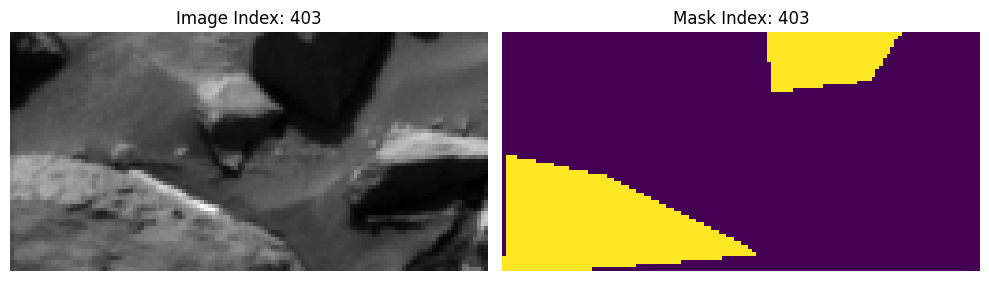

In [3]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

## invert image and noise

/tmp/ipykernel_23/2853586488.py:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(images), 6, i * 6 + 3)


20.0
20.0
35.0
35.0
57.0
57.0
43.0
43.0
16.0
16.0


/tmp/ipykernel_23/2853586488.py:80: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


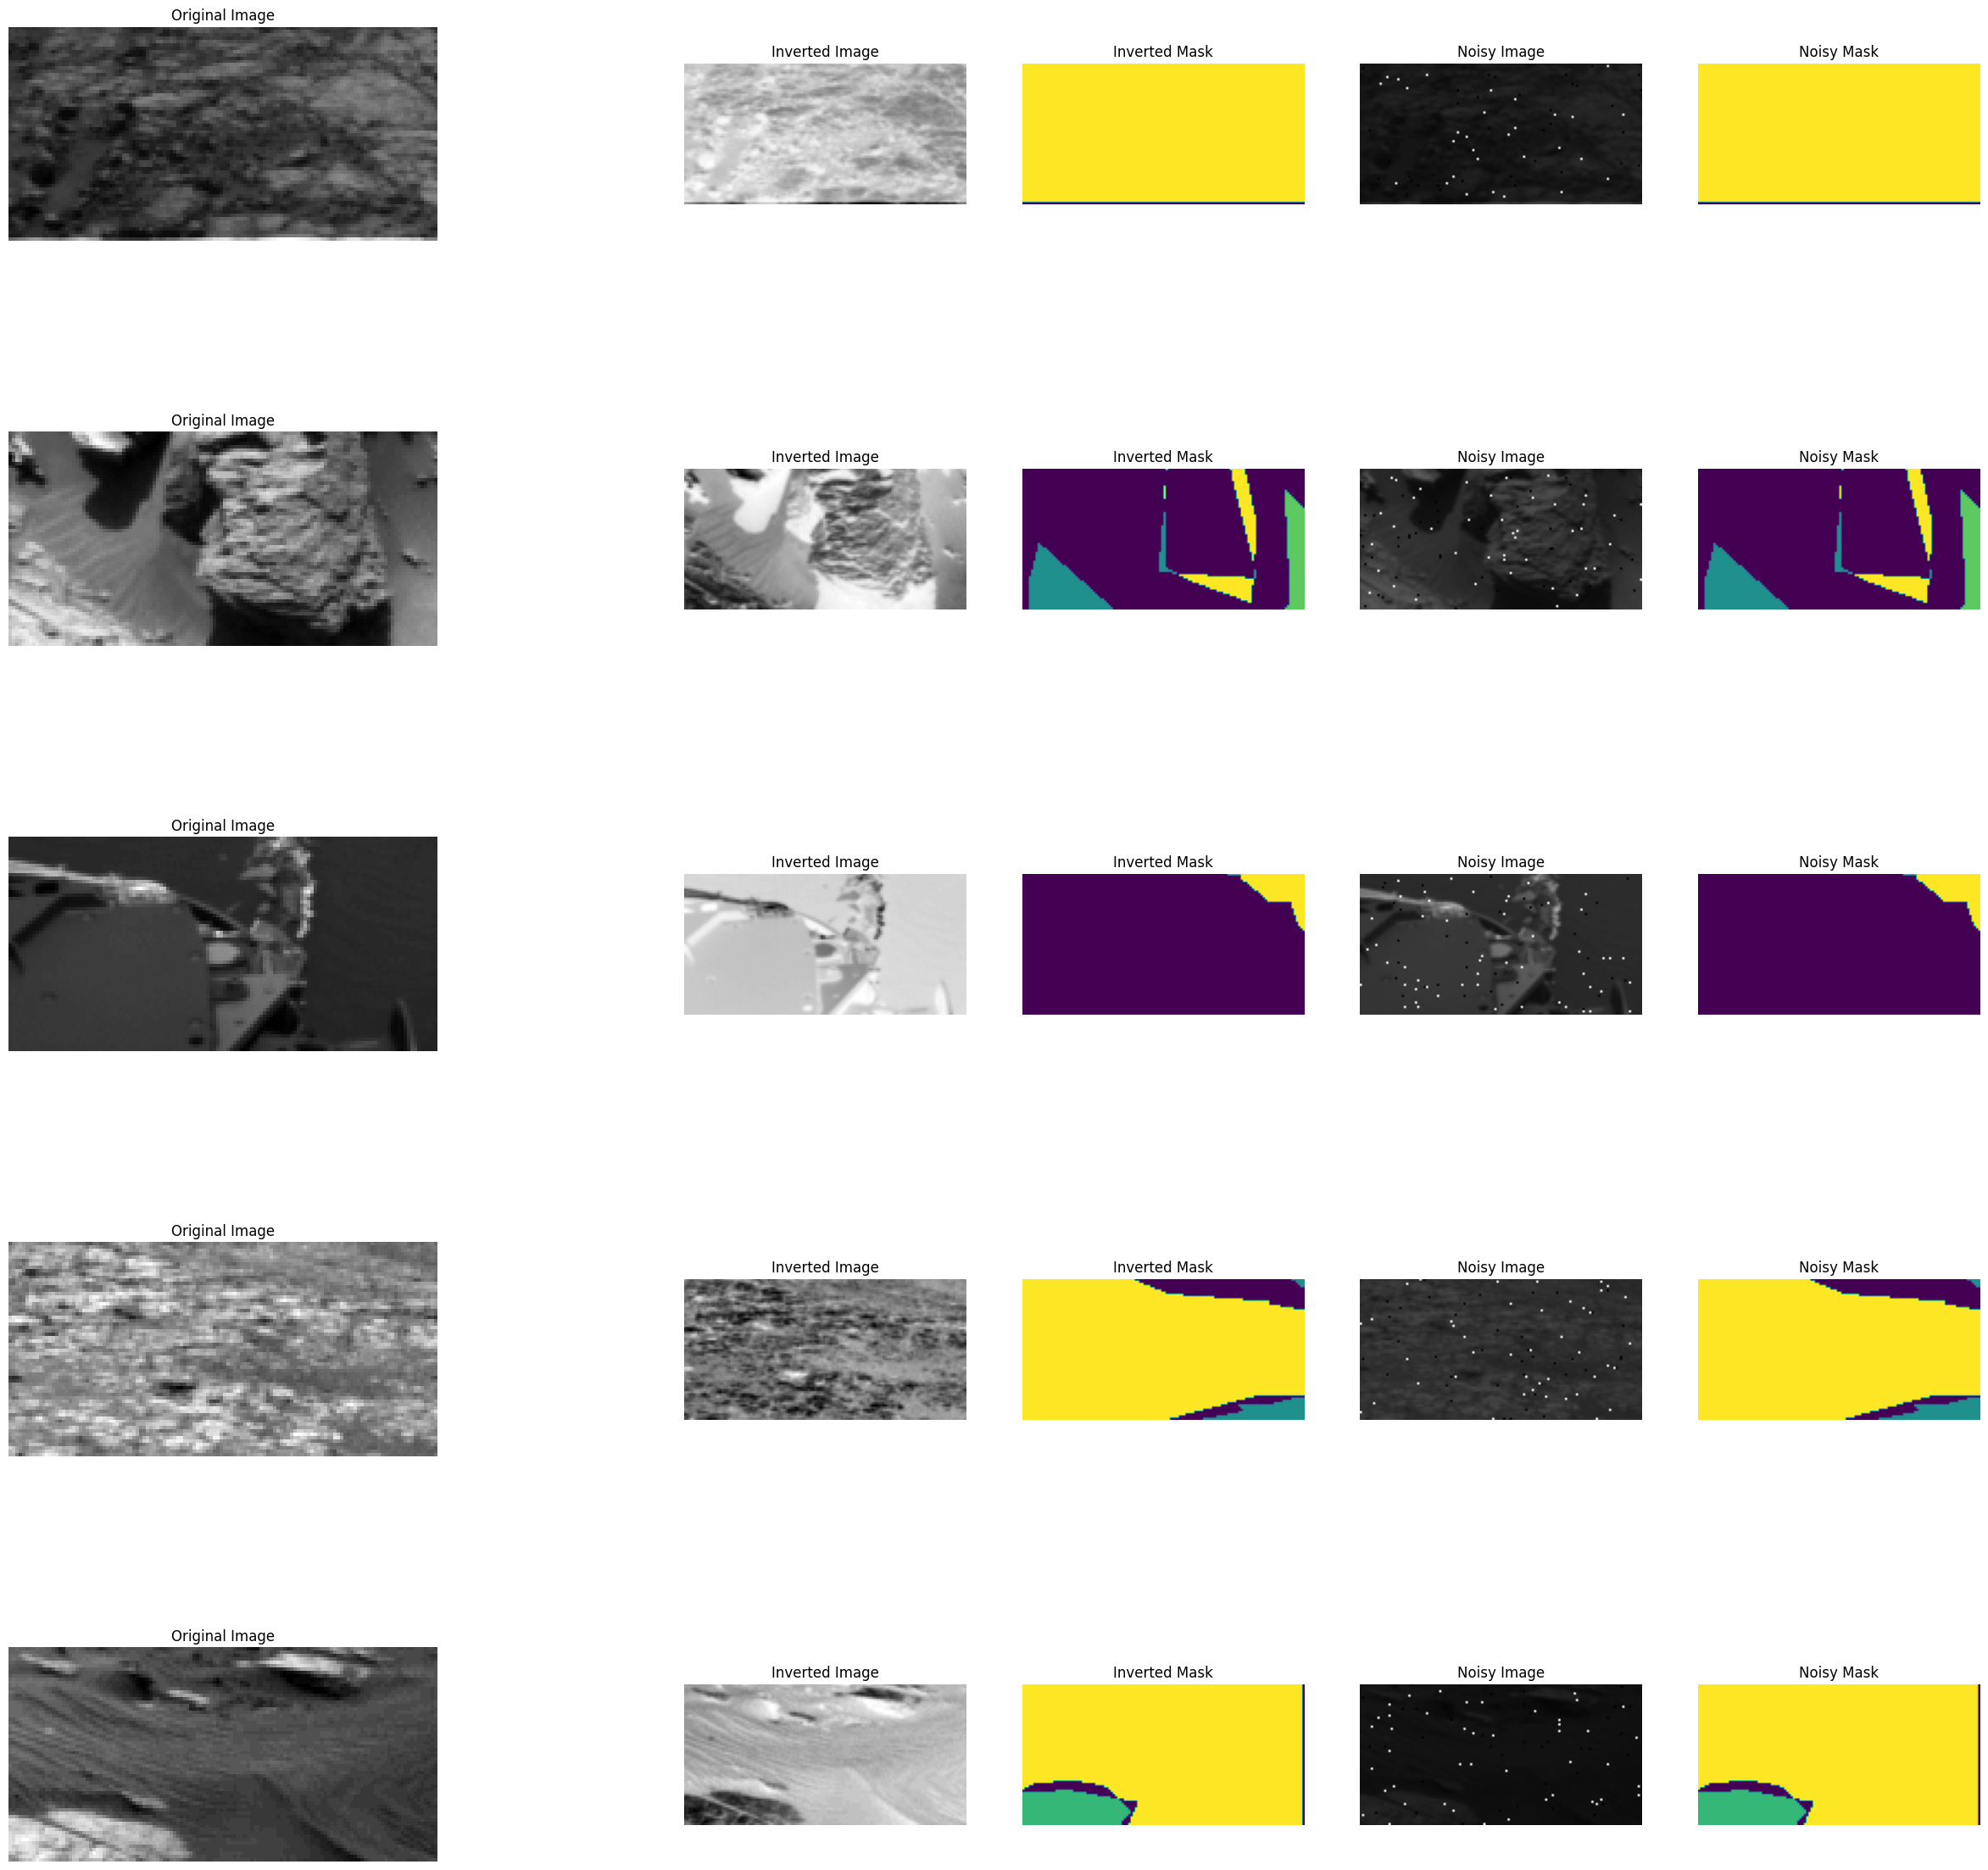

In [4]:


import numpy as np
from skimage.util import random_noise

# Define augmentation functions with mask handling
def invert_image(image, mask):
    return 255 - image, mask  # Mask remains unchanged

def add_salt_and_pepper_noise(image, mask, amount=0.01):
    """
    Add salt-and-pepper noise to an image, preserving its grayscale range.

    Args:
        image (np.ndarray): Input grayscale image with range [0, 255].
        mask (np.ndarray): Corresponding mask (unchanged).
        amount (float): Proportion of image pixels to replace with noise.

    Returns:
        noisy_image (np.ndarray): Image with salt-and-pepper noise applied.
        mask (np.ndarray): Unchanged mask.
    """
    # Normalize the image to [0, 1]
    print(image[39][55])
    normalized_image = image / 255.0
    # Add salt-and-pepper noise
    noisy_image = random_noise(normalized_image, mode='s&p', amount=amount)
    # Scale back to [0, 255]
    noisy_image = (noisy_image * 255)
    print(image[39][55])
    return noisy_image, mask


"""def rotate_image(image, mask, angle):
    rotated_image = rotate(image, angle, reshape=False, mode='constant', cval=0)
    rotated_mask = rotate(mask, angle, reshape=False, mode='constant', order=0)
    return rotated_image, rotated_mask"""
"""
def adjust_brightness(image, mask, factor=1.2):
    brightened_image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return brightened_image, mask  # Mask remains unchanged"""

# Visualize augmentations with masks
def visualize_all_augmentations(images, masks):
    plt.figure(figsize=(30, 30))
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Original image and mask
        plt.subplot(len(images), 4, i * 4 + 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 2)
        plt.imshow(mask, cmap="viridis")
        plt.title("Original Mask")
        plt.axis("off")

        # Inversion
        inverted_image, inverted_mask = invert_image(image, mask)
        plt.subplot(len(images), 6, i * 6 + 3)
        plt.imshow(inverted_image, cmap="gray")
        plt.title("Inverted Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 4)
        plt.imshow(inverted_mask, cmap="viridis")
        plt.title("Inverted Mask")
        plt.axis("off")

        # Noise
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        plt.subplot(len(images), 6, i * 6 + 5)
        plt.imshow(noisy_image, cmap="gray")
        plt.title("Noisy Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 6)
        plt.imshow(noisy_mask, cmap="viridis")
        plt.title("Noisy Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
sample_images = X_train[random_indices]
sample_masks = y_train[random_indices]

# Visualize augmentations
visualize_all_augmentations(sample_images, sample_masks)


### rotation

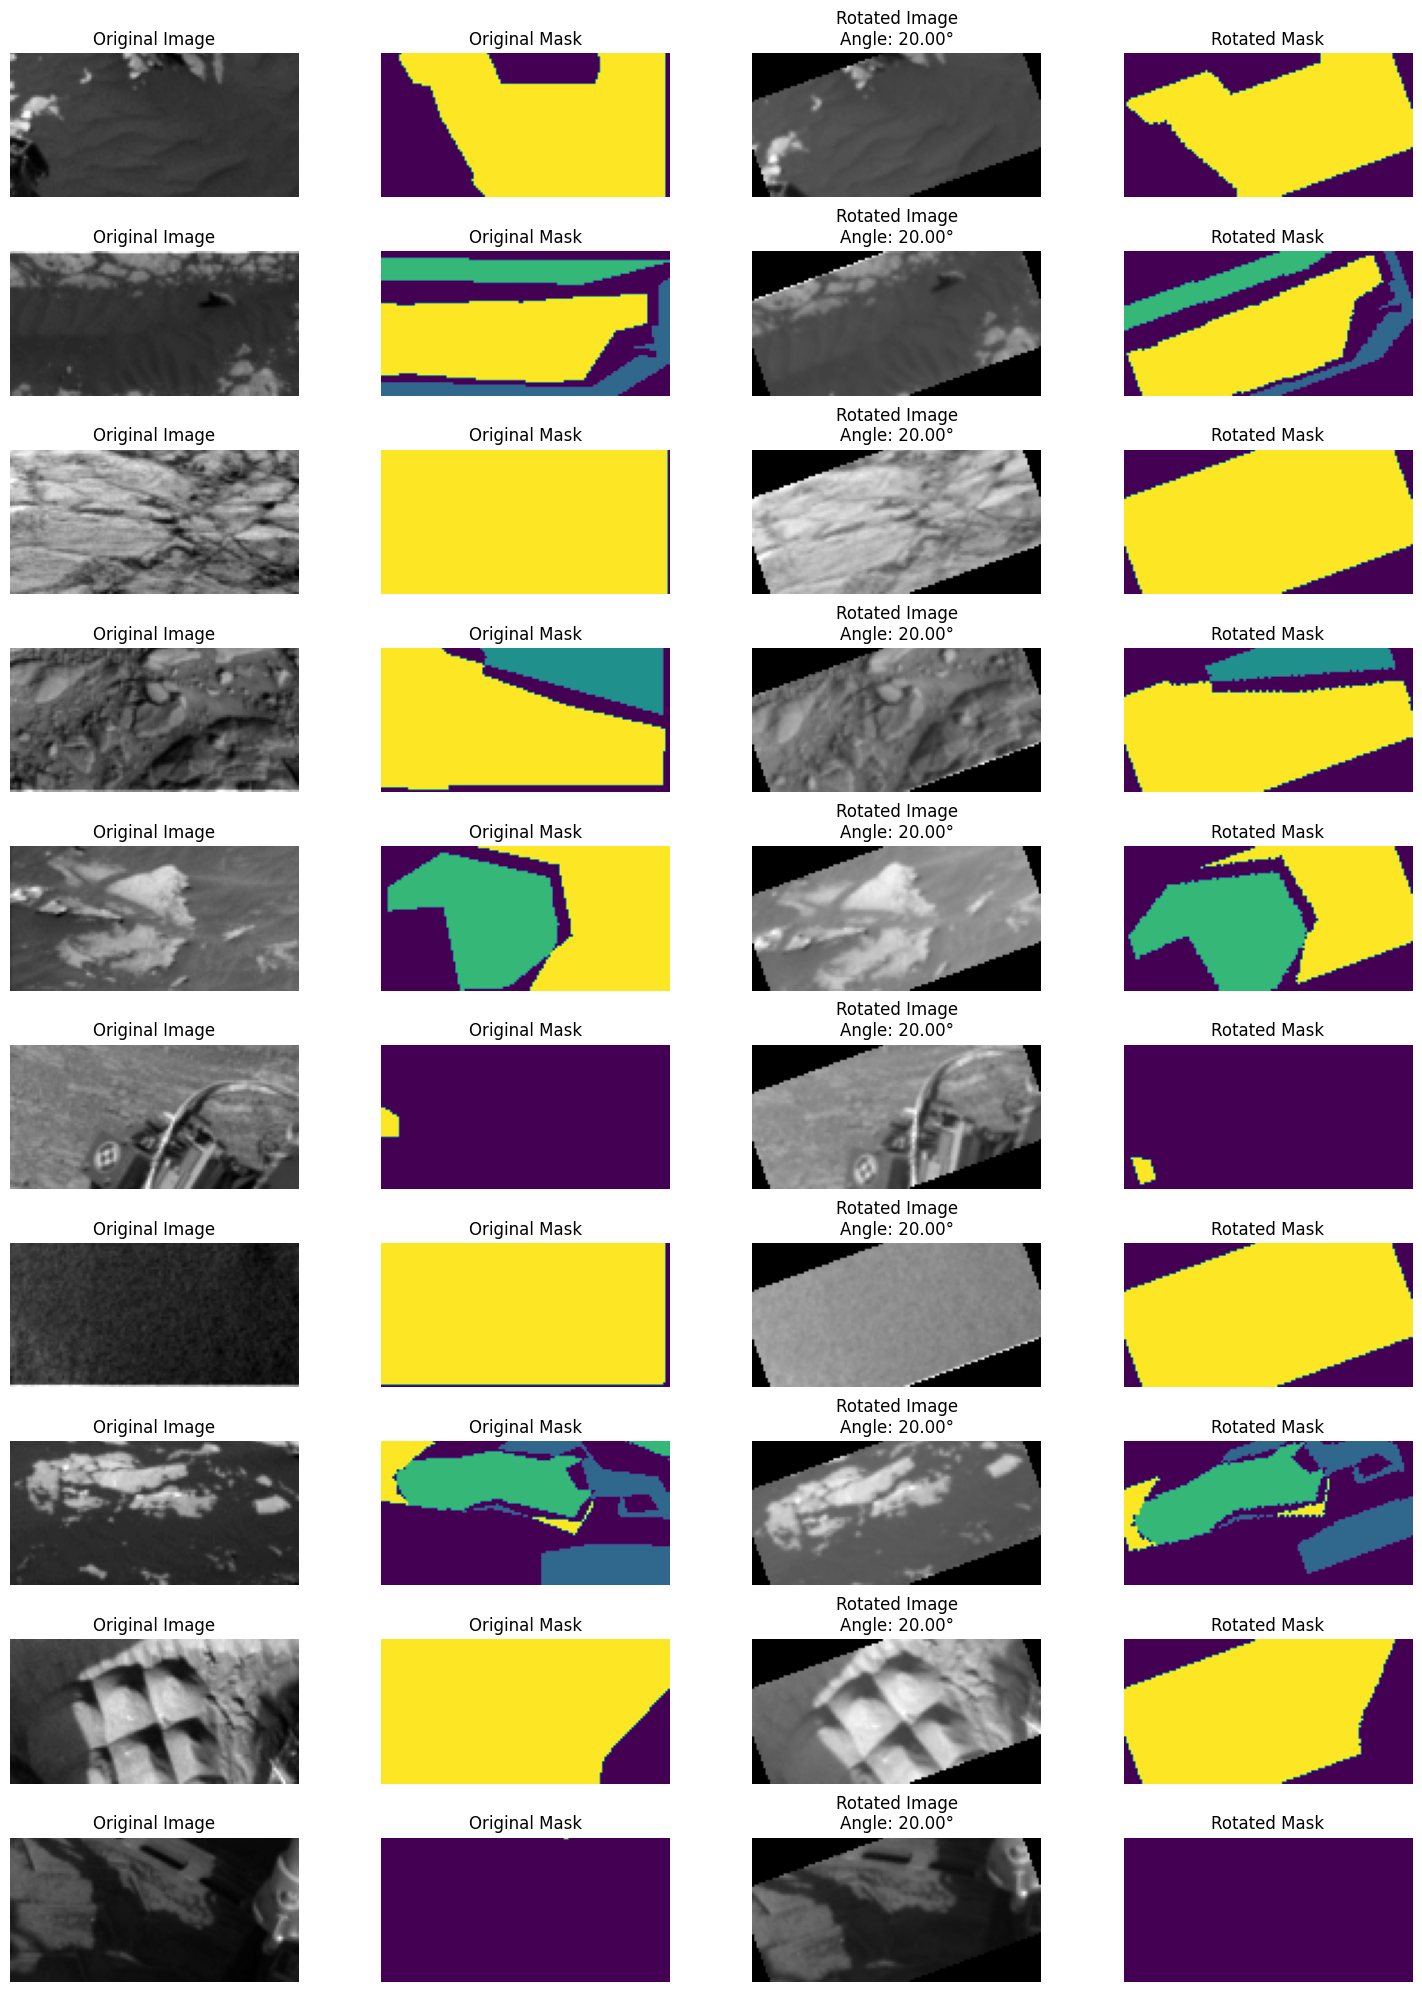

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


49.0
49.0
60.0
60.0
71.0
71.0
40.0
40.0
45.0
45.0


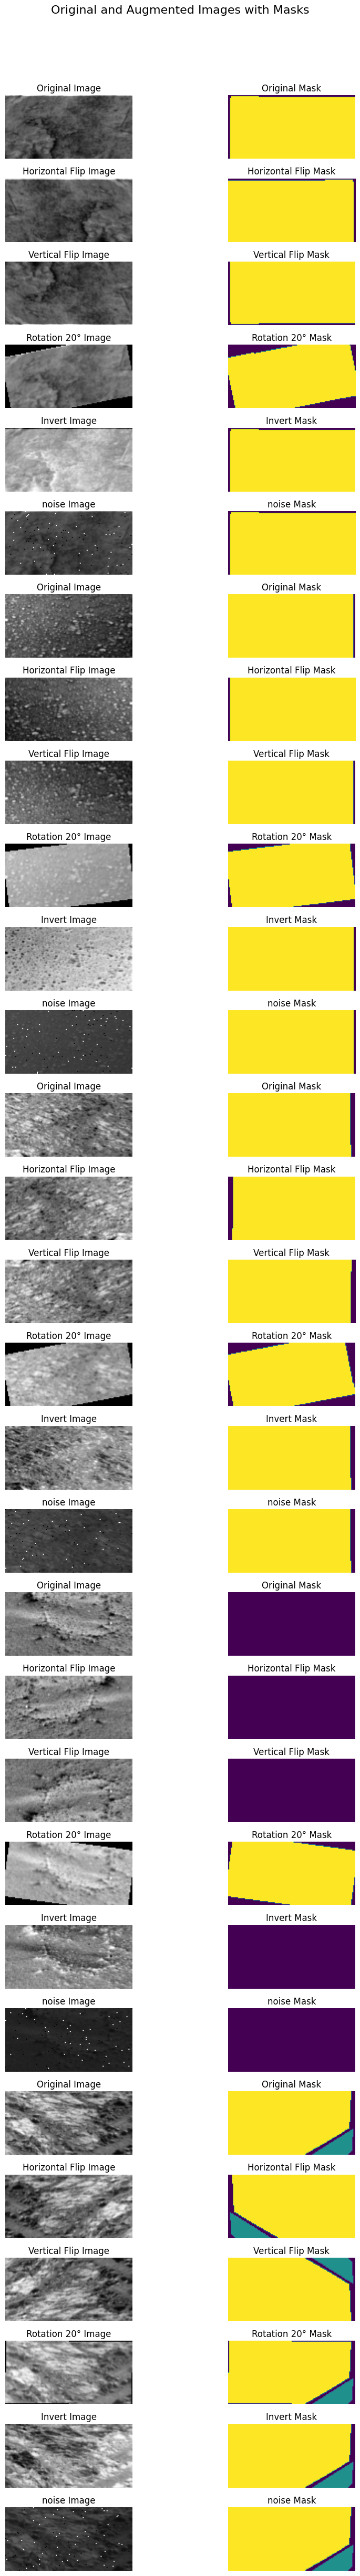

In [6]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type=="Invert":
        inverted_image, inverted_mask = invert_image(image, mask)
        return inverted_image,inverted_mask
    elif augment_type=="noise":
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        return noisy_image,noisy_mask
        
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    "Invert":"Invert",
    "noise":"noise"
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [7]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


97.0
97.0
33.0
33.0
108.0
108.0
79.0
79.0
99.0
99.0
91.0
91.0
64.0
64.0
61.0
61.0
19.0
19.0
104.0
104.0
63.0
63.0
35.0
35.0
83.0
83.0
31.0
31.0
77.0
77.0
33.0
33.0
42.0
42.0
45.0
45.0
10.0
10.0
108.0
108.0
25.0
25.0
85.0
85.0
79.0
79.0
41.0
41.0
39.0
39.0
47.0
47.0
67.0
67.0
72.0
72.0
21.0
21.0
98.0
98.0
54.0
54.0
43.0
43.0
81.0
81.0
14.0
14.0
60.0
60.0
54.0
54.0
79.0
79.0
59.0
59.0
110.0
110.0
84.0
84.0
89.0
89.0
40.0
40.0
21.0
21.0
64.0
64.0
89.0
89.0
48.0
48.0
35.0
35.0
20.0
20.0
58.0
58.0
74.0
74.0
54.0
54.0
113.0
113.0
63.0
63.0
78.0
78.0
66.0
66.0
75.0
75.0
86.0
86.0
54.0
54.0
86.0
86.0
37.0
37.0
28.0
28.0
91.0
91.0
76.0
76.0
48.0
48.0
24.0
24.0
82.0
82.0
61.0
61.0
103.0
103.0
86.0
86.0
83.0
83.0
83.0
83.0
117.0
117.0
42.0
42.0
81.0
81.0
26.0
26.0
77.0
77.0
59.0
59.0
32.0
32.0
15.0
15.0
40.0
40.0
17.0
17.0
59.0
59.0
15.0
15.0
64.0
64.0
22.0
22.0
63.0
63.0
73.0
73.0
92.0
92.0
12.0
12.0
47.0
47.0
86.0
86.0
73.0
73.0
54.0
54.0
96.0
96.0
25.0
25.0
55.0
55.0
49.0
49.0
36.0
36.0
9.0
9.

File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


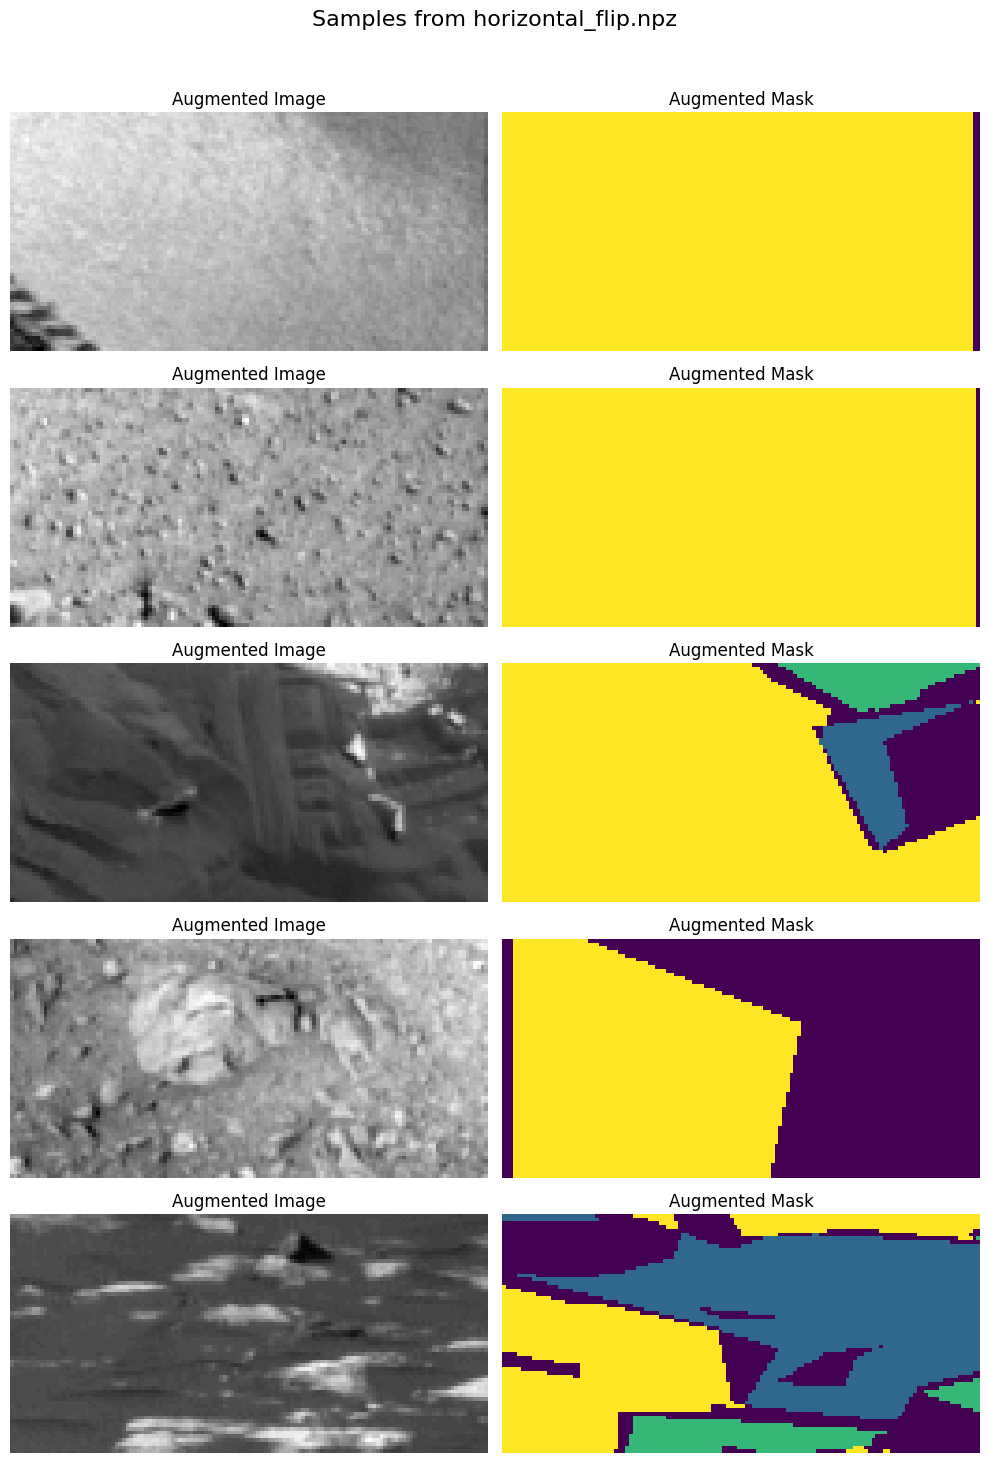

File: noise.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


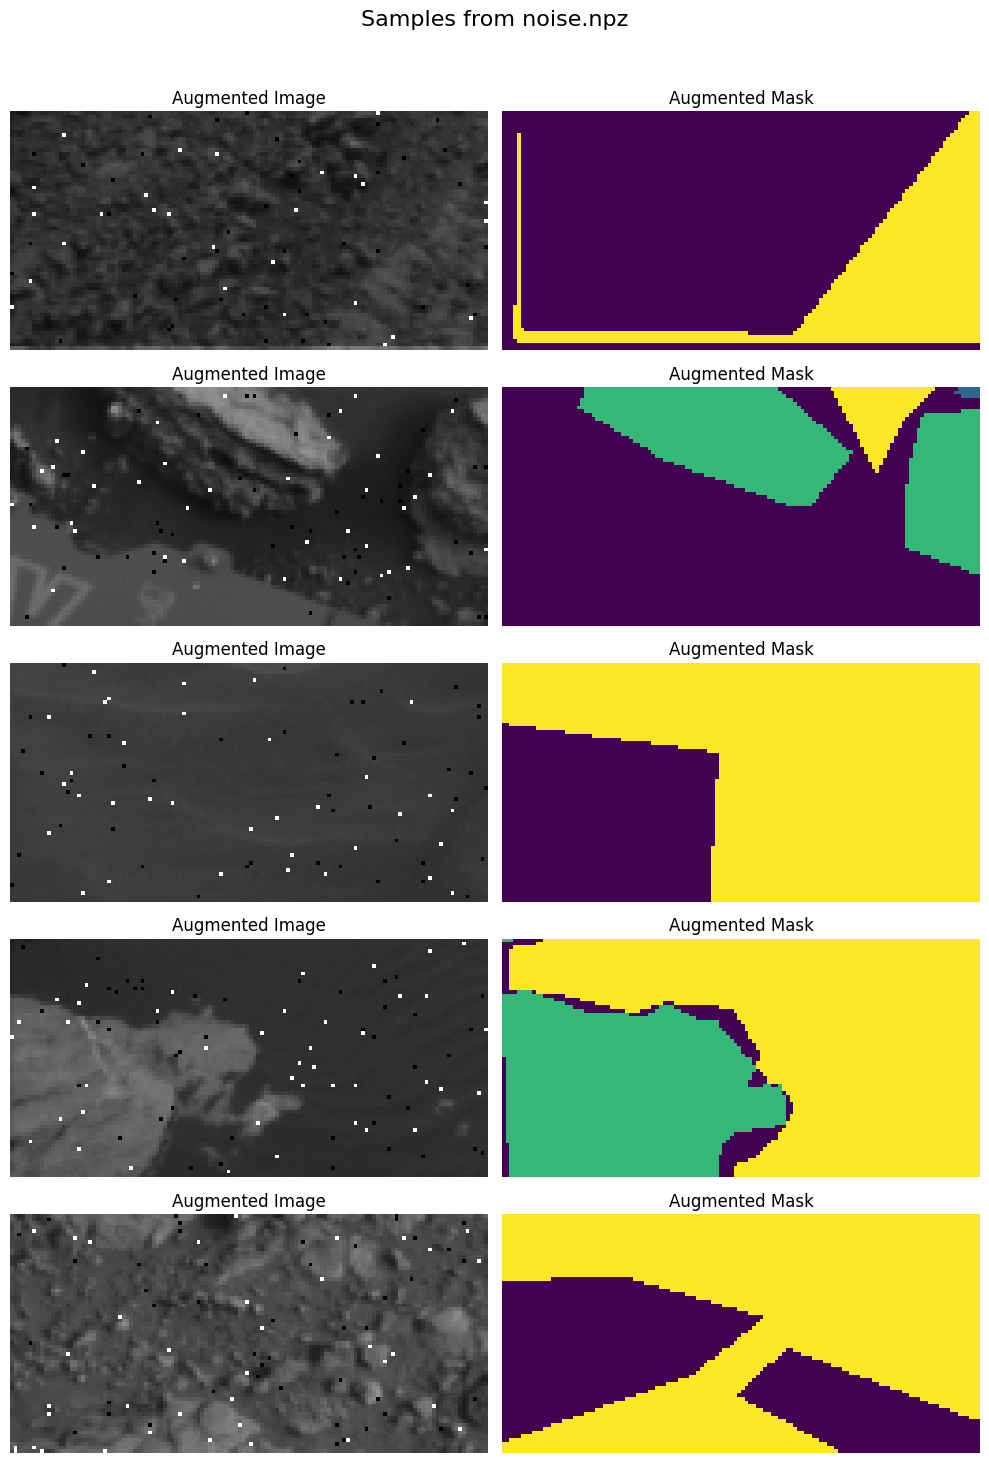

File: invert.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


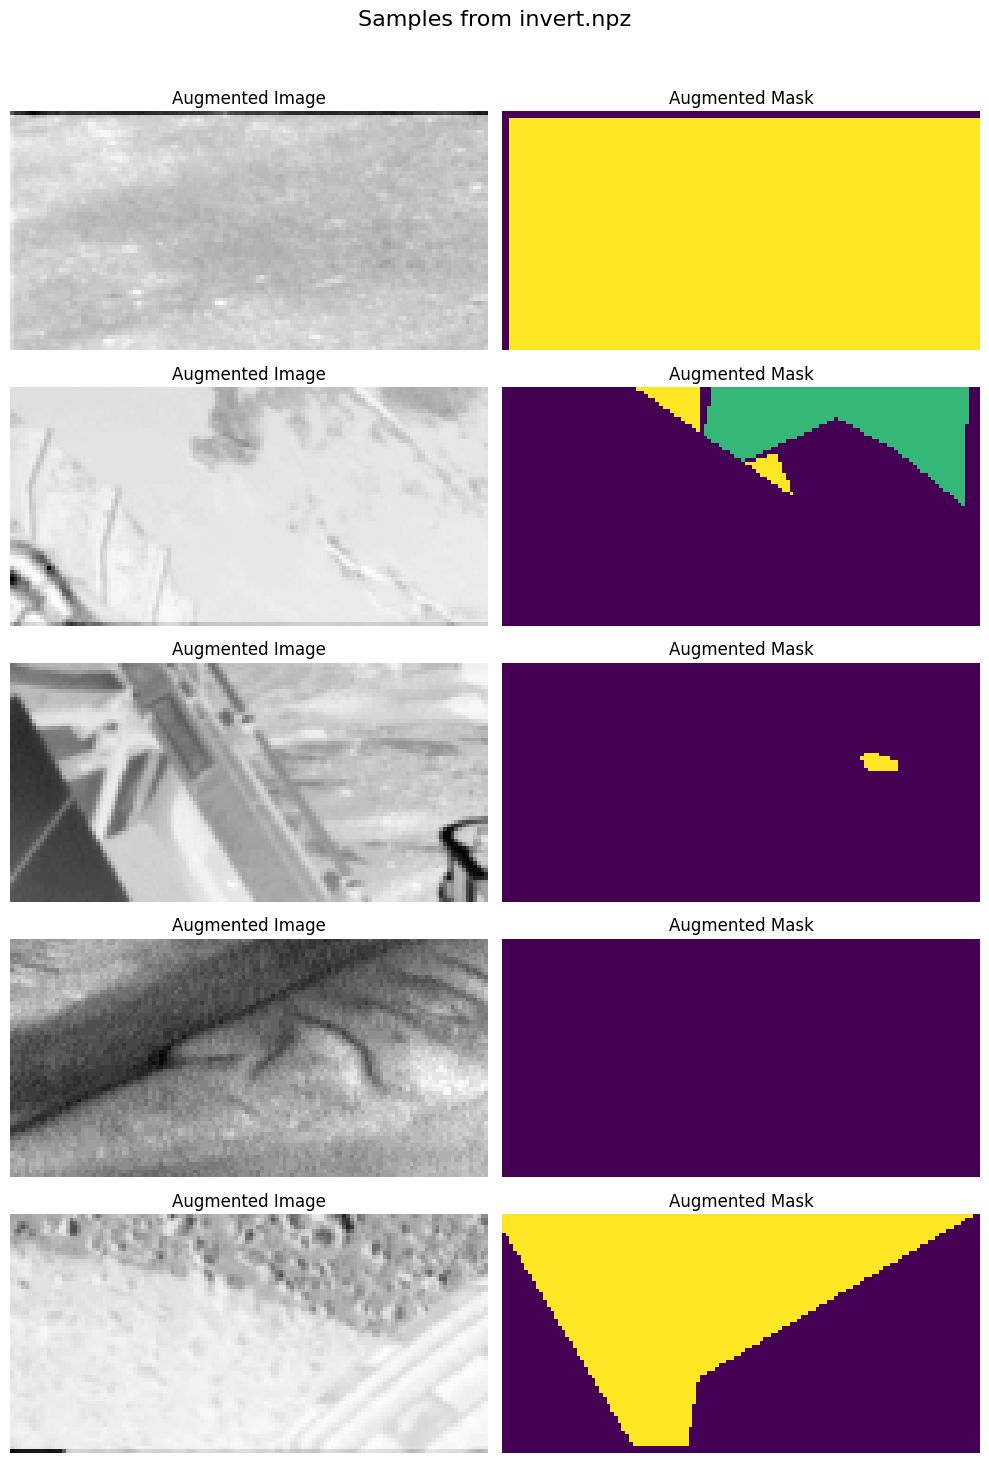

File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


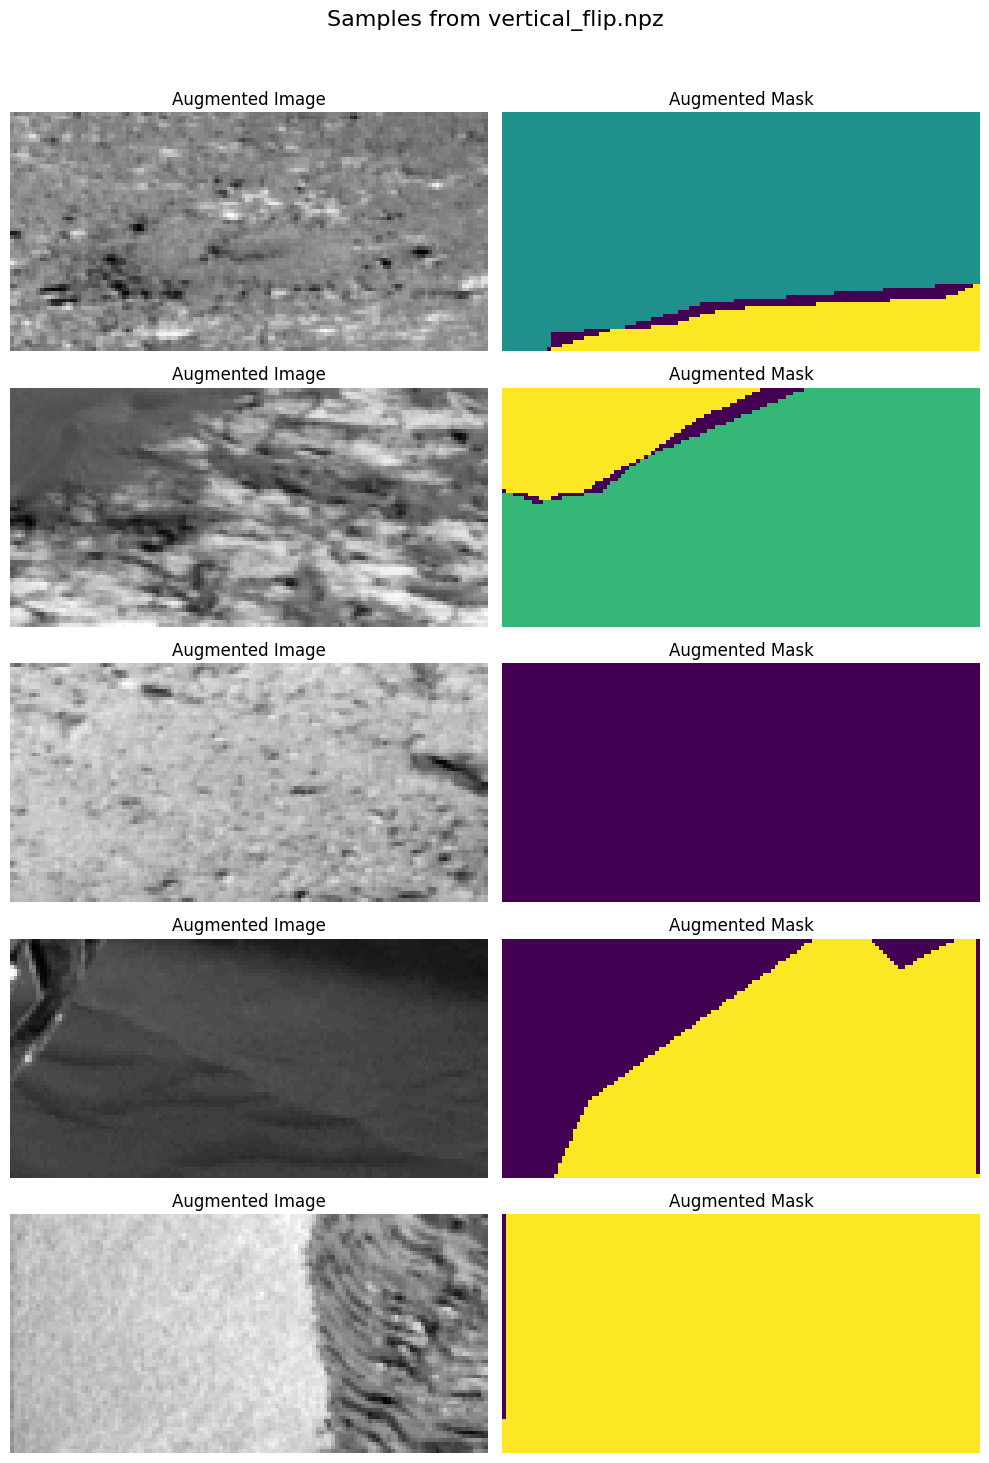

File: rotation_20°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


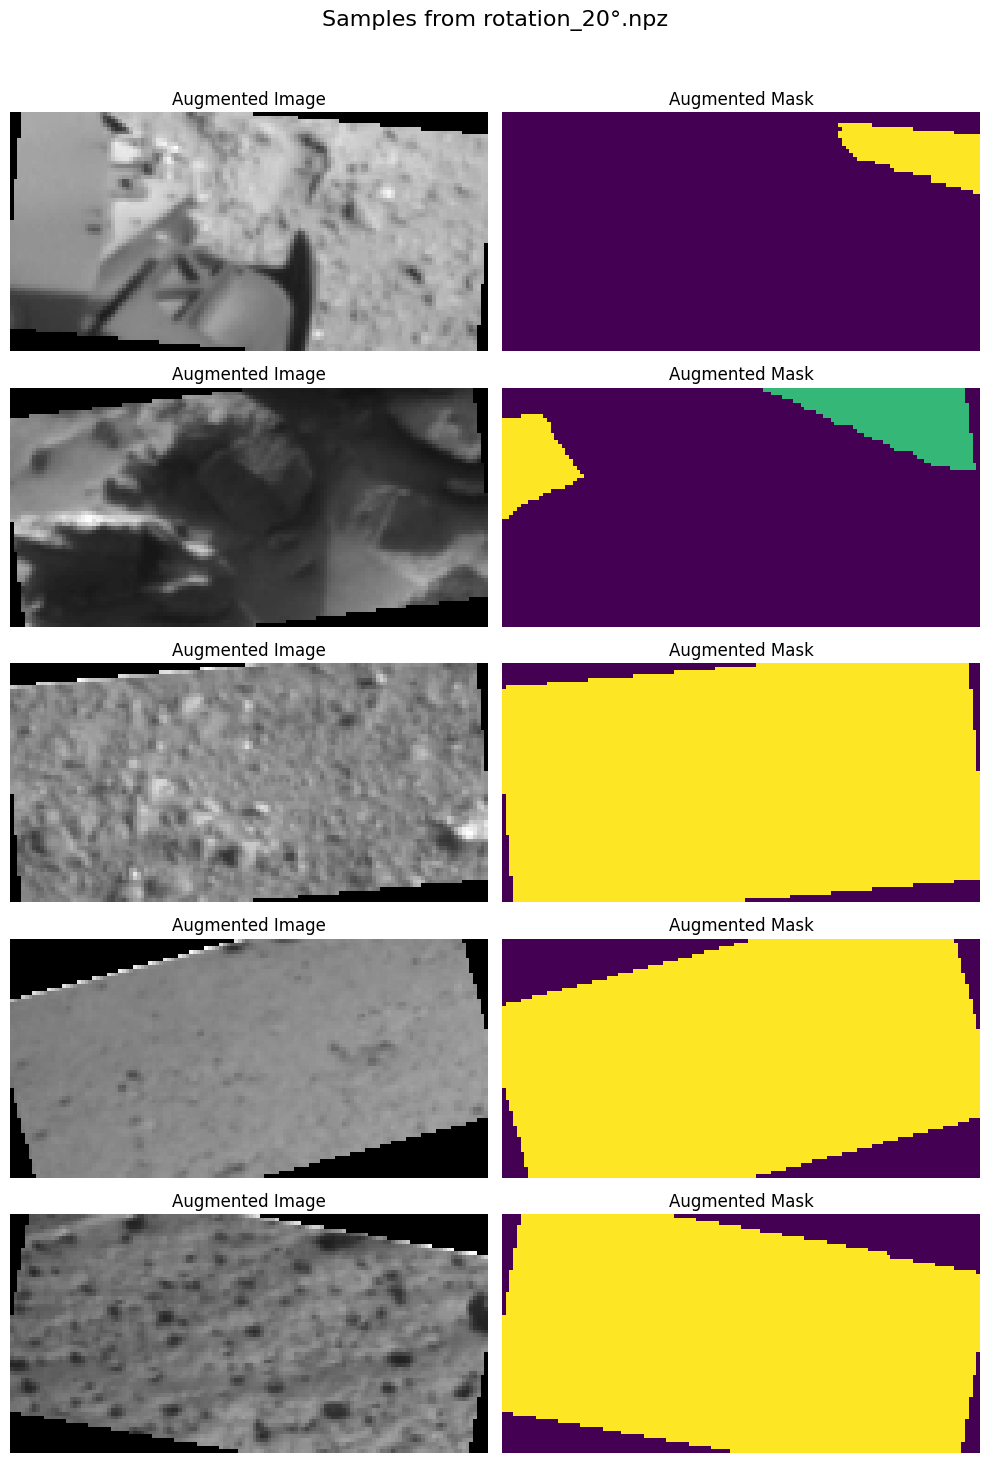

In [8]:
# Read the saved files and display details
output_dir="/kaggle/working/augmented_data"
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

## 🛠️ Train and Save the Model

In [9]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [10]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [11]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)


In [12]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/invert.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (10020, 64, 128)
New y_train shape: (10020, 64, 128)


In [13]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/noise.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (12024, 64, 128)
New y_train shape: (12024, 64, 128)


In [14]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [15]:
X_val = X_val[..., np.newaxis] / 255.0

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (12024, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (12024, 64, 128)


In [17]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [18]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128, 1)


In [19]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Data Augmentation for Images and Masks
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

# Masks should only be flipped or translated without interpolation
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Ensure y_train has the correct shape for augmentation
y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension to masks

# Fit augmentations to the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Create the generators
image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

train_generator = zip(image_generator, mask_generator)

# Weighted Loss Function for Class Imbalance
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Remove the extra dimension from y_true using tf.squeeze
        y_true = tf.squeeze(y_true, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)

    return loss

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (12024, 64, 128, 1)
Shape of y_train after reshaping: (12024, 64, 128)
Class pixel counts: [25103192 32634216 23167641 17469862   125697]
Calculated class weights: [0.00490192 0.0037707  0.00531145 0.00704378 0.97897214]


In [21]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [22]:
from tensorflow.keras.callbacks import Callback
class SaveBestMeanIoU(Callback):
    def __init__(self, filepath, monitor="val_mean_io_u", mode="max", verbose=1):
        super(SaveBestMeanIoU, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Debug: Print available keys in logs
        print(f"Available log keys: {logs.keys()}")
        
        # Use the correct log key
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print(f"Warning: Monitor '{self.monitor}' is not available in logs.")
            return

        if (self.mode == "max" and current > self.best) or (self.mode == "min" and current < self.best):
            self.best = current
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current:.4f}, saving model.")
            self.model.save(self.filepath)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64,    │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 32,    │     33,024 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 32,    │          0 │ conv2d_7[0][0],   │
│                     │ 256)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 16,     │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_2[

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


I0000 00:00:1733341113.612742      93 service.cc:145] XLA service 0x78882c0294f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733341113.612805      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733341113.612809      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733341116.675854      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733341144.652689      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.3486 - loss: 1.3977 - mean_io_u: 0.0831 - mean_iou: 0.0831

W0000 00:00:1733341209.568353      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3487 - loss: 1.3976 - mean_io_u: 0.0831 - mean_iou: 0.0831

W0000 00:00:1733341242.224244      95 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733341246.047145      95 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 1: val_mean_iou improved to 0.0896, saving model.

Epoch 1: val_loss improved from inf to 1.31035, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


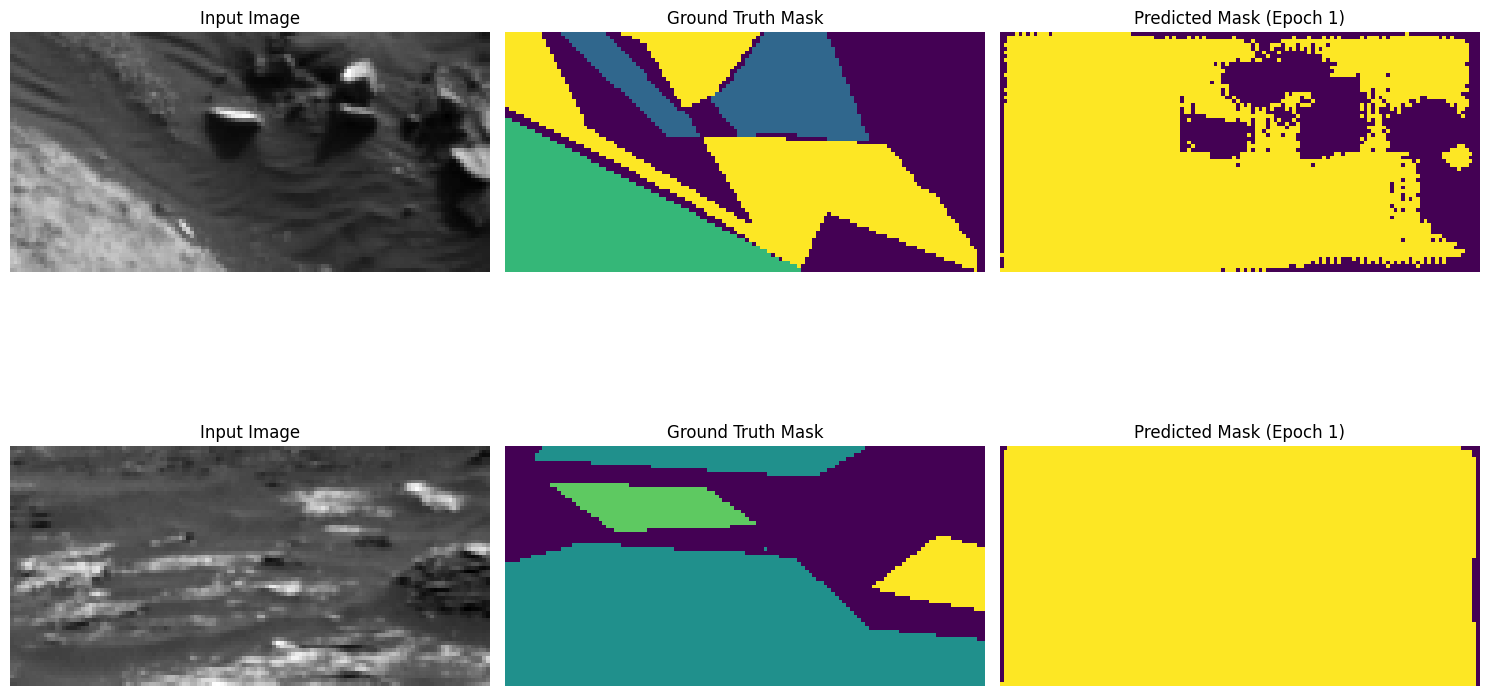

376/376 ━━━━━━━━━━━━━━━━━━━━ 151s 304ms/step - accuracy: 0.3487 - loss: 1.3975 - mean_io_u: 0.0831 - mean_iou: 0.0831 - val_accuracy: 0.3745 - val_loss: 1.3103 - val_mean_io_u: 0.0896 - val_mean_iou: 0.0896 - learning_rate: 1.0000e-04
Epoch 2/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.4253 - loss: 1.2311 - mean_io_u: 0.1699 - mean_iou: 0.1699Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 2: val_mean_iou improved to 0.2910, saving model.

Epoch 2: val_loss improved from 1.31035 to 1.02332, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


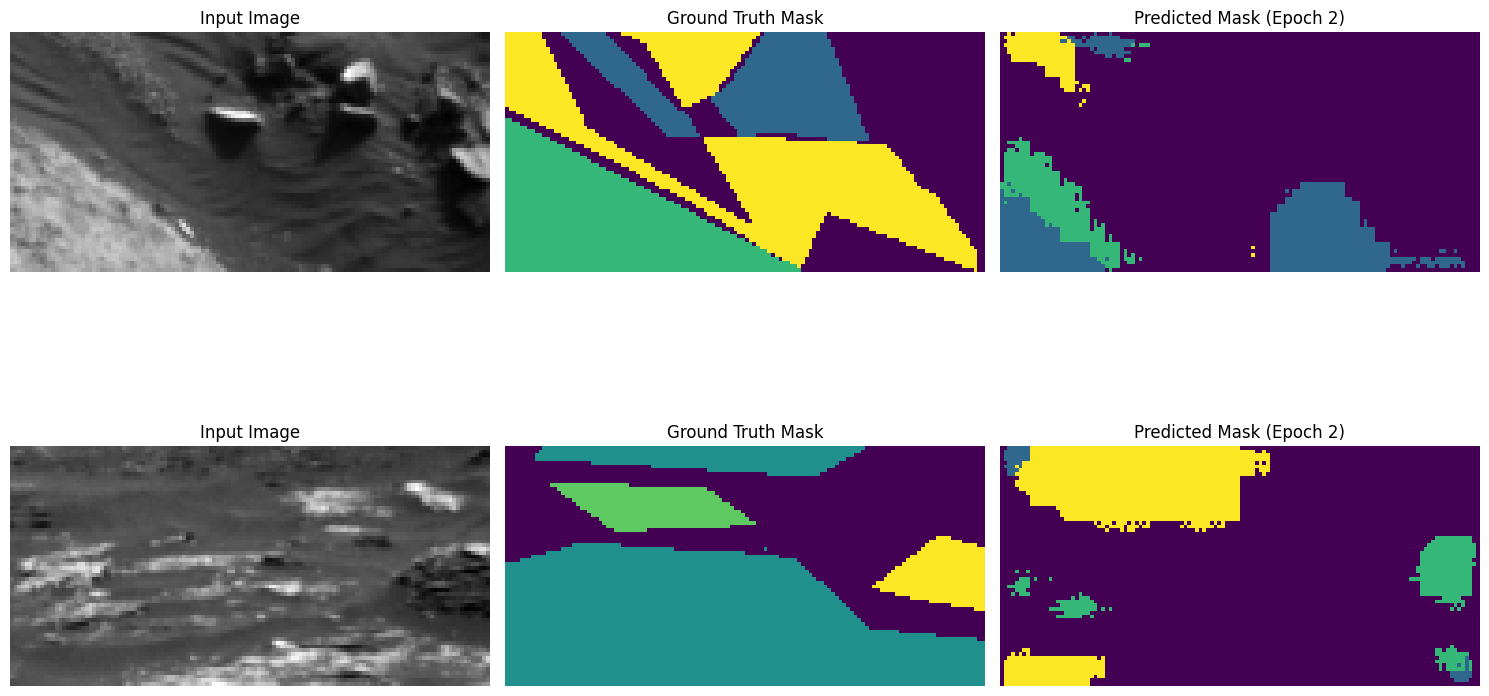

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.4254 - loss: 1.2309 - mean_io_u: 0.1699 - mean_iou: 0.1699 - val_accuracy: 0.5869 - val_loss: 1.0233 - val_mean_io_u: 0.2910 - val_mean_iou: 0.2910 - learning_rate: 1.0000e-04
Epoch 3/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5386 - loss: 1.0557 - mean_io_u: 0.2567 - mean_iou: 0.2567Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 3: val_mean_iou improved to 0.3448, saving model.

Epoch 3: val_loss improved from 1.02332 to 0.92100, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


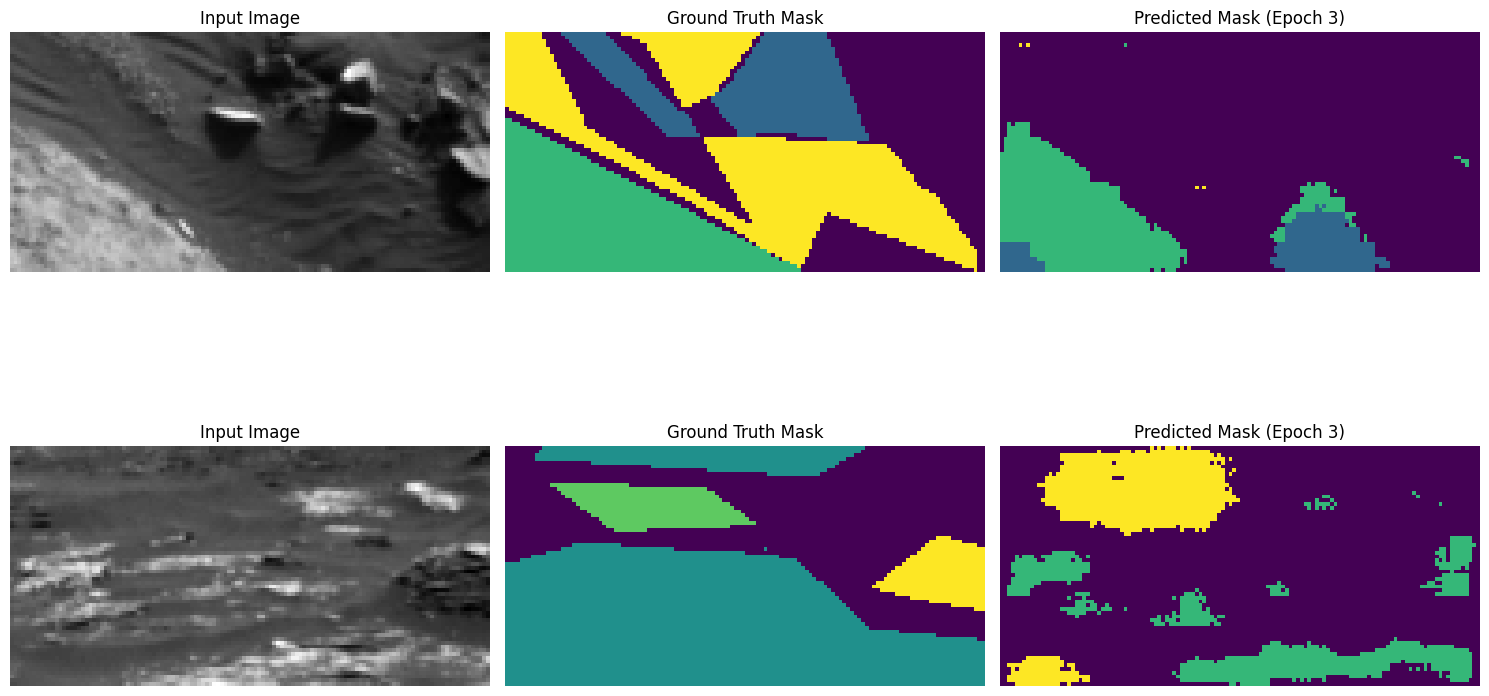

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.5387 - loss: 1.0556 - mean_io_u: 0.2568 - mean_iou: 0.2568 - val_accuracy: 0.6352 - val_loss: 0.9210 - val_mean_io_u: 0.3448 - val_mean_iou: 0.3448 - learning_rate: 1.0000e-04
Epoch 4/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6017 - loss: 0.9622 - mean_io_u: 0.3112 - mean_iou: 0.3112Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 4: val_mean_iou improved to 0.3604, saving model.

Epoch 4: val_loss improved from 0.92100 to 0.88226, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


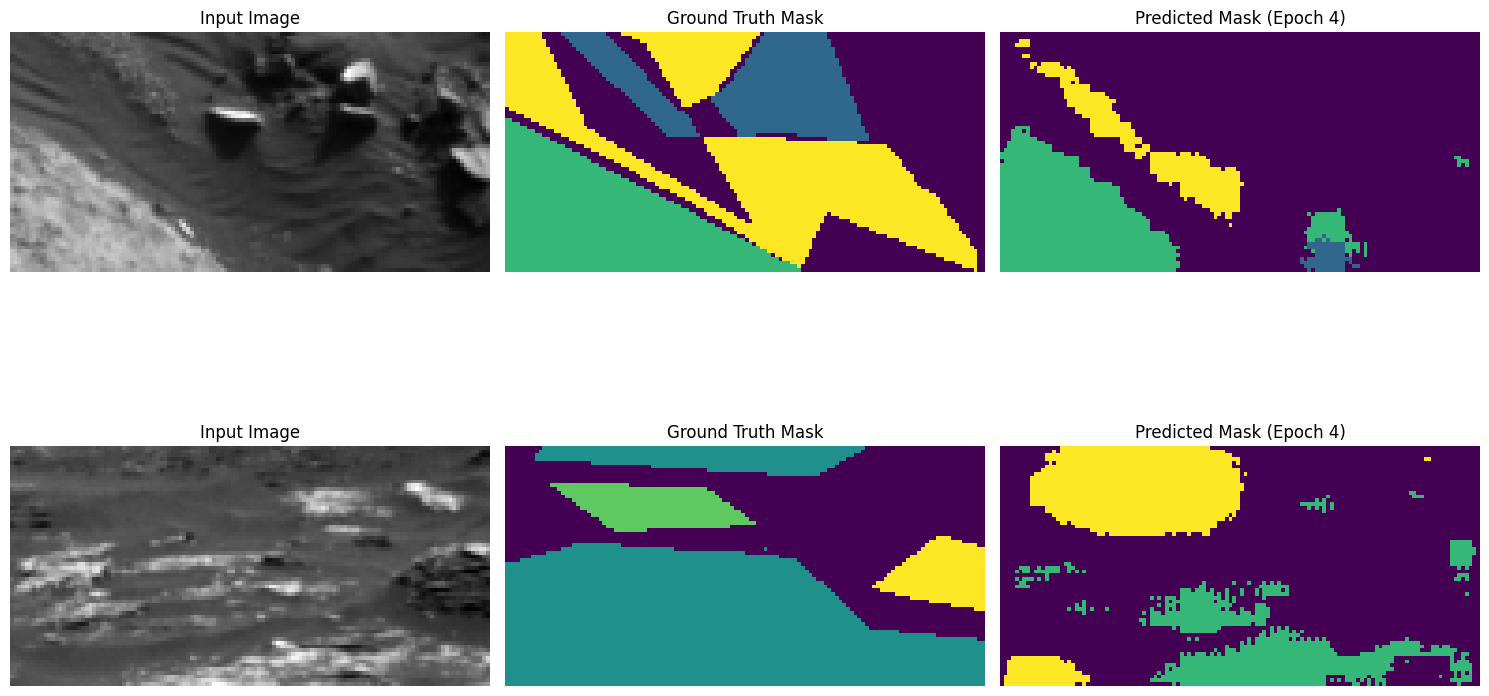

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.6017 - loss: 0.9621 - mean_io_u: 0.3112 - mean_iou: 0.3112 - val_accuracy: 0.6531 - val_loss: 0.8823 - val_mean_io_u: 0.3604 - val_mean_iou: 0.3604 - learning_rate: 1.0000e-04
Epoch 5/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6389 - loss: 0.8926 - mean_io_u: 0.3414 - mean_iou: 0.3414Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 5: val_mean_iou improved to 0.3821, saving model.

Epoch 5: val_loss improved from 0.88226 to 0.82415, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


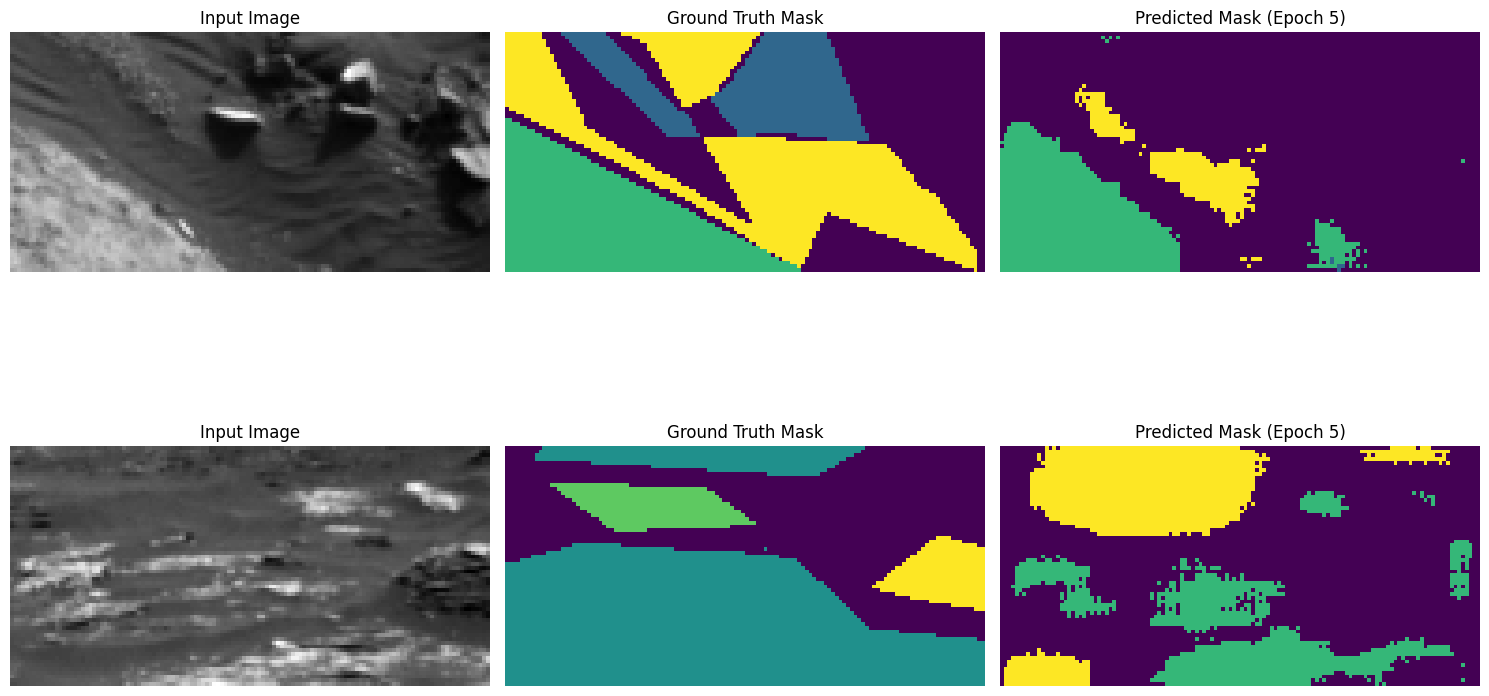

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.6389 - loss: 0.8926 - mean_io_u: 0.3414 - mean_iou: 0.3414 - val_accuracy: 0.6822 - val_loss: 0.8241 - val_mean_io_u: 0.3821 - val_mean_iou: 0.3821 - learning_rate: 1.0000e-04
Epoch 6/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6644 - loss: 0.8409 - mean_io_u: 0.3621 - mean_iou: 0.3621Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 6: val_mean_iou improved to 0.3915, saving model.

Epoch 6: val_loss improved from 0.82415 to 0.80351, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


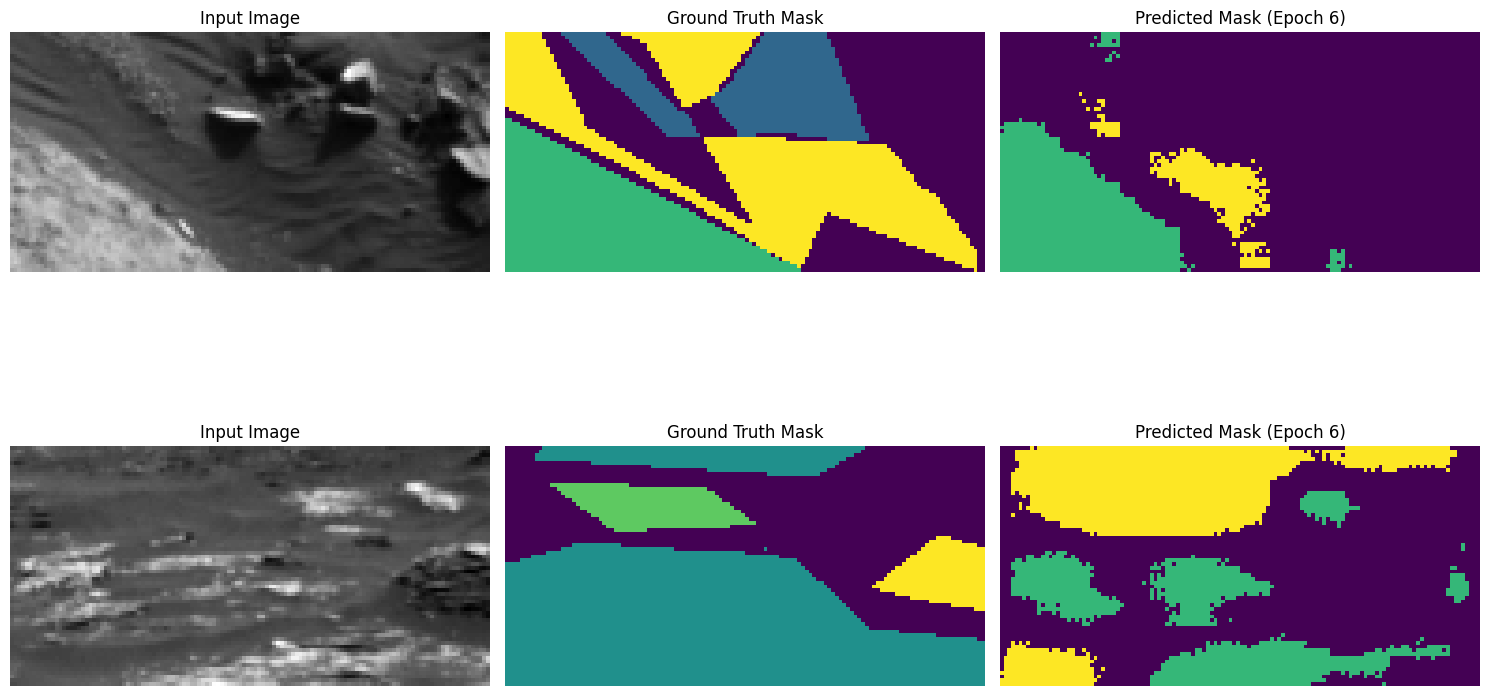

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.6644 - loss: 0.8409 - mean_io_u: 0.3620 - mean_iou: 0.3620 - val_accuracy: 0.6947 - val_loss: 0.8035 - val_mean_io_u: 0.3915 - val_mean_iou: 0.3915 - learning_rate: 1.0000e-04
Epoch 7/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6819 - loss: 0.8028 - mean_io_u: 0.3764 - mean_iou: 0.3764Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 7: val_mean_iou improved to 0.3927, saving model.

Epoch 7: val_loss improved from 0.80351 to 0.80048, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


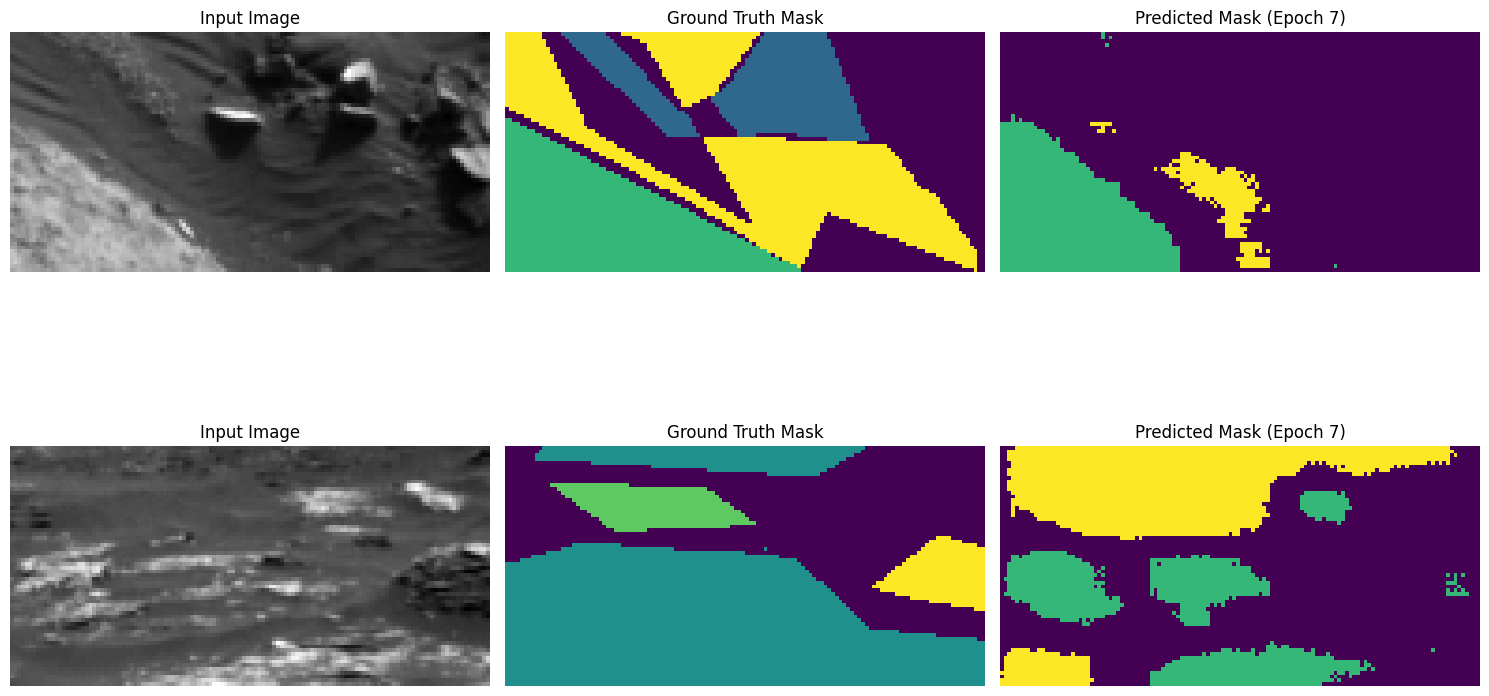

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.6819 - loss: 0.8028 - mean_io_u: 0.3764 - mean_iou: 0.3764 - val_accuracy: 0.6975 - val_loss: 0.8005 - val_mean_io_u: 0.3927 - val_mean_iou: 0.3927 - learning_rate: 1.0000e-04
Epoch 8/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6929 - loss: 0.7795 - mean_io_u: 0.3859 - mean_iou: 0.3859Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 8: val_mean_iou improved to 0.3999, saving model.

Epoch 8: val_loss improved from 0.80048 to 0.78070, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


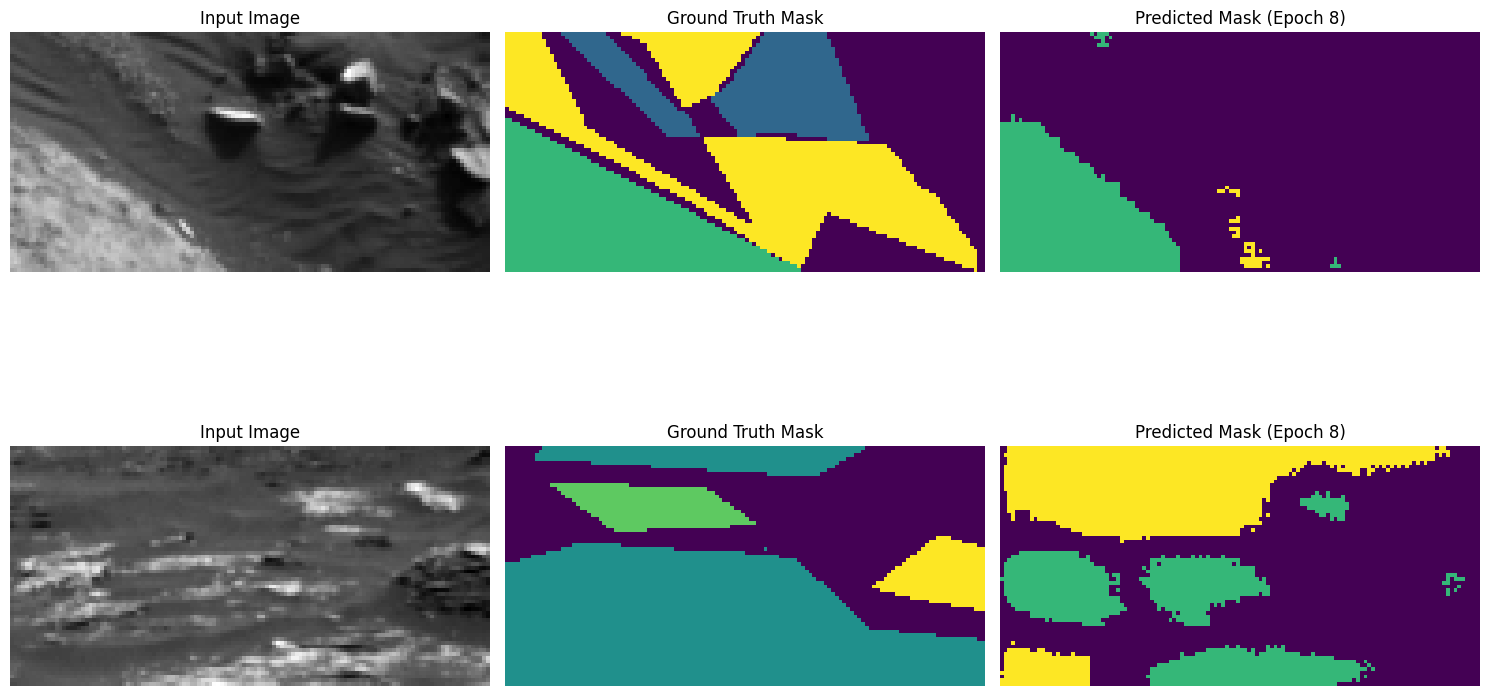

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.6929 - loss: 0.7794 - mean_io_u: 0.3859 - mean_iou: 0.3859 - val_accuracy: 0.7063 - val_loss: 0.7807 - val_mean_io_u: 0.3999 - val_mean_iou: 0.3999 - learning_rate: 1.0000e-04
Epoch 9/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7046 - loss: 0.7505 - mean_io_u: 0.3957 - mean_iou: 0.3957Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 9: val_mean_iou improved to 0.4090, saving model.

Epoch 9: val_loss improved from 0.78070 to 0.76091, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


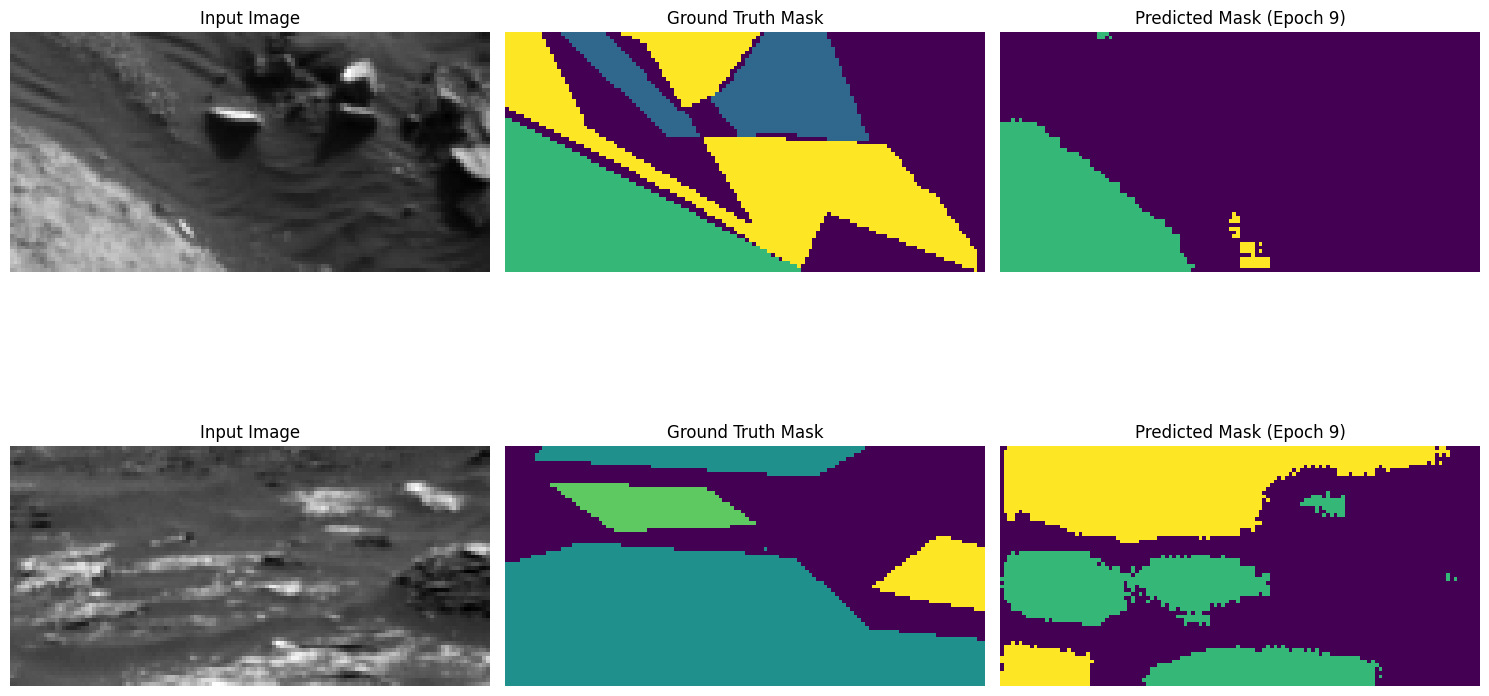

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7046 - loss: 0.7504 - mean_io_u: 0.3956 - mean_iou: 0.3956 - val_accuracy: 0.7152 - val_loss: 0.7609 - val_mean_io_u: 0.4090 - val_mean_iou: 0.4090 - learning_rate: 1.0000e-04
Epoch 10/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7165 - loss: 0.7208 - mean_io_u: 0.4062 - mean_iou: 0.4062Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 10: val_mean_iou improved to 0.4109, saving model.

Epoch 10: val_loss improved from 0.76091 to 0.74810, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


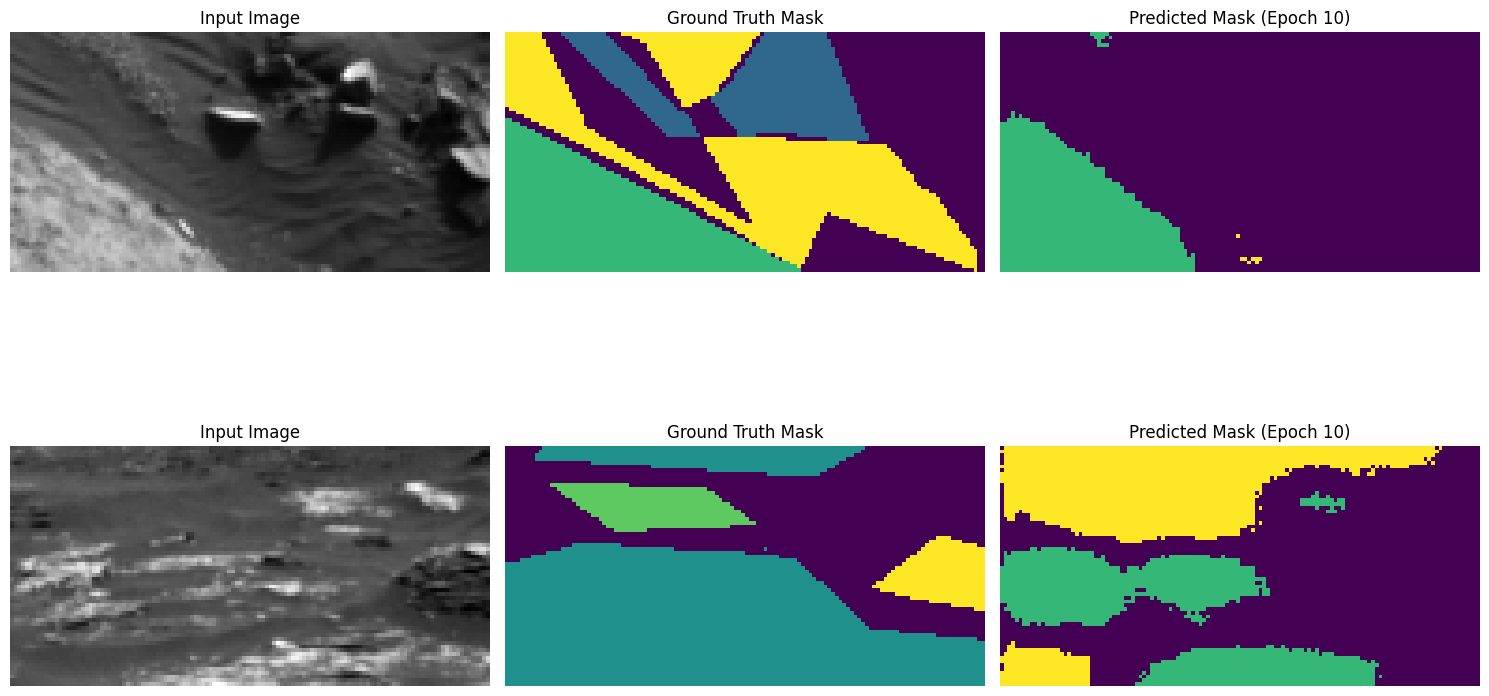

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7165 - loss: 0.7208 - mean_io_u: 0.4062 - mean_iou: 0.4062 - val_accuracy: 0.7185 - val_loss: 0.7481 - val_mean_io_u: 0.4109 - val_mean_iou: 0.4109 - learning_rate: 1.0000e-04
Epoch 11/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7248 - loss: 0.7000 - mean_io_u: 0.4140 - mean_iou: 0.4140Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 11: val_loss improved from 0.74810 to 0.74558, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


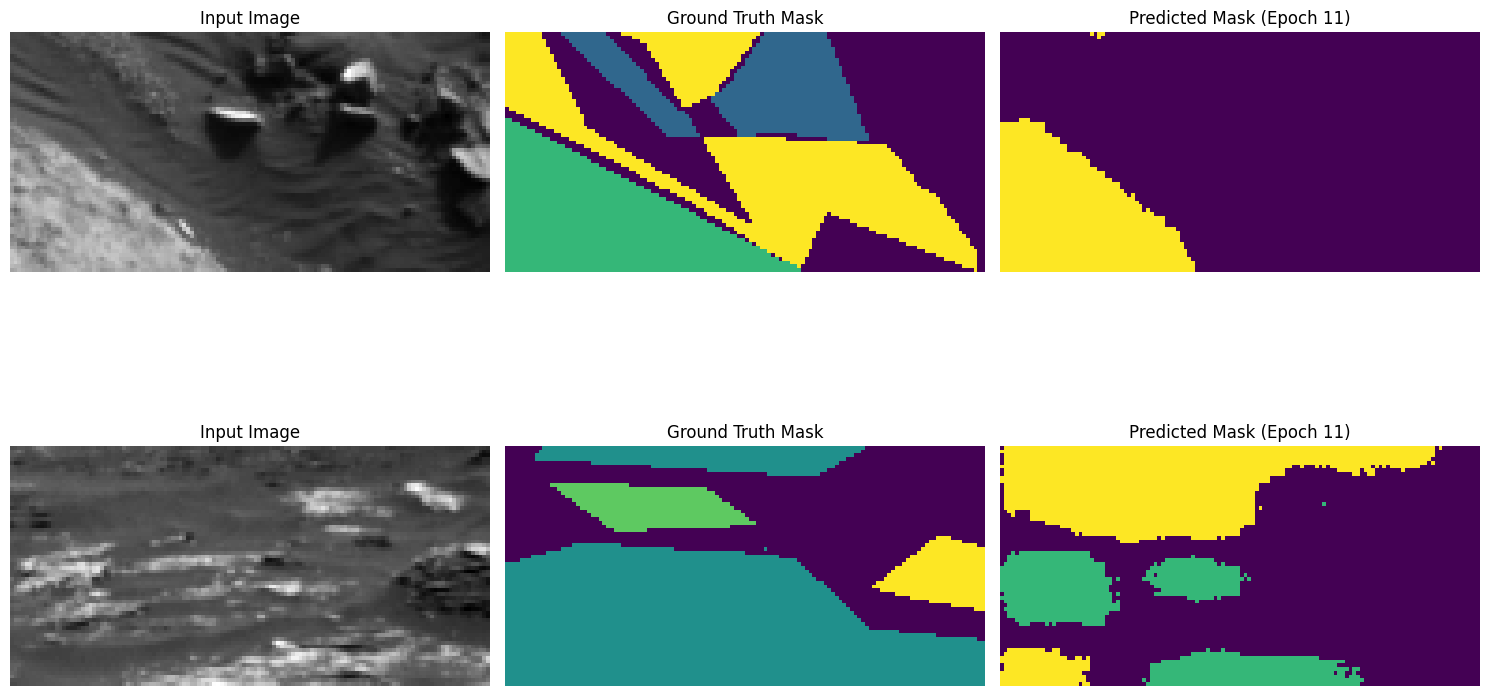

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.7248 - loss: 0.6999 - mean_io_u: 0.4140 - mean_iou: 0.4140 - val_accuracy: 0.7164 - val_loss: 0.7456 - val_mean_io_u: 0.4062 - val_mean_iou: 0.4062 - learning_rate: 1.0000e-04
Epoch 12/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7329 - loss: 0.6774 - mean_io_u: 0.4221 - mean_iou: 0.4221Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 12: val_loss improved from 0.74558 to 0.73776, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


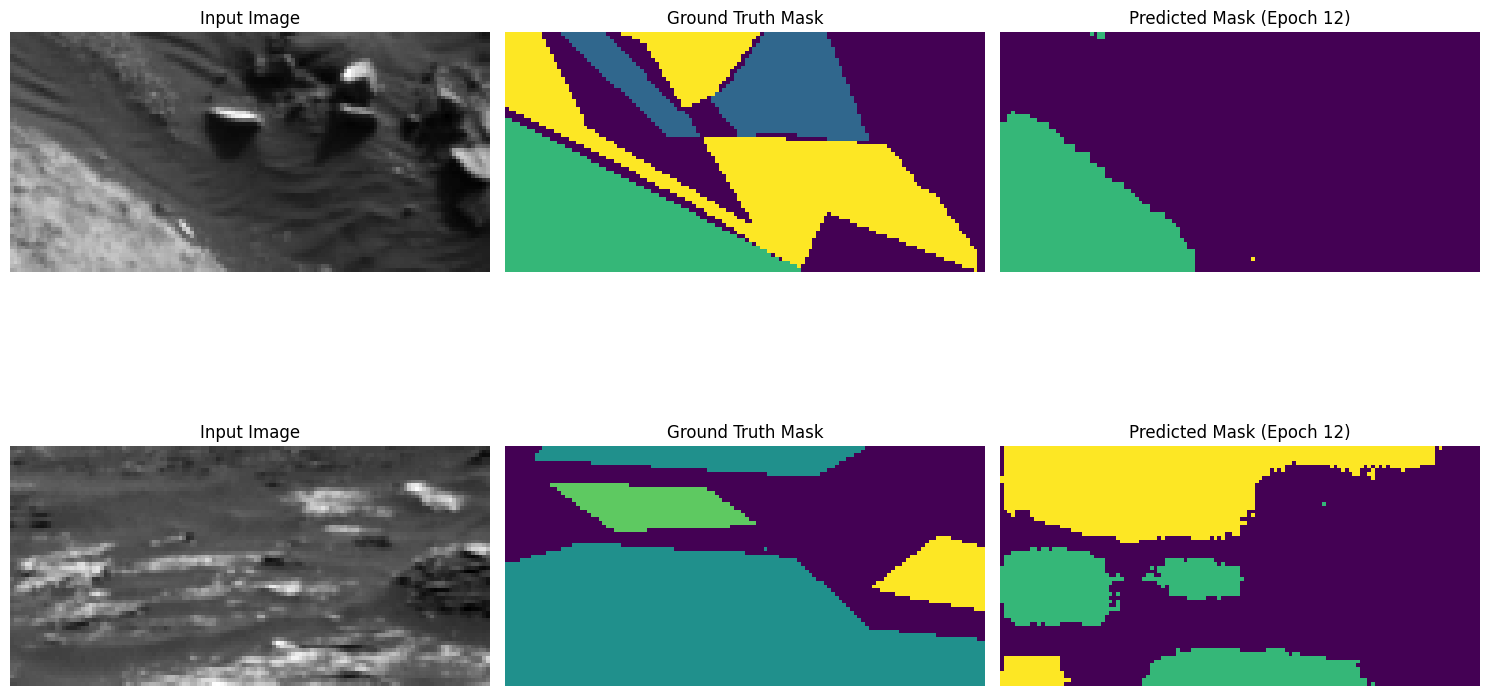

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7329 - loss: 0.6773 - mean_io_u: 0.4221 - mean_iou: 0.4221 - val_accuracy: 0.7184 - val_loss: 0.7378 - val_mean_io_u: 0.4075 - val_mean_iou: 0.4075 - learning_rate: 1.0000e-04
Epoch 13/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7419 - loss: 0.6561 - mean_io_u: 0.4326 - mean_iou: 0.4326Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 13: val_loss did not improve from 0.73776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


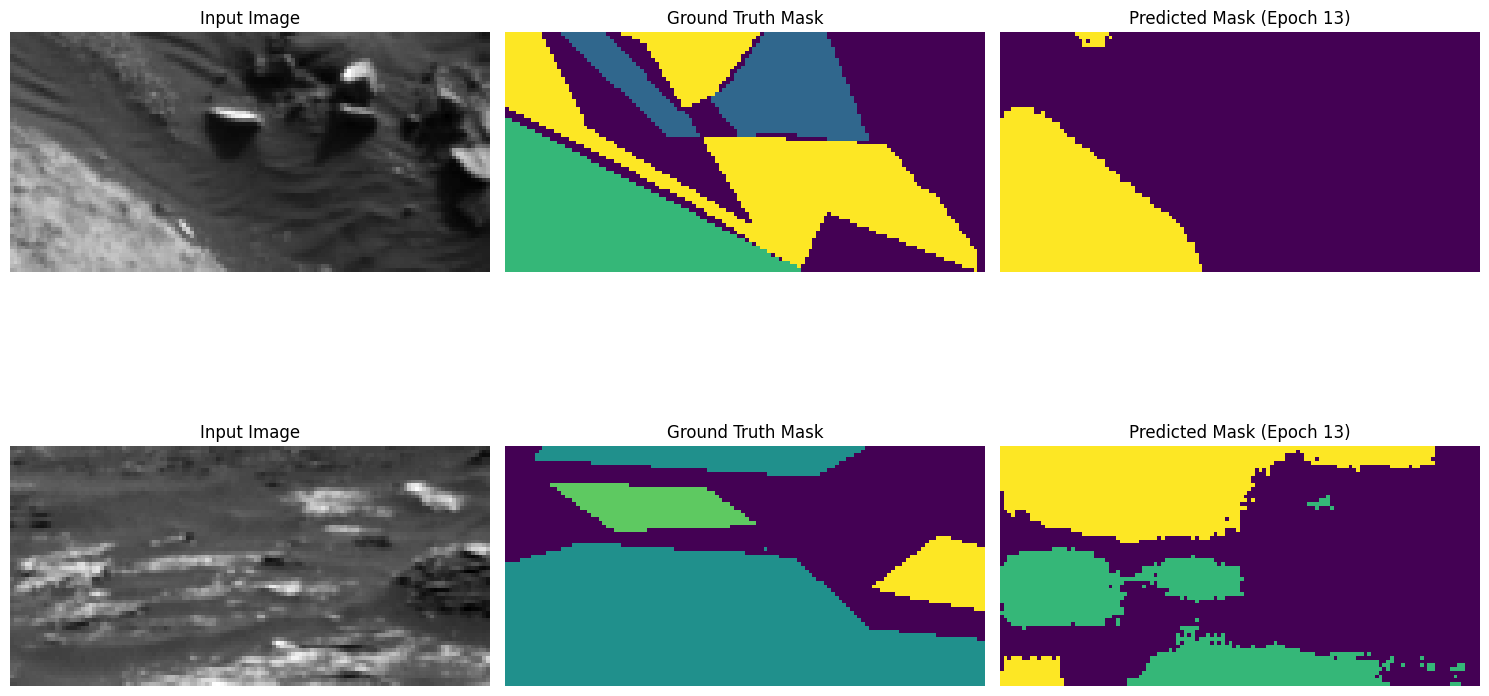

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 191ms/step - accuracy: 0.7420 - loss: 0.6560 - mean_io_u: 0.4325 - mean_iou: 0.4325 - val_accuracy: 0.7158 - val_loss: 0.7485 - val_mean_io_u: 0.4038 - val_mean_iou: 0.4038 - learning_rate: 1.0000e-04
Epoch 14/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7495 - loss: 0.6383 - mean_io_u: 0.4424 - mean_iou: 0.4424Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 14: val_mean_iou improved to 0.4250, saving model.

Epoch 14: val_loss improved from 0.73776 to 0.70380, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


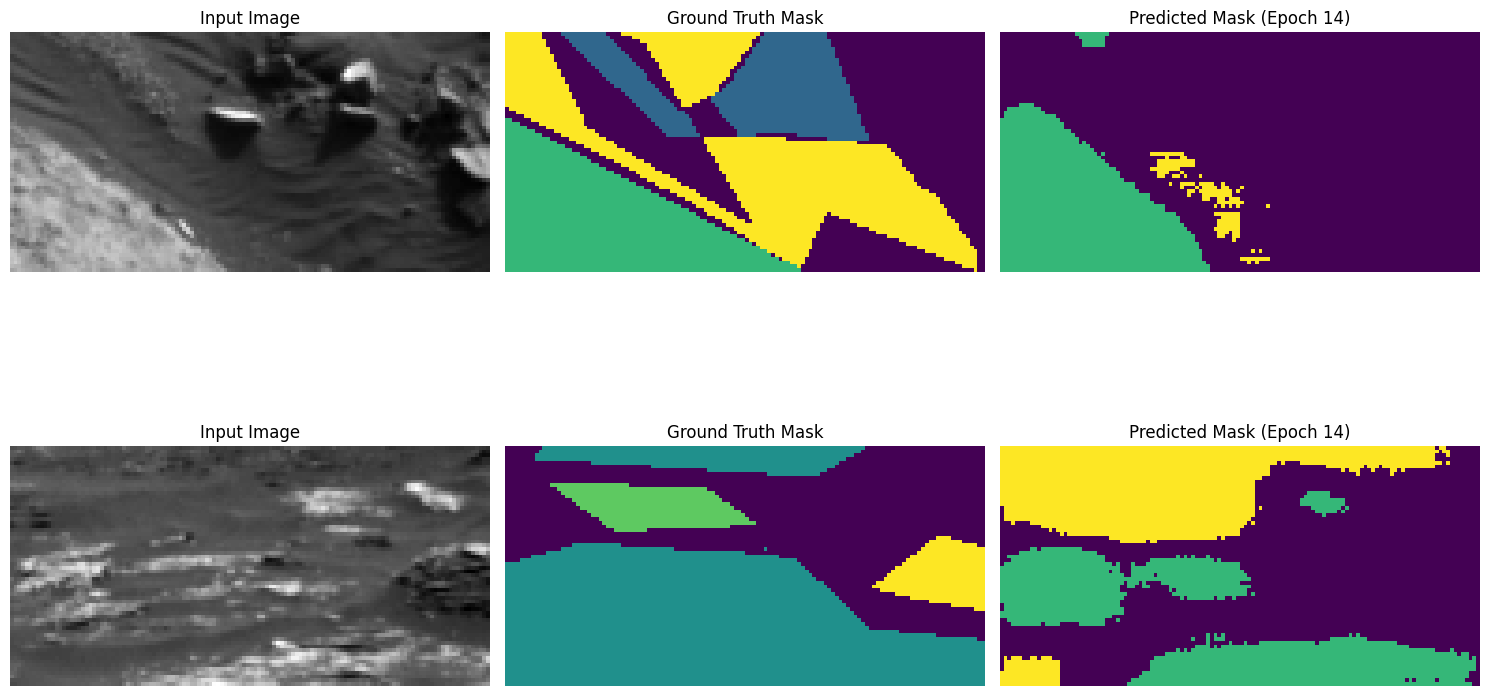

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7495 - loss: 0.6382 - mean_io_u: 0.4423 - mean_iou: 0.4423 - val_accuracy: 0.7347 - val_loss: 0.7038 - val_mean_io_u: 0.4250 - val_mean_iou: 0.4250 - learning_rate: 1.0000e-04
Epoch 15/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7563 - loss: 0.6208 - mean_io_u: 0.4505 - mean_iou: 0.4505Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 15: val_mean_iou improved to 0.4382, saving model.

Epoch 15: val_loss improved from 0.70380 to 0.68172, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


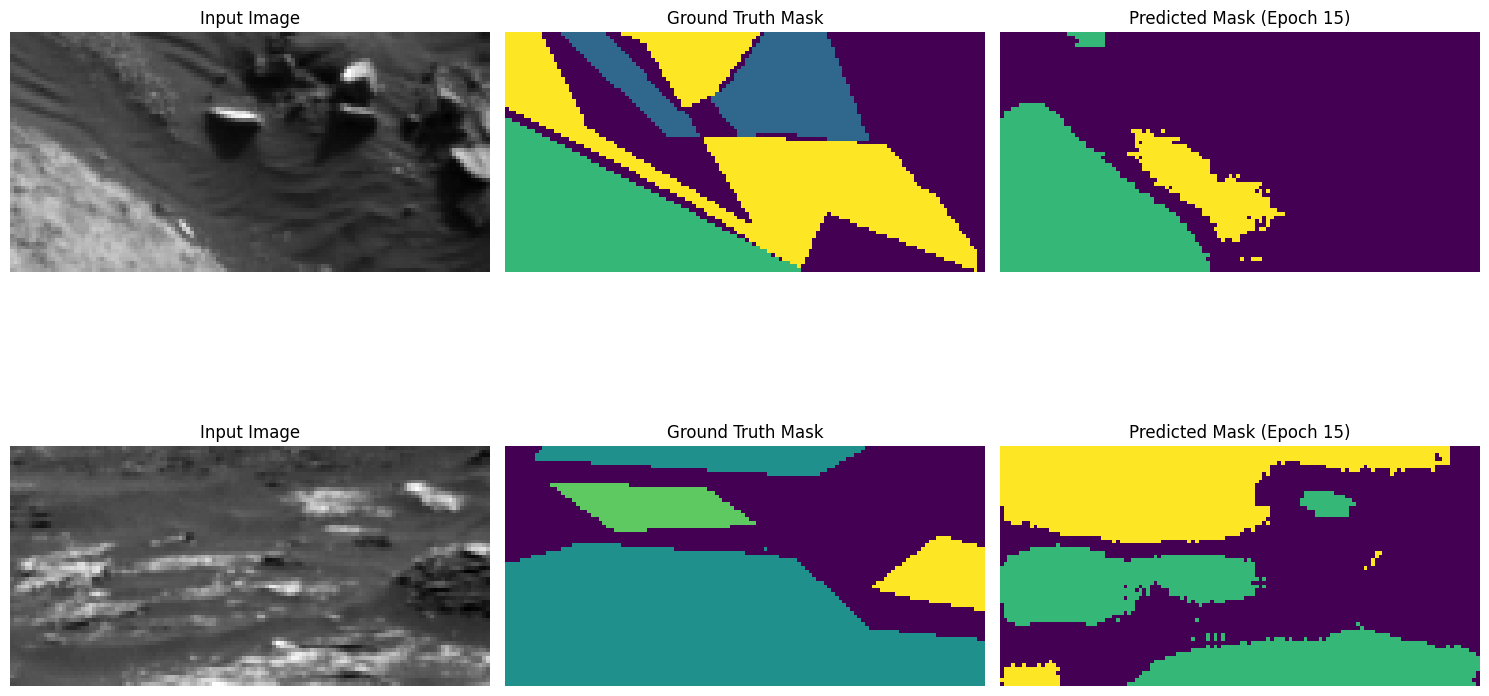

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7563 - loss: 0.6208 - mean_io_u: 0.4505 - mean_iou: 0.4505 - val_accuracy: 0.7475 - val_loss: 0.6817 - val_mean_io_u: 0.4382 - val_mean_iou: 0.4382 - learning_rate: 1.0000e-04
Epoch 16/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7646 - loss: 0.5975 - mean_io_u: 0.4587 - mean_iou: 0.4587Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 16: val_mean_iou improved to 0.4443, saving model.

Epoch 16: val_loss improved from 0.68172 to 0.67184, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


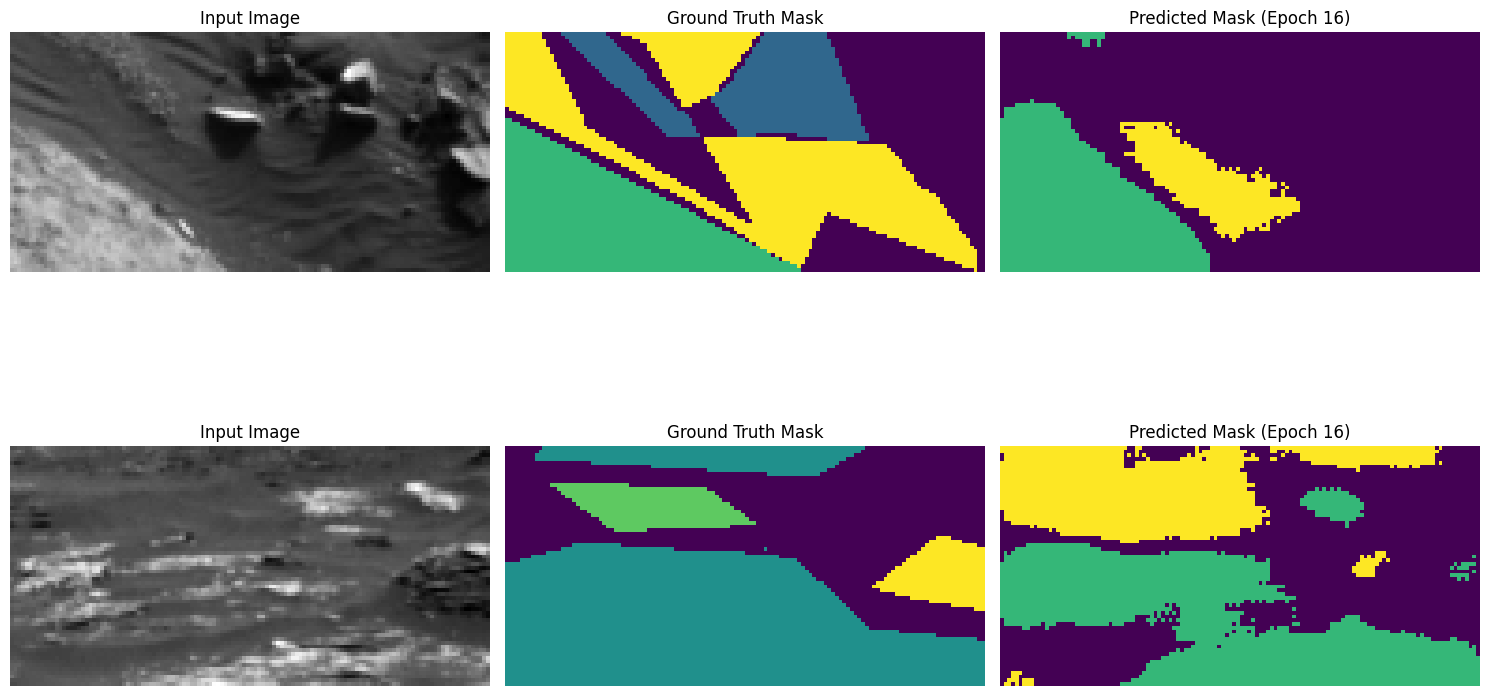

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.7646 - loss: 0.5974 - mean_io_u: 0.4587 - mean_iou: 0.4587 - val_accuracy: 0.7518 - val_loss: 0.6718 - val_mean_io_u: 0.4443 - val_mean_iou: 0.4443 - learning_rate: 1.0000e-04
Epoch 17/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7717 - loss: 0.5789 - mean_io_u: 0.4673 - mean_iou: 0.4673Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 17: val_loss did not improve from 0.67184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


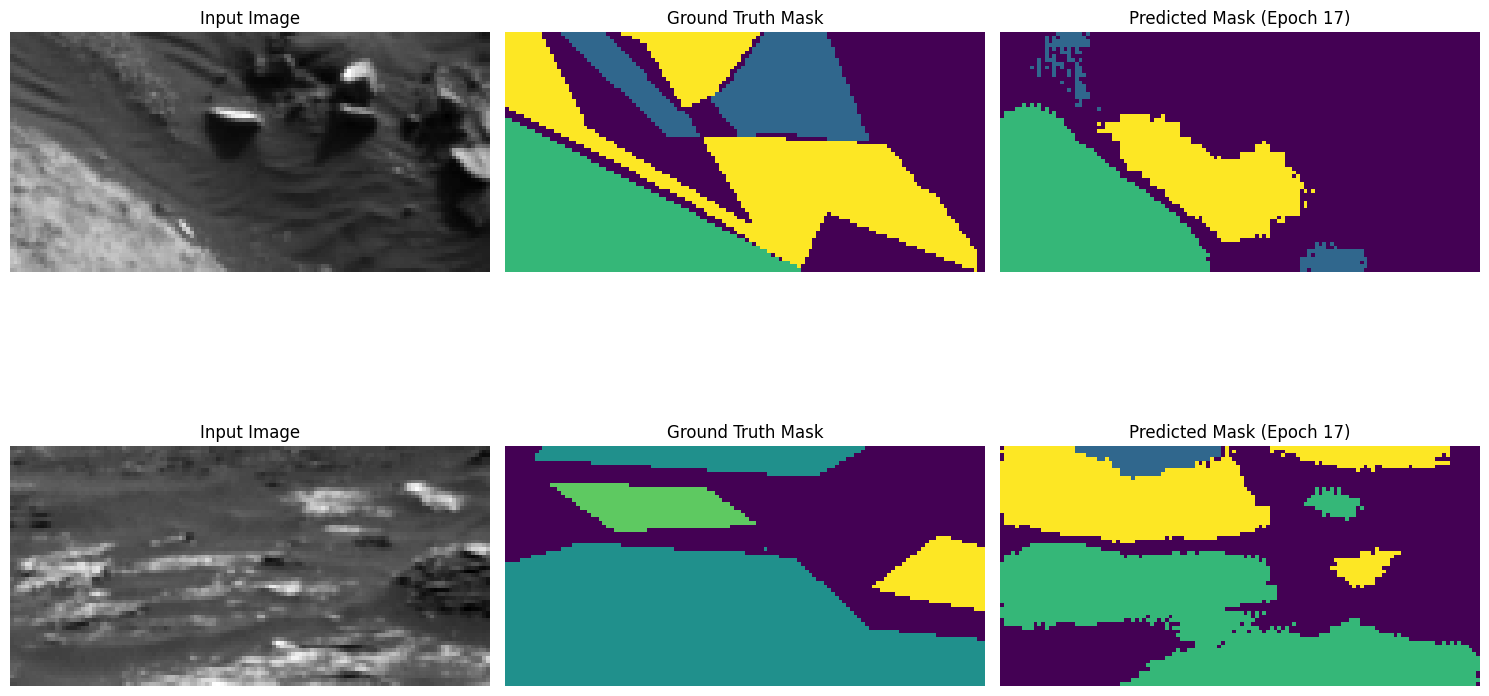

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.7717 - loss: 0.5789 - mean_io_u: 0.4673 - mean_iou: 0.4673 - val_accuracy: 0.7374 - val_loss: 0.7220 - val_mean_io_u: 0.4262 - val_mean_iou: 0.4262 - learning_rate: 1.0000e-04
Epoch 18/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7757 - loss: 0.5713 - mean_io_u: 0.4721 - mean_iou: 0.4721Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 18: val_loss did not improve from 0.67184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


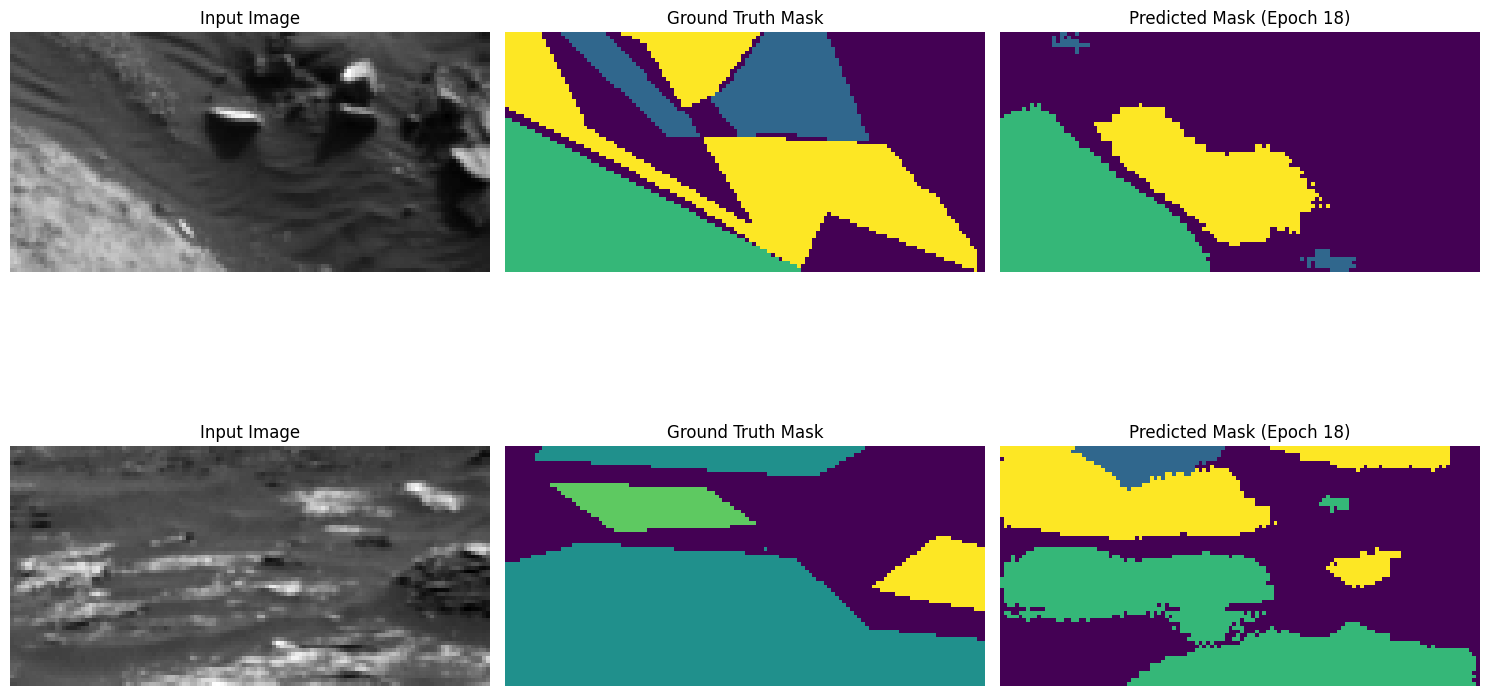

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.7758 - loss: 0.5713 - mean_io_u: 0.4721 - mean_iou: 0.4721 - val_accuracy: 0.7314 - val_loss: 0.7578 - val_mean_io_u: 0.4152 - val_mean_iou: 0.4152 - learning_rate: 1.0000e-04
Epoch 19/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7846 - loss: 0.5507 - mean_io_u: 0.4801 - mean_iou: 0.4801Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 19: val_loss did not improve from 0.67184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


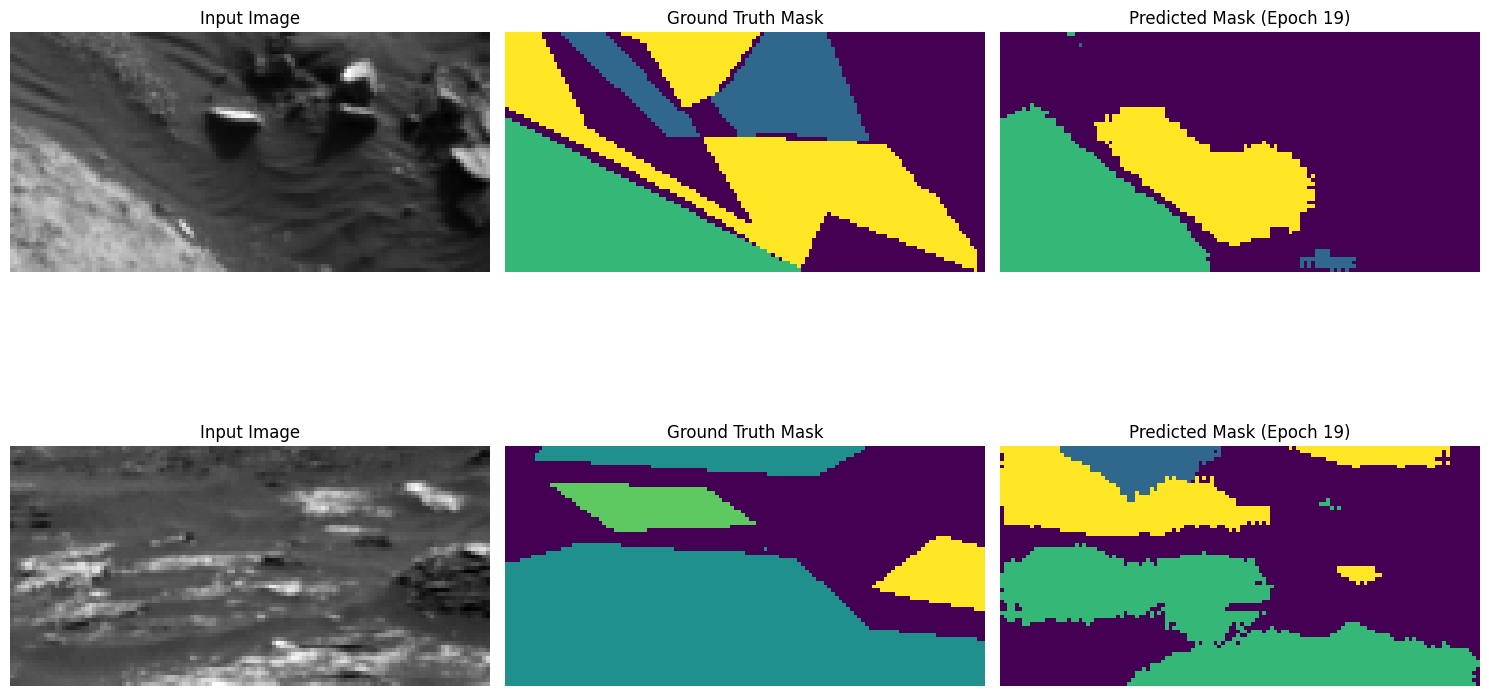

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.7847 - loss: 0.5507 - mean_io_u: 0.4801 - mean_iou: 0.4801 - val_accuracy: 0.7334 - val_loss: 0.7731 - val_mean_io_u: 0.4165 - val_mean_iou: 0.4165 - learning_rate: 1.0000e-04
Epoch 20/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7914 - loss: 0.5334 - mean_io_u: 0.4872 - mean_iou: 0.4872Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 20: val_loss did not improve from 0.67184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


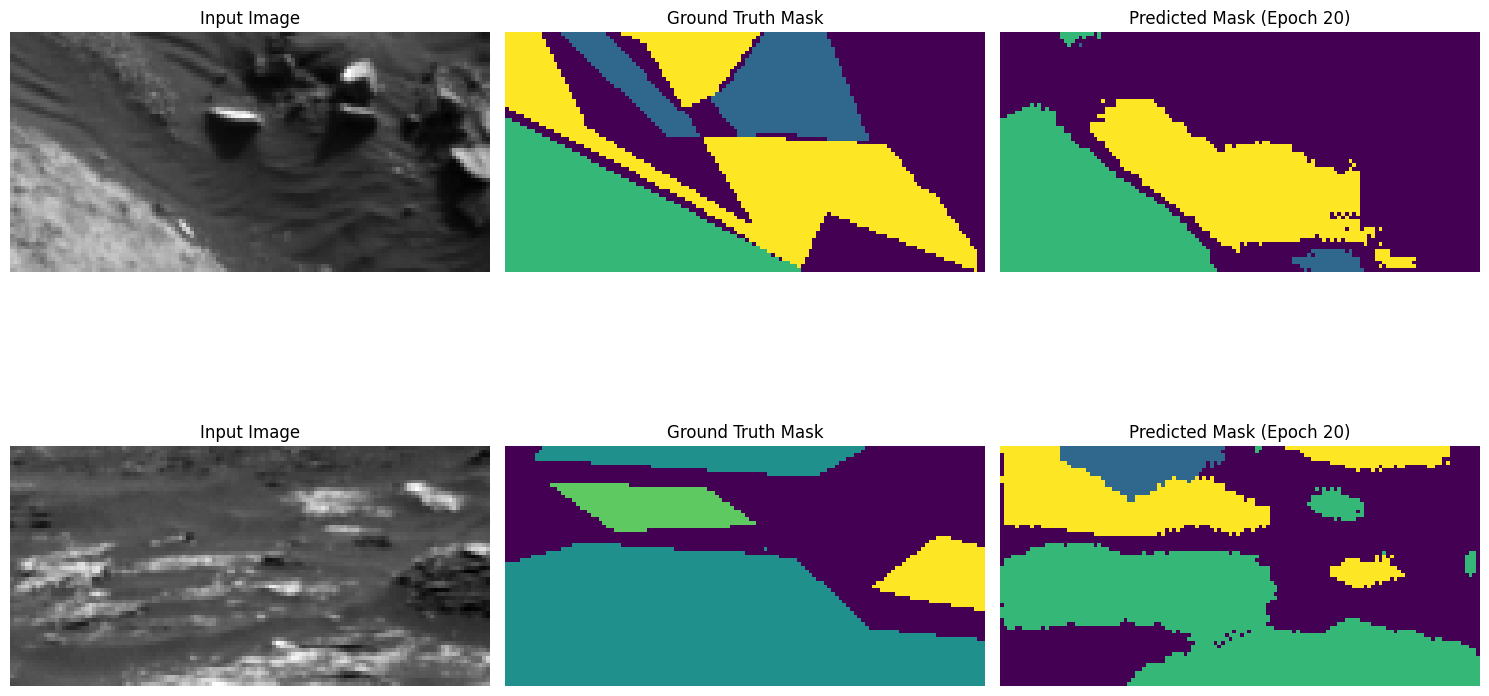

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.7915 - loss: 0.5333 - mean_io_u: 0.4872 - mean_iou: 0.4872 - val_accuracy: 0.7357 - val_loss: 0.7797 - val_mean_io_u: 0.4243 - val_mean_iou: 0.4243 - learning_rate: 1.0000e-04
Epoch 21/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7953 - loss: 0.5239 - mean_io_u: 0.4916 - mean_iou: 0.4916Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 21: val_loss did not improve from 0.67184

Epoch 21: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


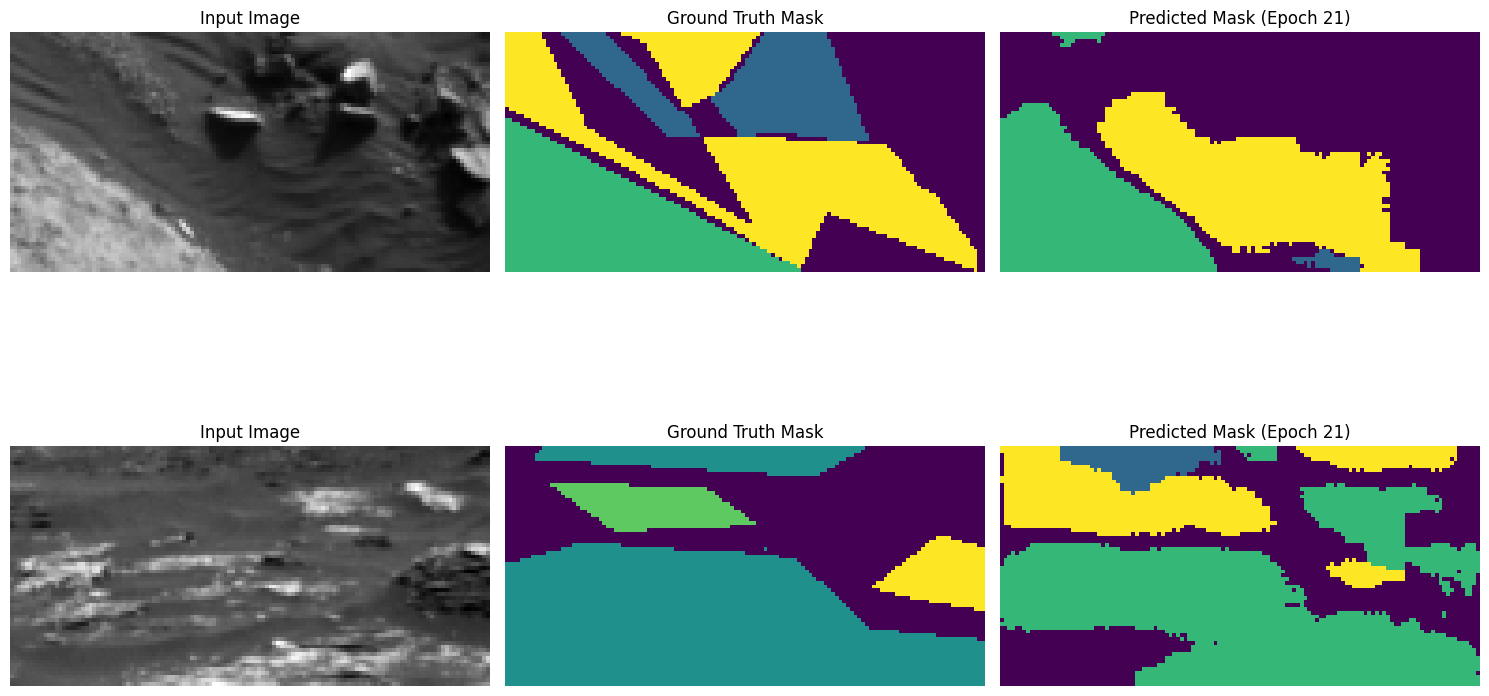

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.7954 - loss: 0.5238 - mean_io_u: 0.4916 - mean_iou: 0.4916 - val_accuracy: 0.7419 - val_loss: 0.7588 - val_mean_io_u: 0.4386 - val_mean_iou: 0.4386 - learning_rate: 1.0000e-04
Epoch 22/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8186 - loss: 0.4652 - mean_io_u: 0.5231 - mean_iou: 0.5231Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 22: val_mean_iou improved to 0.4658, saving model.

Epoch 22: val_loss improved from 0.67184 to 0.66986, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


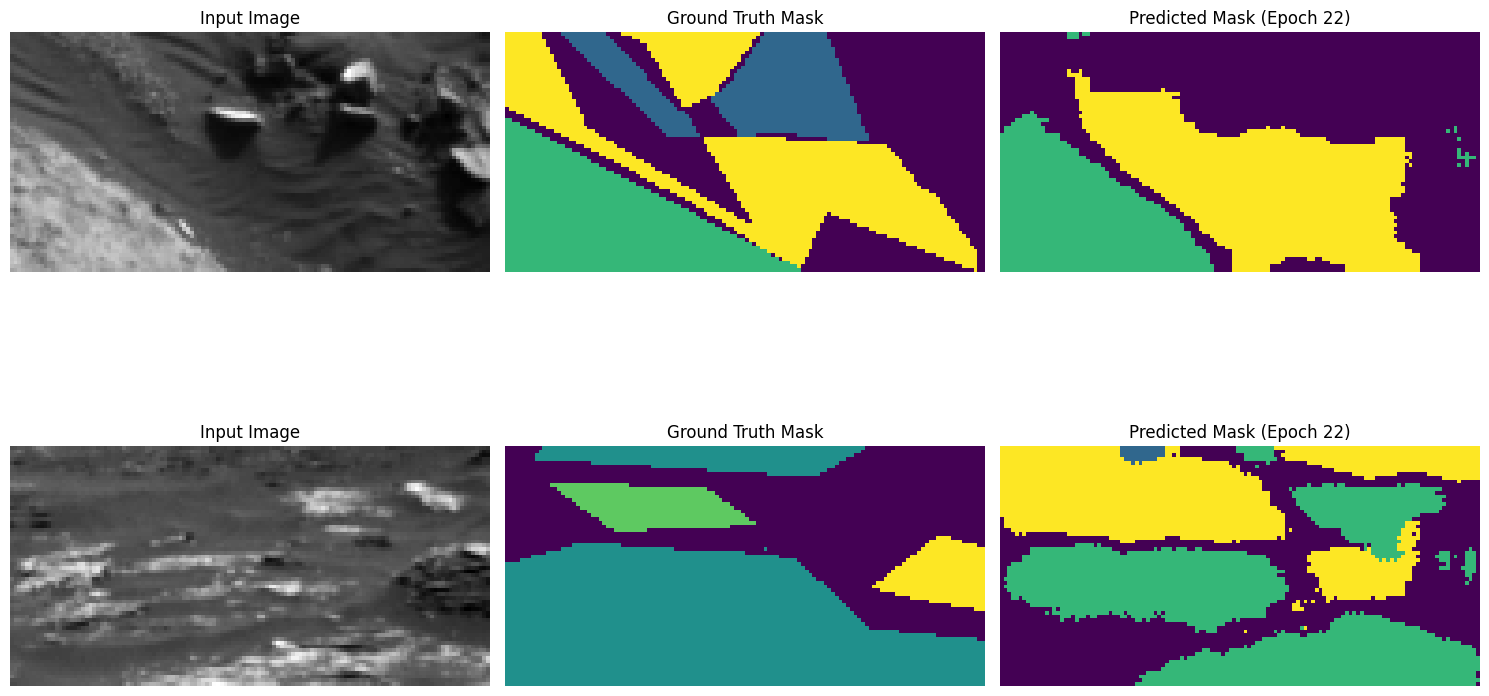

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8186 - loss: 0.4651 - mean_io_u: 0.5231 - mean_iou: 0.5231 - val_accuracy: 0.7610 - val_loss: 0.6699 - val_mean_io_u: 0.4658 - val_mean_iou: 0.4658 - learning_rate: 5.0000e-05
Epoch 23/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8323 - loss: 0.4311 - mean_io_u: 0.5369 - mean_iou: 0.5369Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 23: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


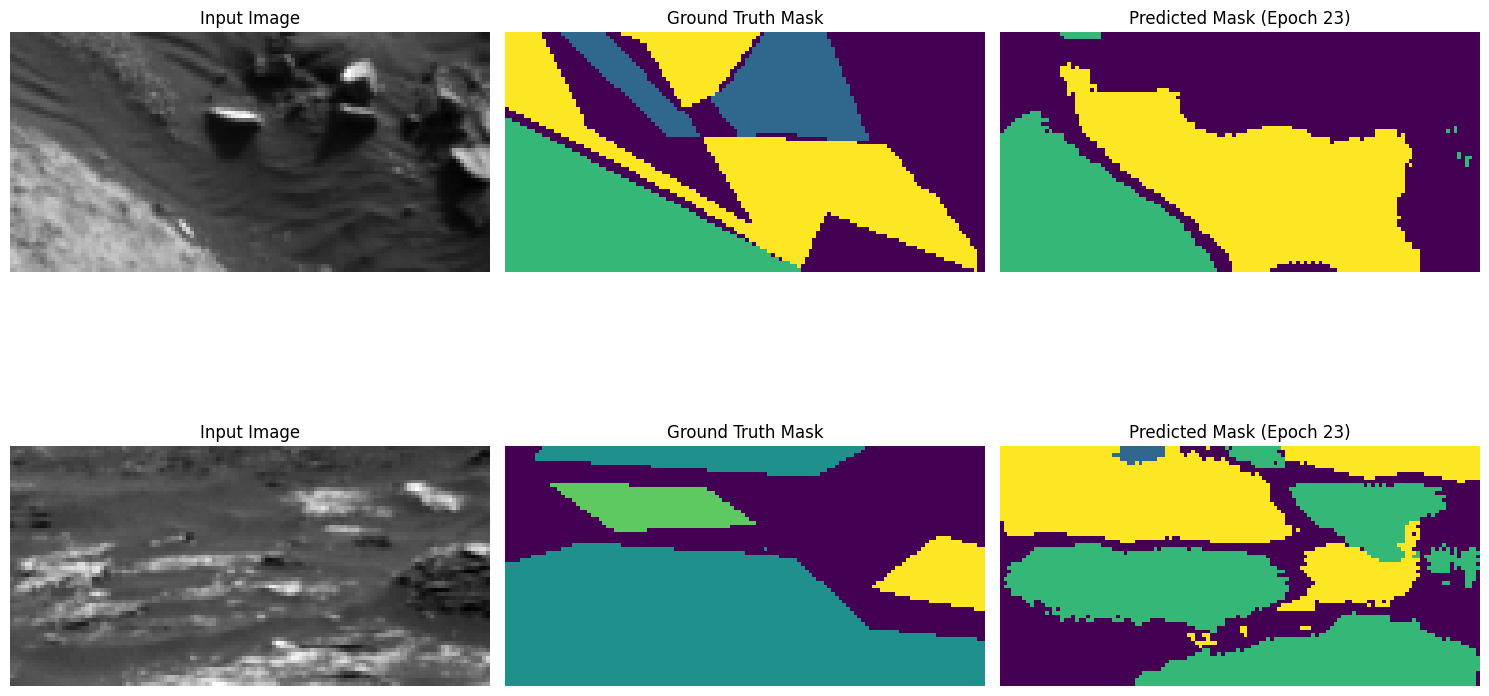

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.8323 - loss: 0.4311 - mean_io_u: 0.5368 - mean_iou: 0.5368 - val_accuracy: 0.7572 - val_loss: 0.6891 - val_mean_io_u: 0.4622 - val_mean_iou: 0.4622 - learning_rate: 5.0000e-05
Epoch 24/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8401 - loss: 0.4116 - mean_io_u: 0.5441 - mean_iou: 0.5441Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 24: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


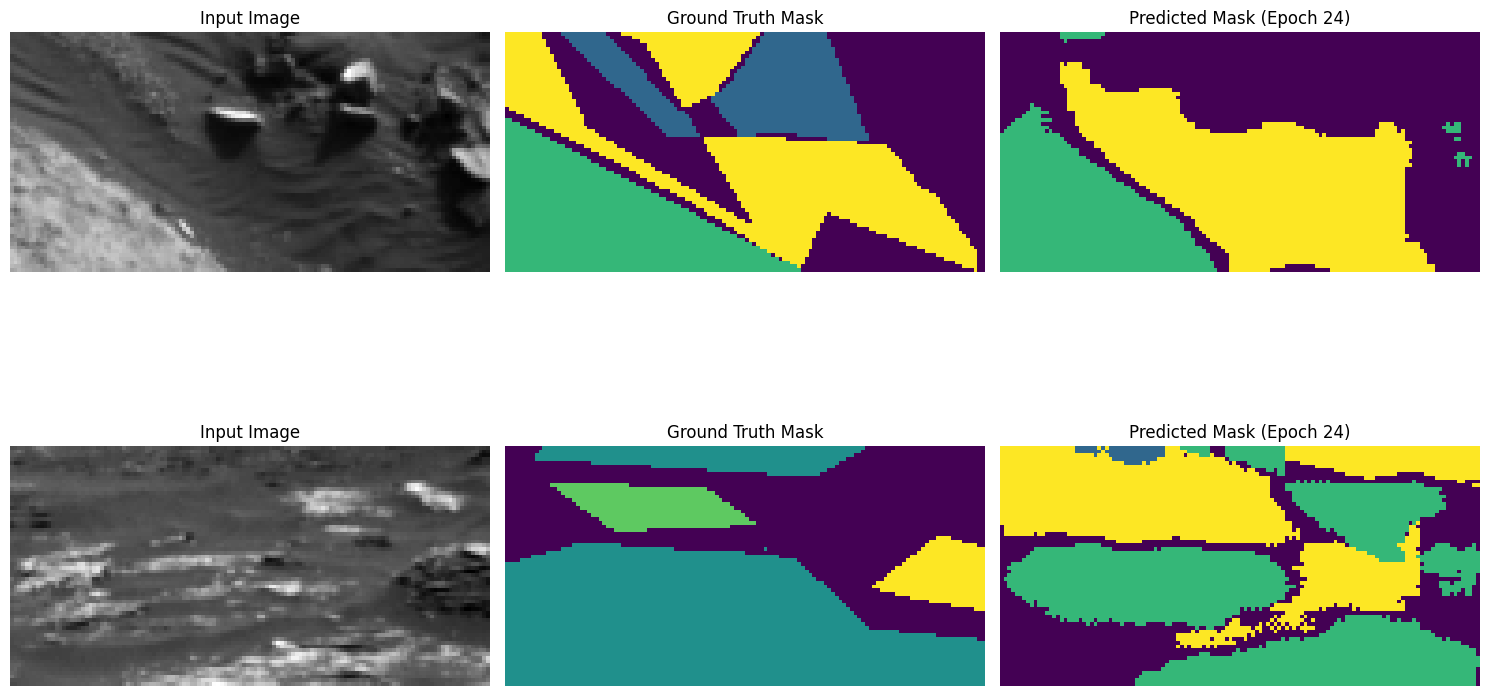

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.8401 - loss: 0.4116 - mean_io_u: 0.5441 - mean_iou: 0.5441 - val_accuracy: 0.7557 - val_loss: 0.7011 - val_mean_io_u: 0.4628 - val_mean_iou: 0.4628 - learning_rate: 5.0000e-05
Epoch 25/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8473 - loss: 0.3938 - mean_io_u: 0.5503 - mean_iou: 0.5503Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 25: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


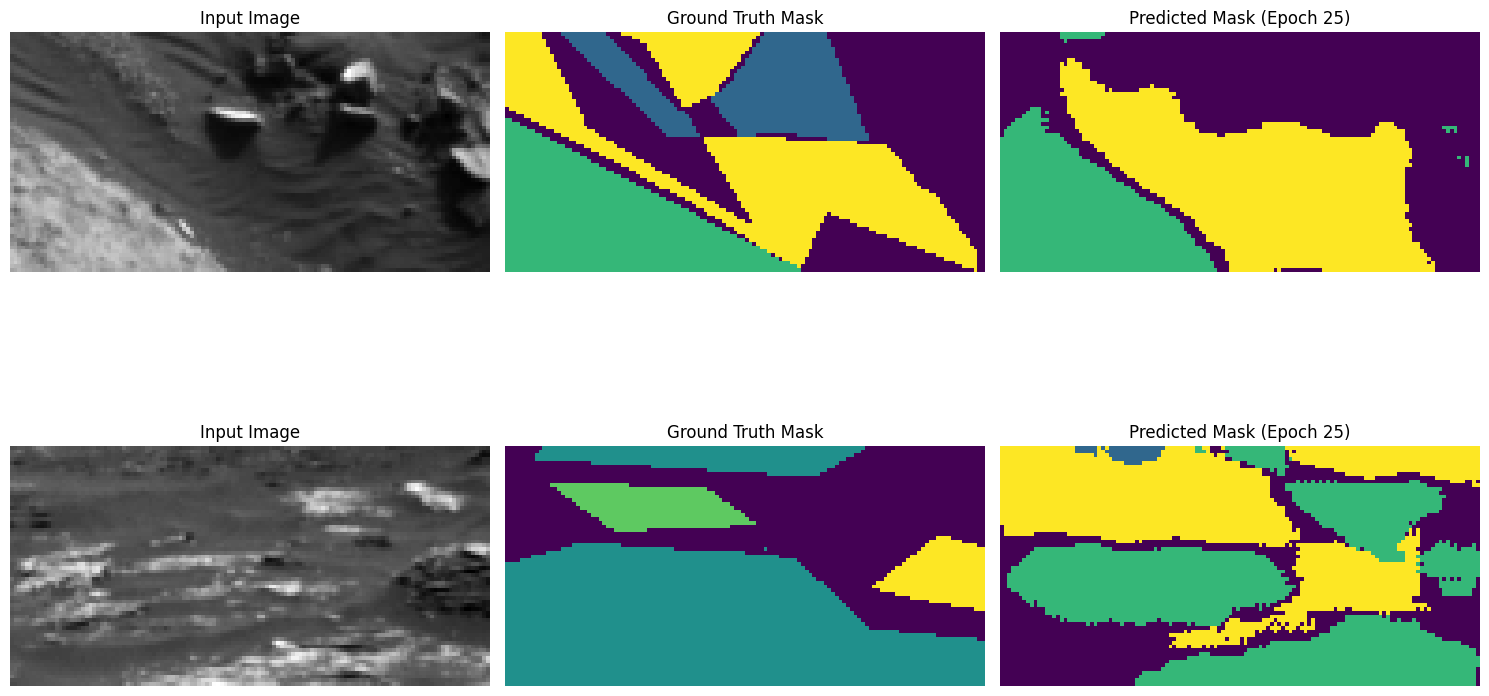

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.8473 - loss: 0.3937 - mean_io_u: 0.5503 - mean_iou: 0.5503 - val_accuracy: 0.7535 - val_loss: 0.7122 - val_mean_io_u: 0.4634 - val_mean_iou: 0.4634 - learning_rate: 5.0000e-05
Epoch 26/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8547 - loss: 0.3756 - mean_io_u: 0.5567 - mean_iou: 0.5567Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 26: val_mean_iou improved to 0.4663, saving model.

Epoch 26: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


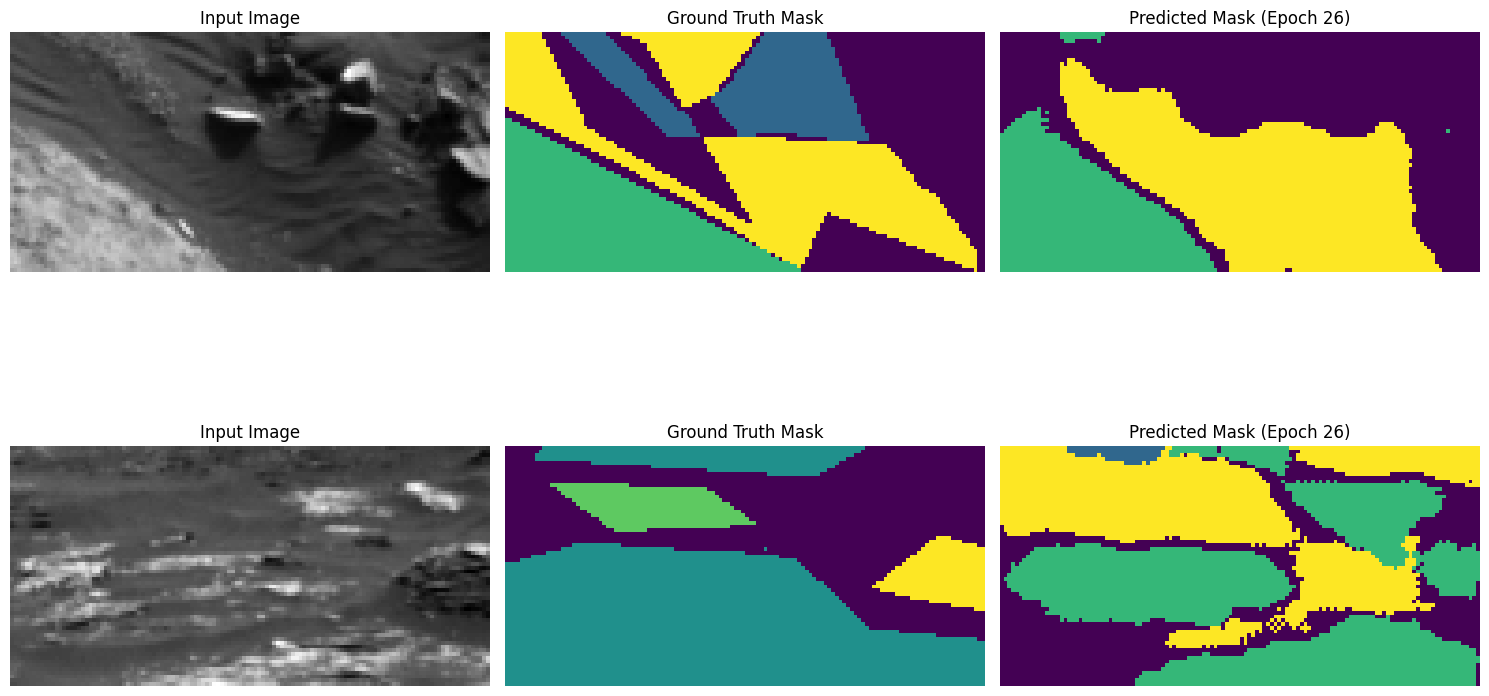

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8548 - loss: 0.3756 - mean_io_u: 0.5567 - mean_iou: 0.5567 - val_accuracy: 0.7528 - val_loss: 0.7257 - val_mean_io_u: 0.4663 - val_mean_iou: 0.4663 - learning_rate: 5.0000e-05
Epoch 27/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8615 - loss: 0.3589 - mean_io_u: 0.5636 - mean_iou: 0.5636Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 27: val_loss did not improve from 0.66986

Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


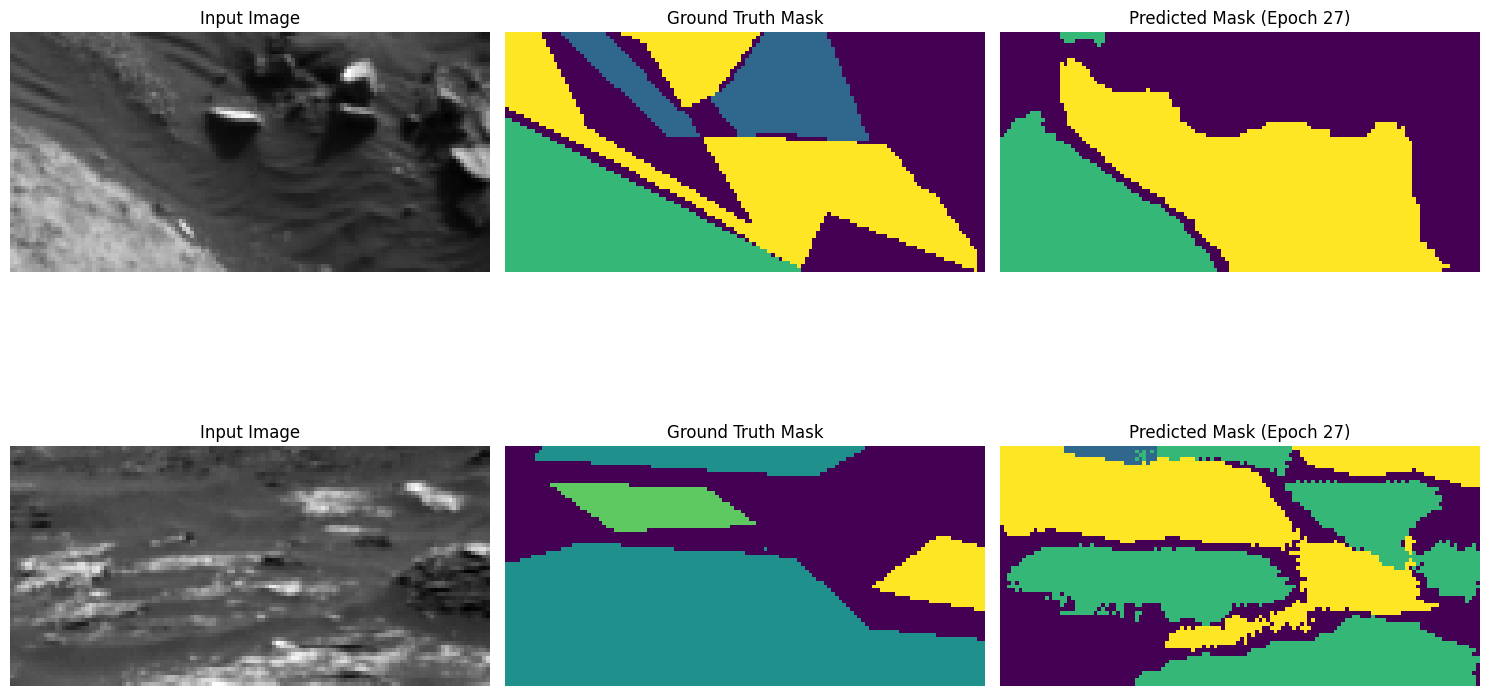

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.8615 - loss: 0.3589 - mean_io_u: 0.5636 - mean_iou: 0.5636 - val_accuracy: 0.7493 - val_loss: 0.7489 - val_mean_io_u: 0.4642 - val_mean_iou: 0.4642 - learning_rate: 5.0000e-05
Epoch 28/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8660 - loss: 0.3475 - mean_io_u: 0.5723 - mean_iou: 0.5723Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 28: val_mean_iou improved to 0.4685, saving model.

Epoch 28: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


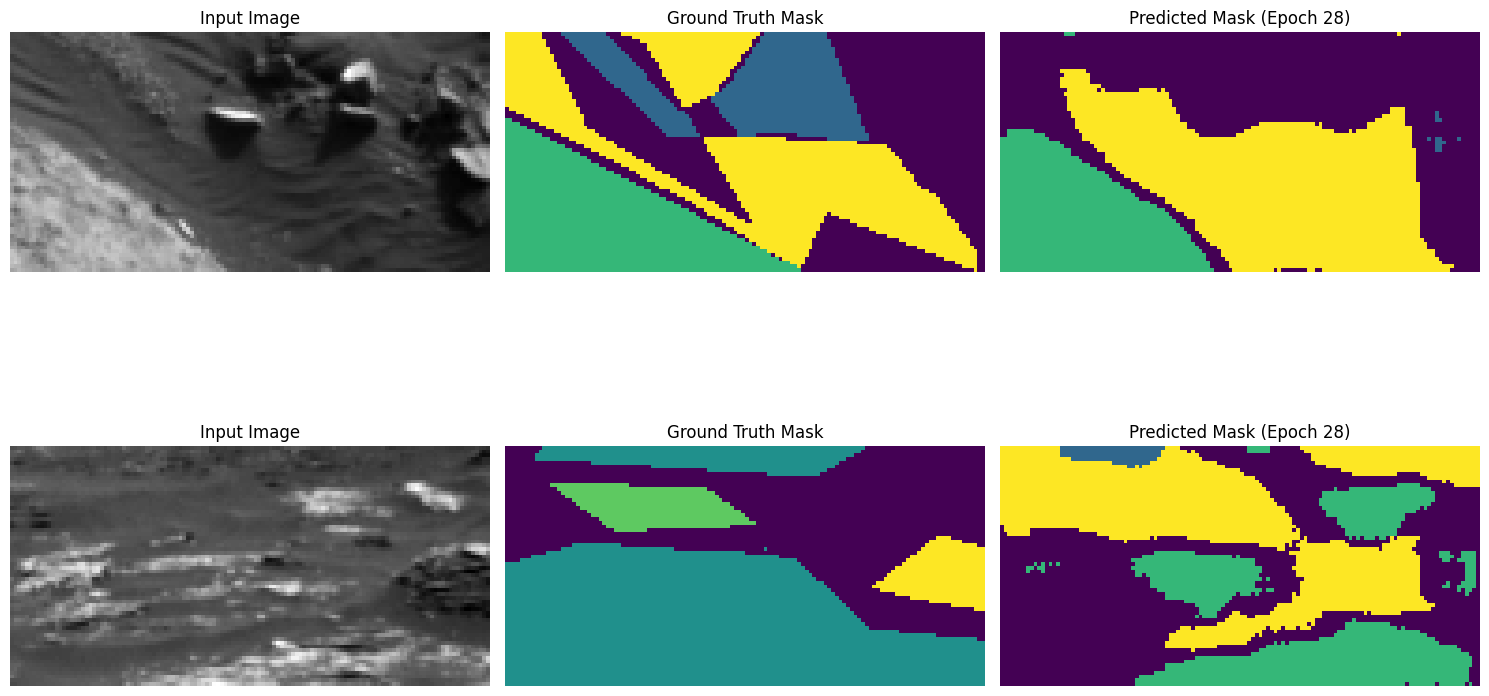

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8660 - loss: 0.3475 - mean_io_u: 0.5723 - mean_iou: 0.5723 - val_accuracy: 0.7582 - val_loss: 0.7694 - val_mean_io_u: 0.4685 - val_mean_iou: 0.4685 - learning_rate: 2.5000e-05
Epoch 29/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8727 - loss: 0.3305 - mean_io_u: 0.5782 - mean_iou: 0.5782Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 29: val_mean_iou improved to 0.4722, saving model.

Epoch 29: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


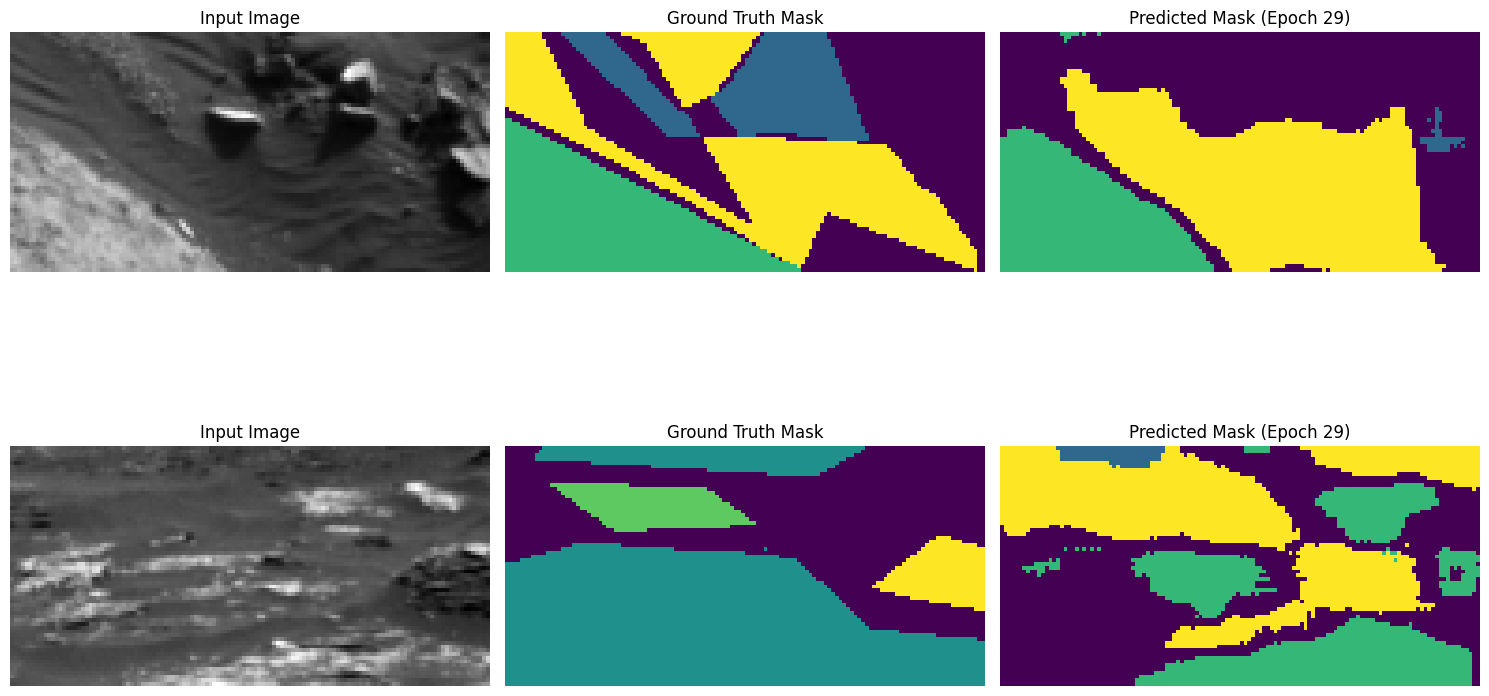

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8727 - loss: 0.3305 - mean_io_u: 0.5782 - mean_iou: 0.5782 - val_accuracy: 0.7606 - val_loss: 0.7691 - val_mean_io_u: 0.4722 - val_mean_iou: 0.4722 - learning_rate: 2.5000e-05
Epoch 30/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8775 - loss: 0.3182 - mean_io_u: 0.5827 - mean_iou: 0.5827Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 30: val_mean_iou improved to 0.4735, saving model.

Epoch 30: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


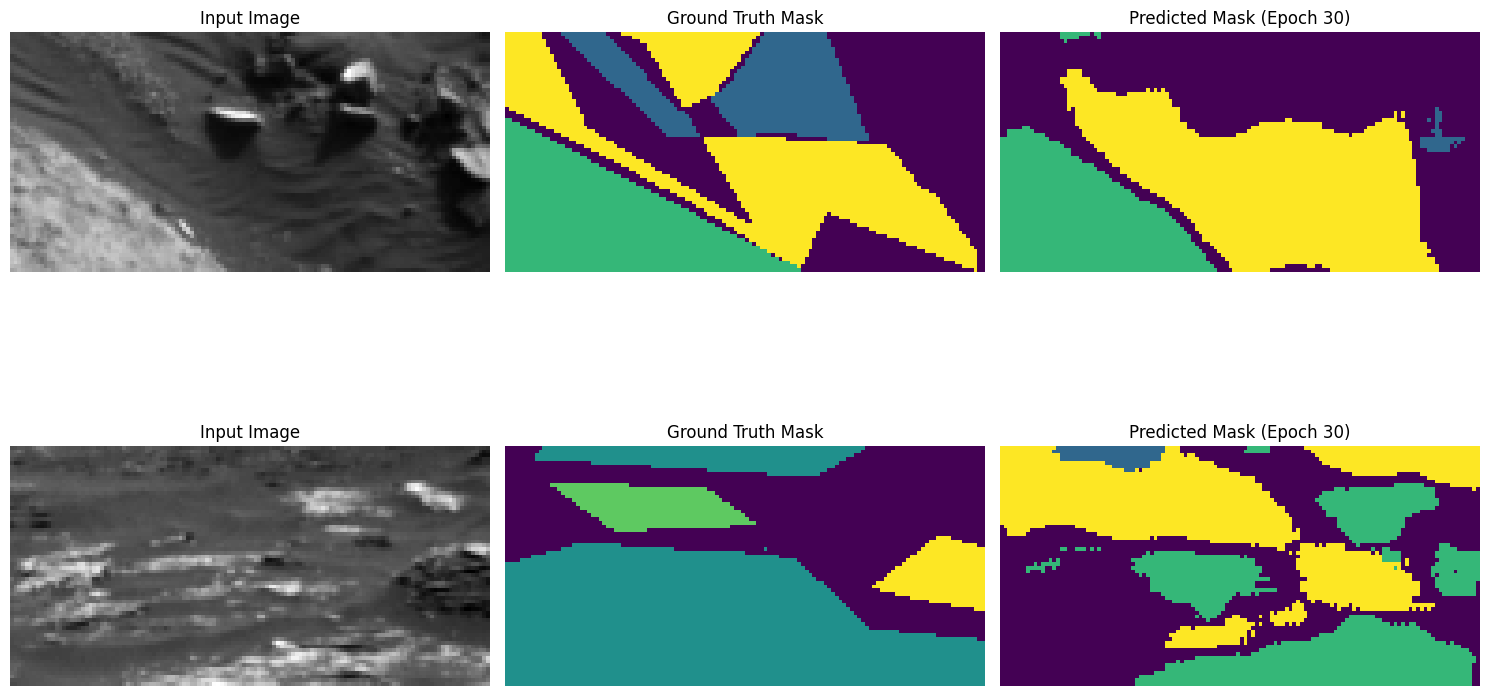

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8775 - loss: 0.3182 - mean_io_u: 0.5827 - mean_iou: 0.5827 - val_accuracy: 0.7614 - val_loss: 0.7785 - val_mean_io_u: 0.4735 - val_mean_iou: 0.4735 - learning_rate: 2.5000e-05
Epoch 31/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8817 - loss: 0.3079 - mean_io_u: 0.5867 - mean_iou: 0.5867Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 31: val_mean_iou improved to 0.4739, saving model.

Epoch 31: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


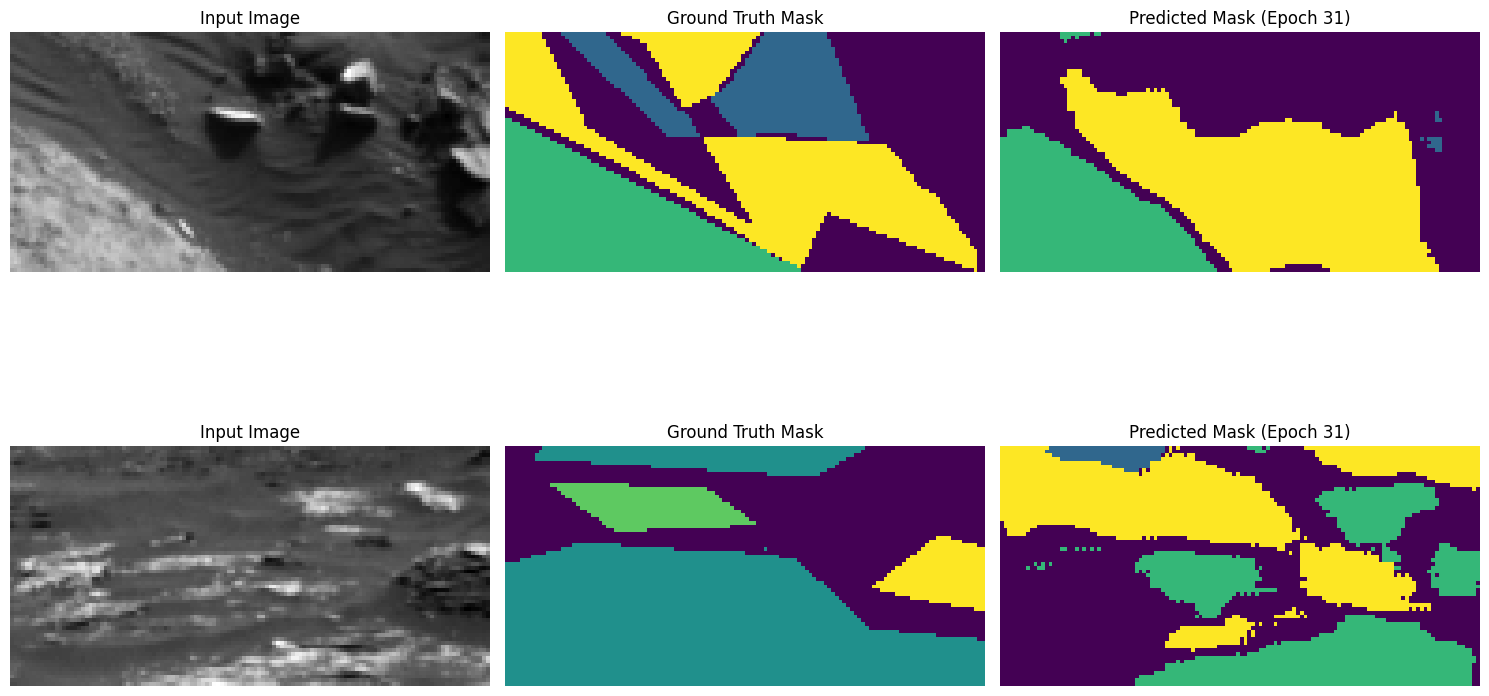

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8817 - loss: 0.3079 - mean_io_u: 0.5867 - mean_iou: 0.5867 - val_accuracy: 0.7612 - val_loss: 0.7924 - val_mean_io_u: 0.4739 - val_mean_iou: 0.4739 - learning_rate: 2.5000e-05
Epoch 32/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8857 - loss: 0.2982 - mean_io_u: 0.5905 - mean_iou: 0.5905Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 32: val_loss did not improve from 0.66986

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


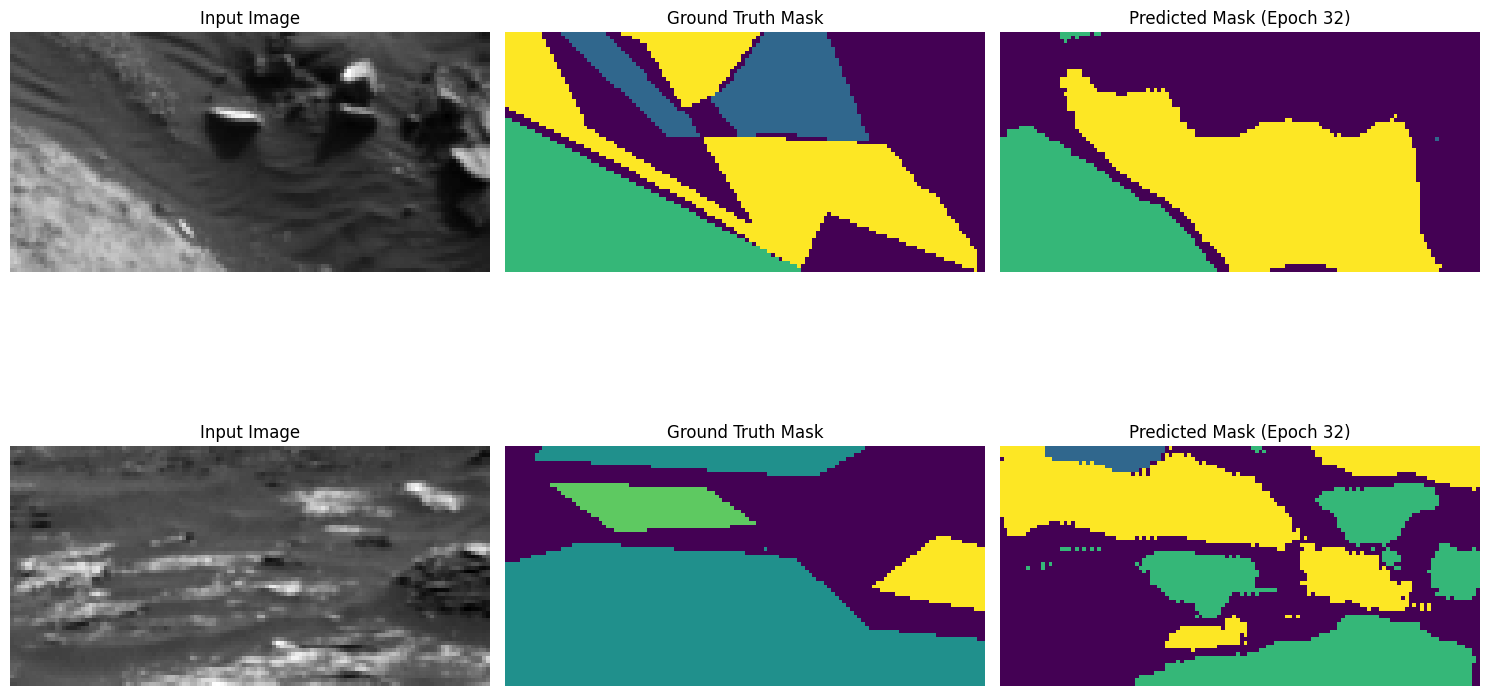

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.8857 - loss: 0.2982 - mean_io_u: 0.5905 - mean_iou: 0.5905 - val_accuracy: 0.7606 - val_loss: 0.8079 - val_mean_io_u: 0.4736 - val_mean_iou: 0.4736 - learning_rate: 2.5000e-05
Epoch 33/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8875 - loss: 0.2931 - mean_io_u: 0.5943 - mean_iou: 0.5943Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])
Epoch 33: val_mean_iou improved to 0.4918, saving model.

Epoch 33: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


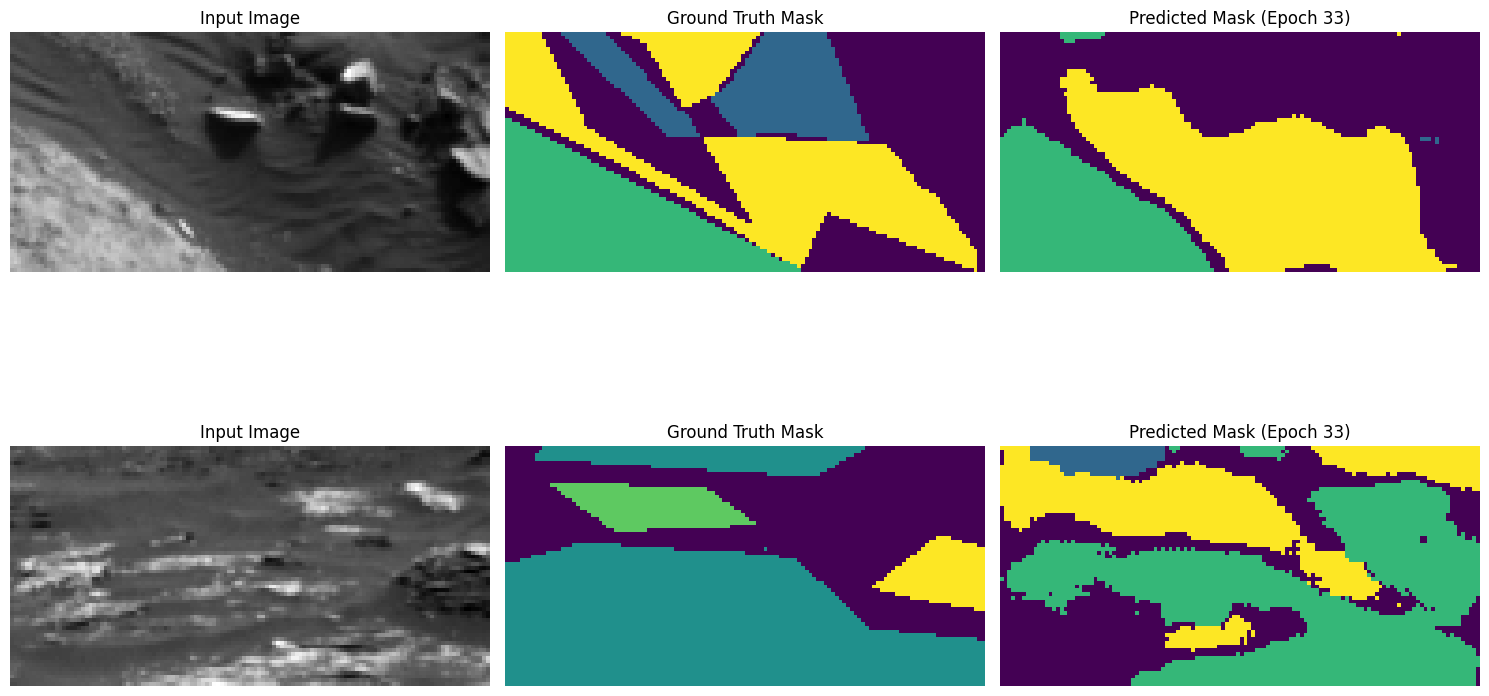

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8875 - loss: 0.2930 - mean_io_u: 0.5943 - mean_iou: 0.5943 - val_accuracy: 0.7684 - val_loss: 0.7951 - val_mean_io_u: 0.4918 - val_mean_iou: 0.4918 - learning_rate: 1.2500e-05
Epoch 34/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8910 - loss: 0.2851 - mean_io_u: 0.5967 - mean_iou: 0.5967Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 34: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


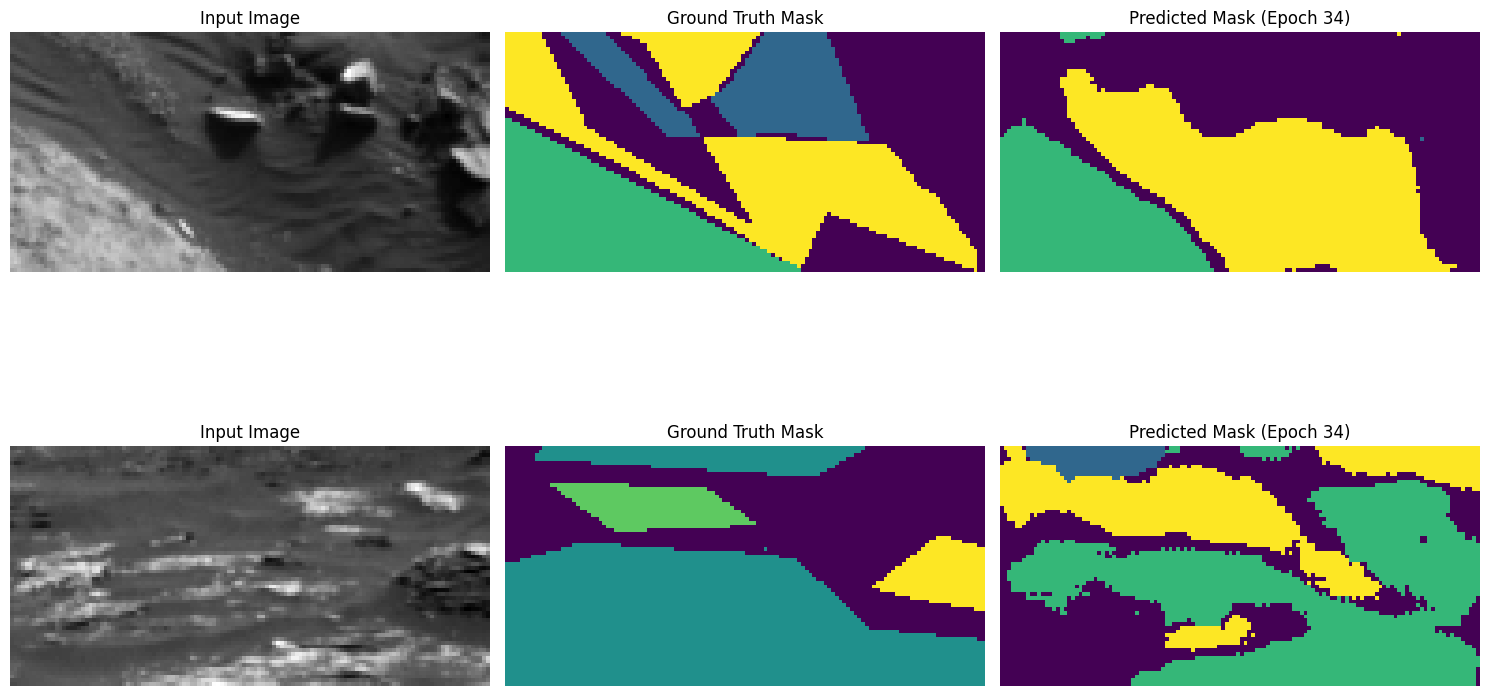

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.8910 - loss: 0.2851 - mean_io_u: 0.5967 - mean_iou: 0.5967 - val_accuracy: 0.7679 - val_loss: 0.8056 - val_mean_io_u: 0.4915 - val_mean_iou: 0.4915 - learning_rate: 1.2500e-05
Epoch 35/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8939 - loss: 0.2781 - mean_io_u: 0.5994 - mean_iou: 0.5994Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 35: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


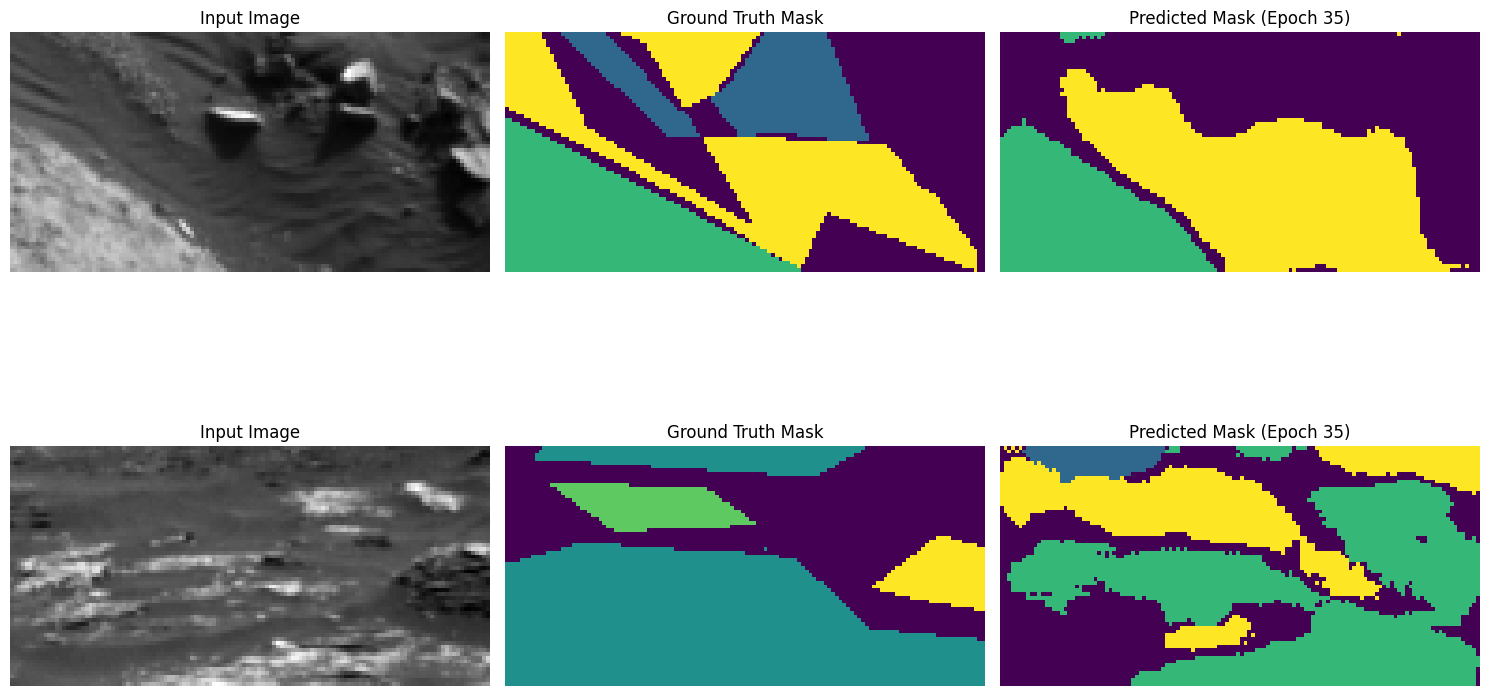

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.8939 - loss: 0.2781 - mean_io_u: 0.5994 - mean_iou: 0.5994 - val_accuracy: 0.7674 - val_loss: 0.8164 - val_mean_io_u: 0.4912 - val_mean_iou: 0.4912 - learning_rate: 1.2500e-05
Epoch 36/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8965 - loss: 0.2719 - mean_io_u: 0.6018 - mean_iou: 0.6018Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 36: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


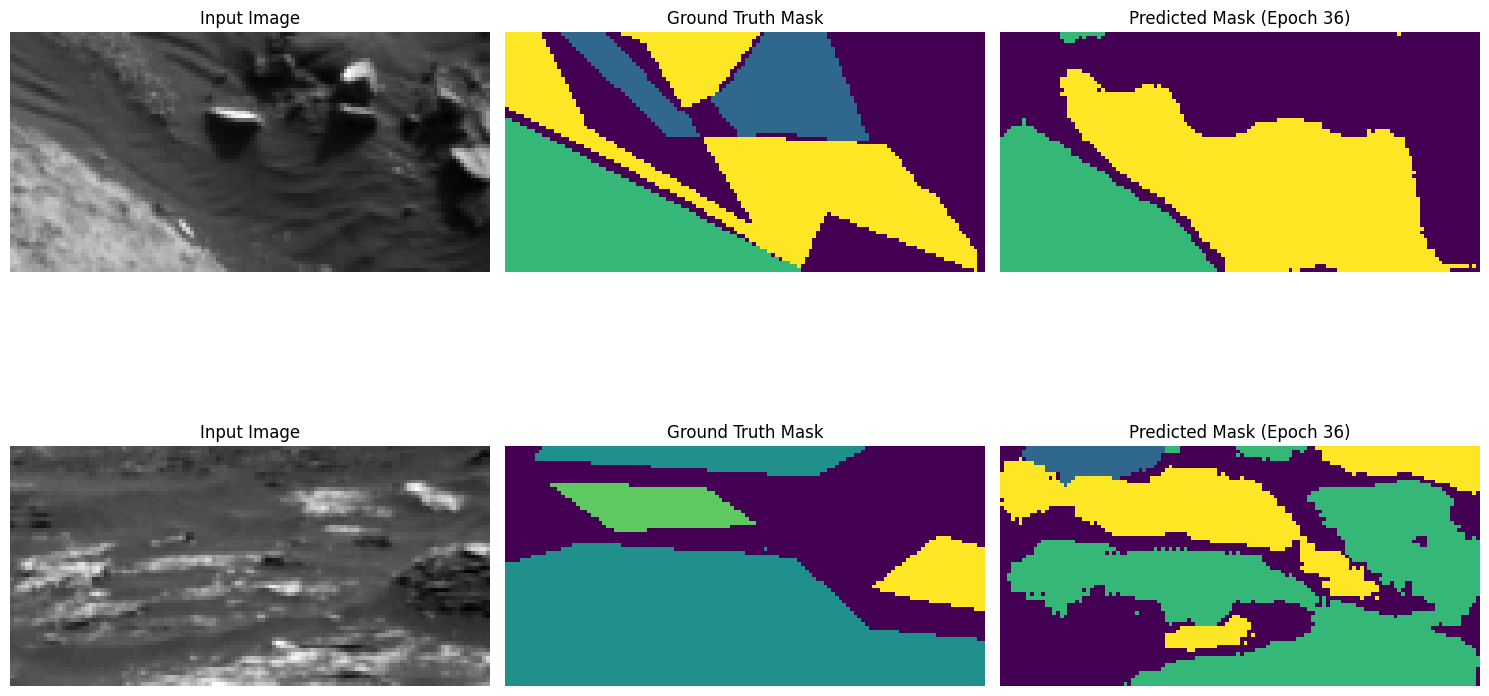

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.8965 - loss: 0.2719 - mean_io_u: 0.6018 - mean_iou: 0.6018 - val_accuracy: 0.7669 - val_loss: 0.8269 - val_mean_io_u: 0.4909 - val_mean_iou: 0.4909 - learning_rate: 1.2500e-05
Epoch 37/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8989 - loss: 0.2661 - mean_io_u: 0.6039 - mean_iou: 0.6039Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 37: val_loss did not improve from 0.66986

Epoch 37: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


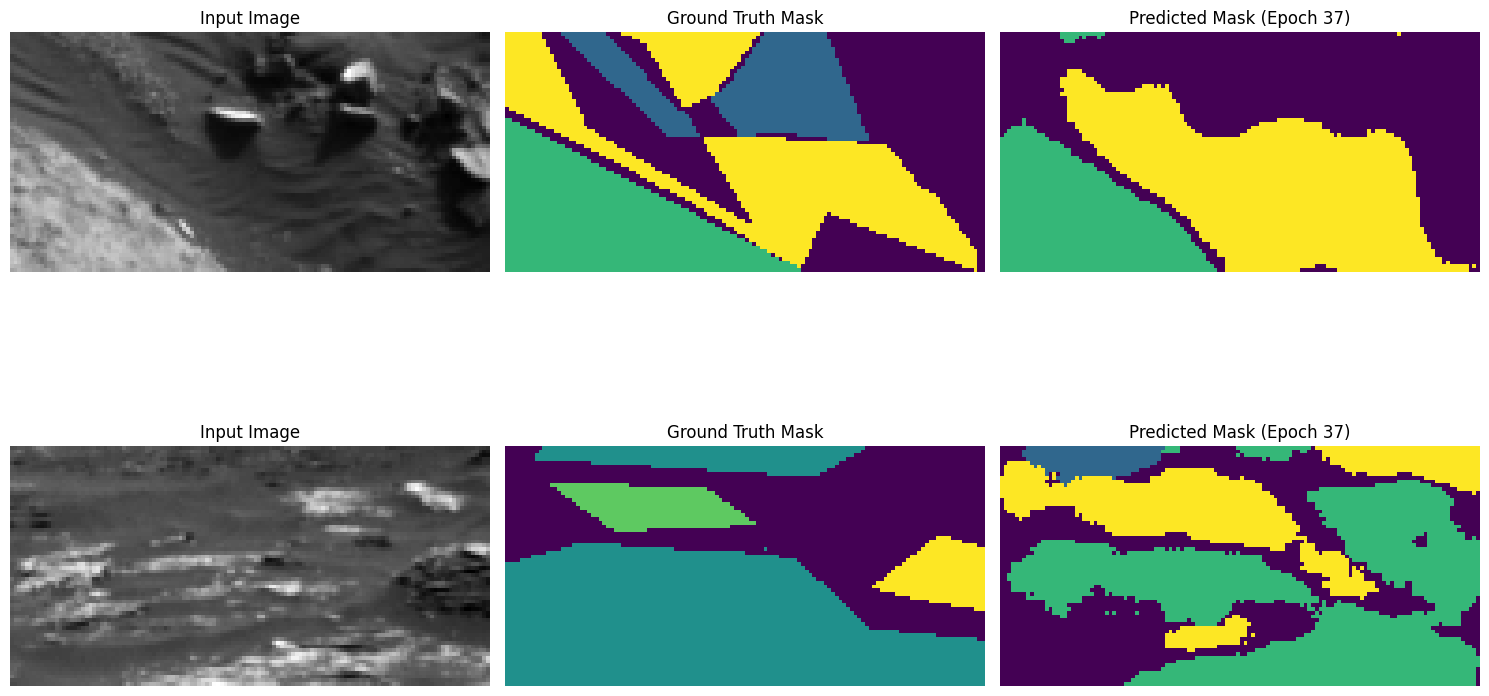

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.8989 - loss: 0.2660 - mean_io_u: 0.6039 - mean_iou: 0.6039 - val_accuracy: 0.7664 - val_loss: 0.8379 - val_mean_io_u: 0.4906 - val_mean_iou: 0.4906 - learning_rate: 1.2500e-05
Epoch 38/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9012 - loss: 0.2601 - mean_io_u: 0.6066 - mean_iou: 0.6066Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 38: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


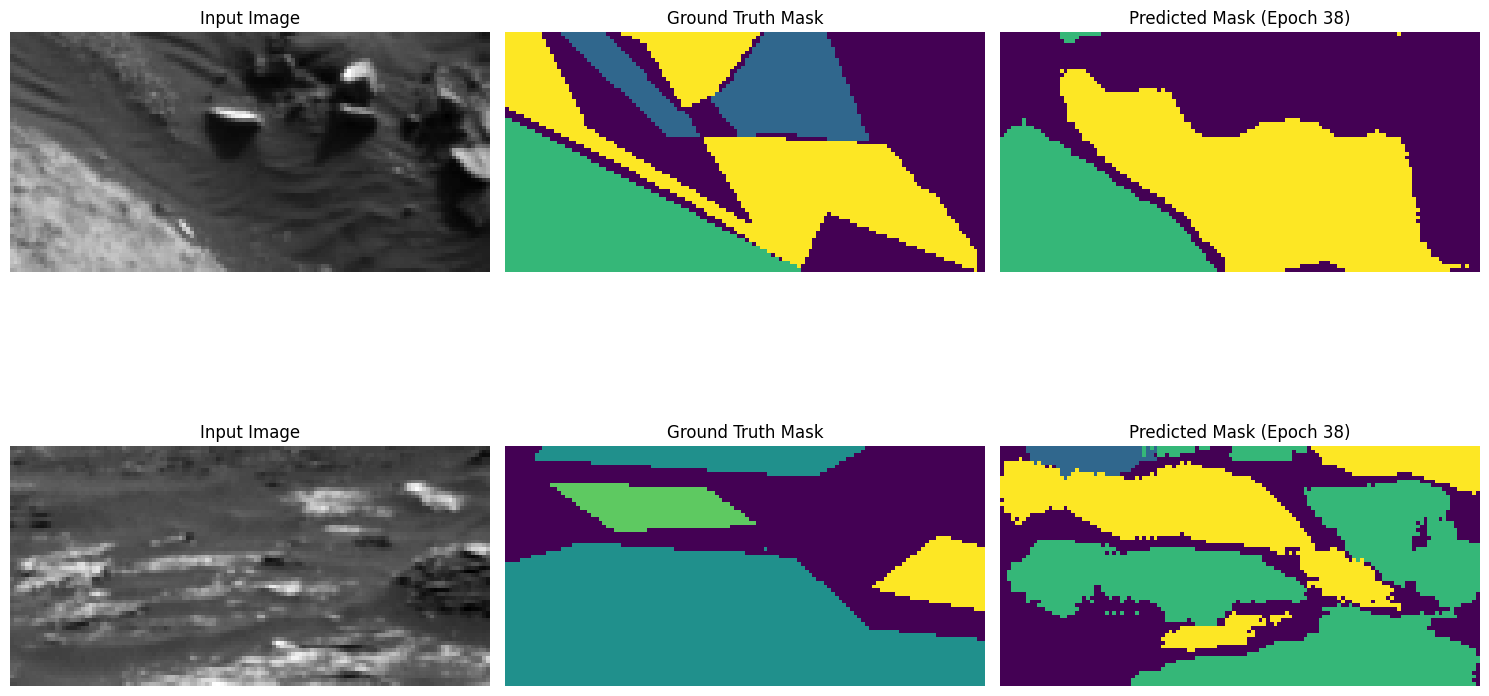

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9012 - loss: 0.2601 - mean_io_u: 0.6066 - mean_iou: 0.6066 - val_accuracy: 0.7620 - val_loss: 0.8320 - val_mean_io_u: 0.4858 - val_mean_iou: 0.4858 - learning_rate: 6.2500e-06
Epoch 39/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9032 - loss: 0.2556 - mean_io_u: 0.6081 - mean_iou: 0.6081Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 39: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


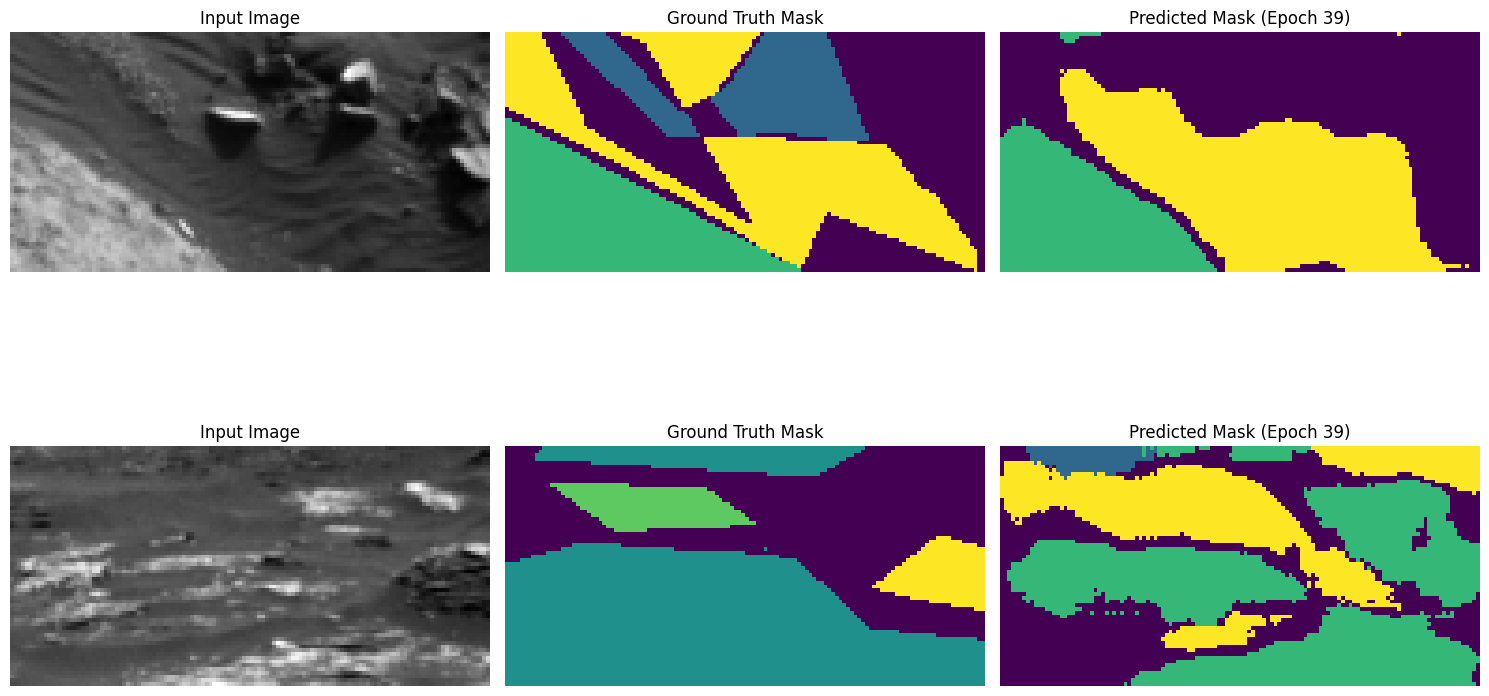

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9032 - loss: 0.2556 - mean_io_u: 0.6081 - mean_iou: 0.6081 - val_accuracy: 0.7616 - val_loss: 0.8407 - val_mean_io_u: 0.4854 - val_mean_iou: 0.4854 - learning_rate: 6.2500e-06
Epoch 40/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9048 - loss: 0.2518 - mean_io_u: 0.6096 - mean_iou: 0.6096Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 40: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


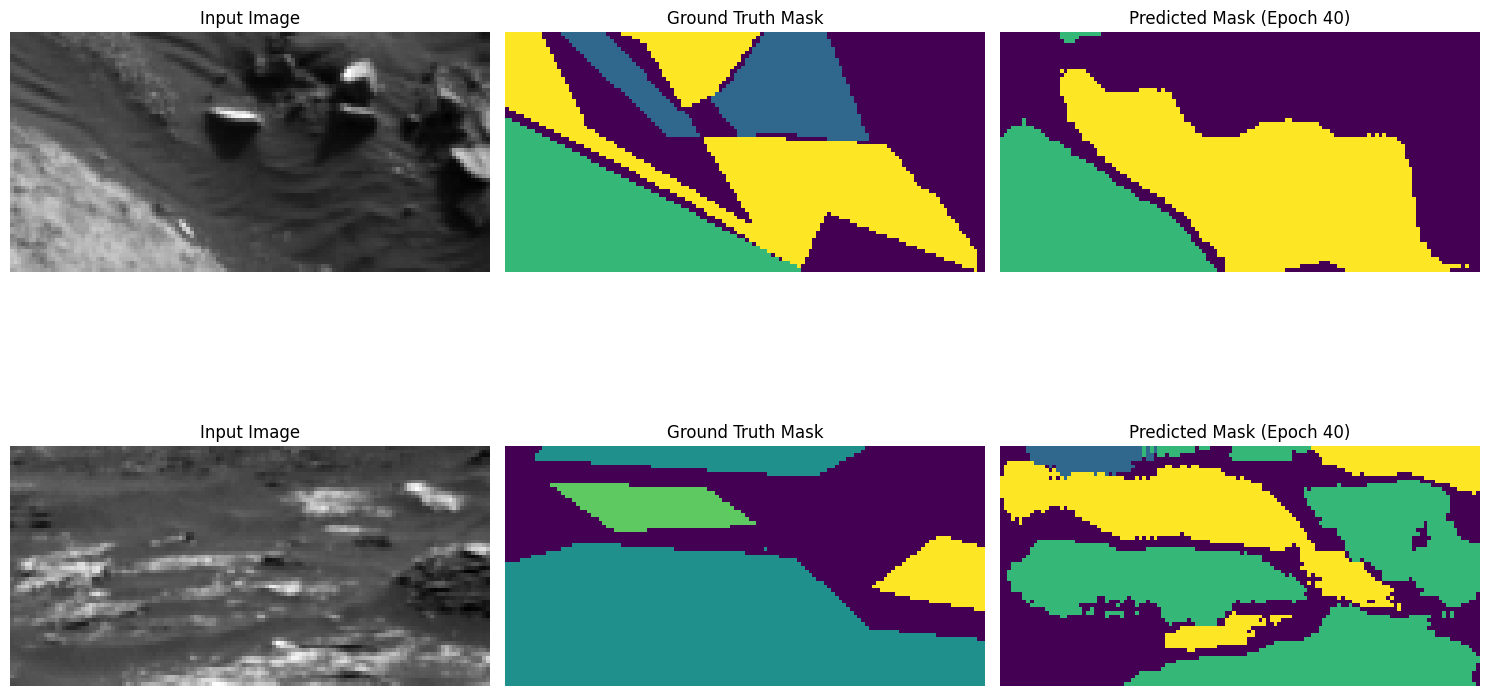

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9048 - loss: 0.2518 - mean_io_u: 0.6095 - mean_iou: 0.6095 - val_accuracy: 0.7613 - val_loss: 0.8488 - val_mean_io_u: 0.4848 - val_mean_iou: 0.4848 - learning_rate: 6.2500e-06
Epoch 41/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9062 - loss: 0.2484 - mean_io_u: 0.6108 - mean_iou: 0.6108Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 41: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


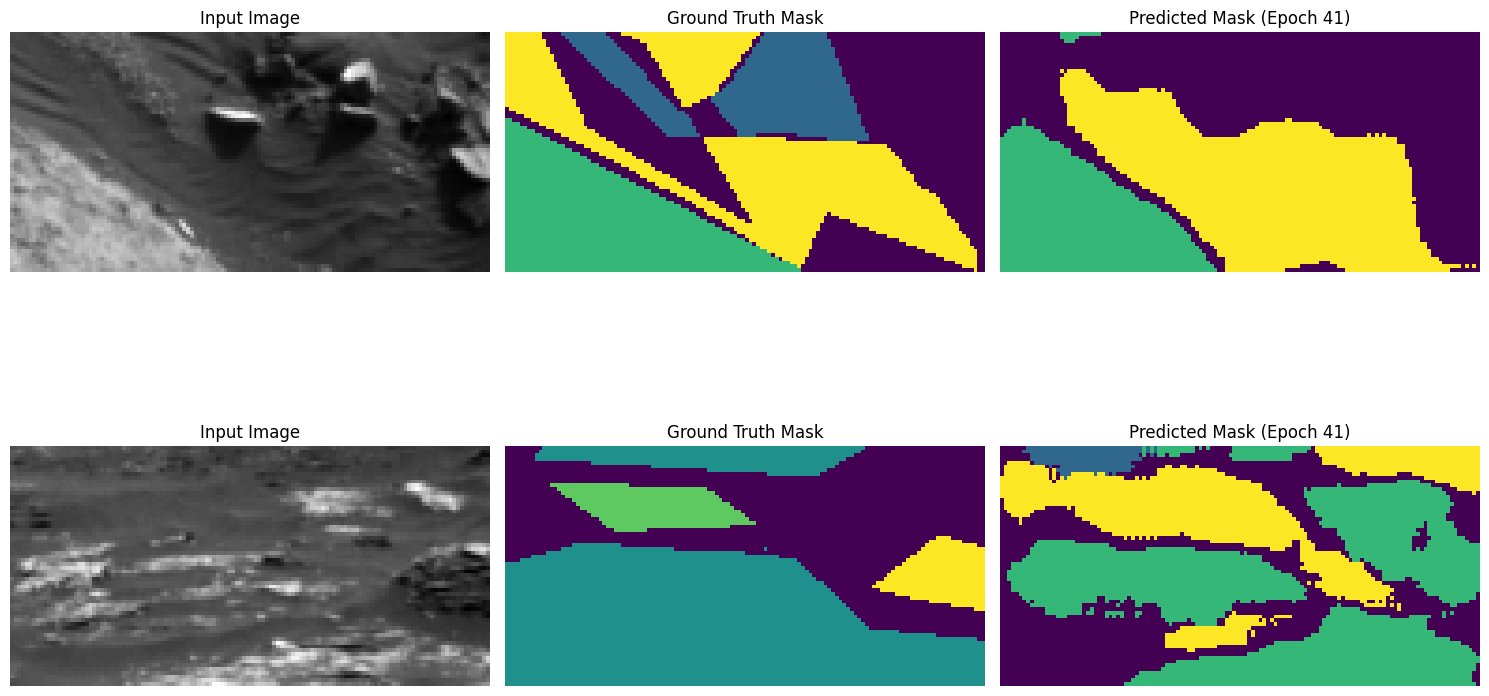

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.9062 - loss: 0.2484 - mean_io_u: 0.6108 - mean_iou: 0.6108 - val_accuracy: 0.7609 - val_loss: 0.8566 - val_mean_io_u: 0.4844 - val_mean_iou: 0.4844 - learning_rate: 6.2500e-06
Epoch 42/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9075 - loss: 0.2452 - mean_io_u: 0.6121 - mean_iou: 0.6121Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 42: val_loss did not improve from 0.66986

Epoch 42: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


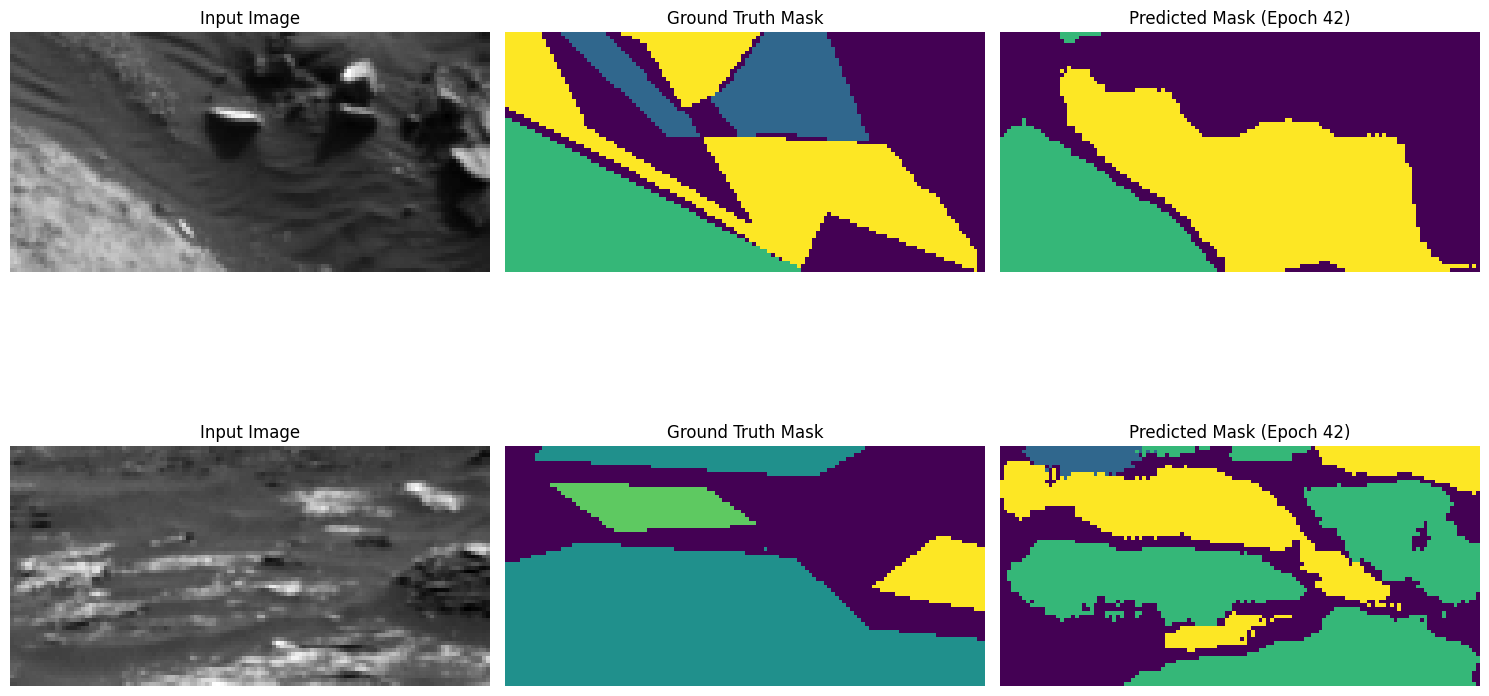

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.9075 - loss: 0.2452 - mean_io_u: 0.6120 - mean_iou: 0.6120 - val_accuracy: 0.7606 - val_loss: 0.8642 - val_mean_io_u: 0.4838 - val_mean_iou: 0.4838 - learning_rate: 6.2500e-06
Epoch 43/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9088 - loss: 0.2417 - mean_io_u: 0.6141 - mean_iou: 0.6141Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 43: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


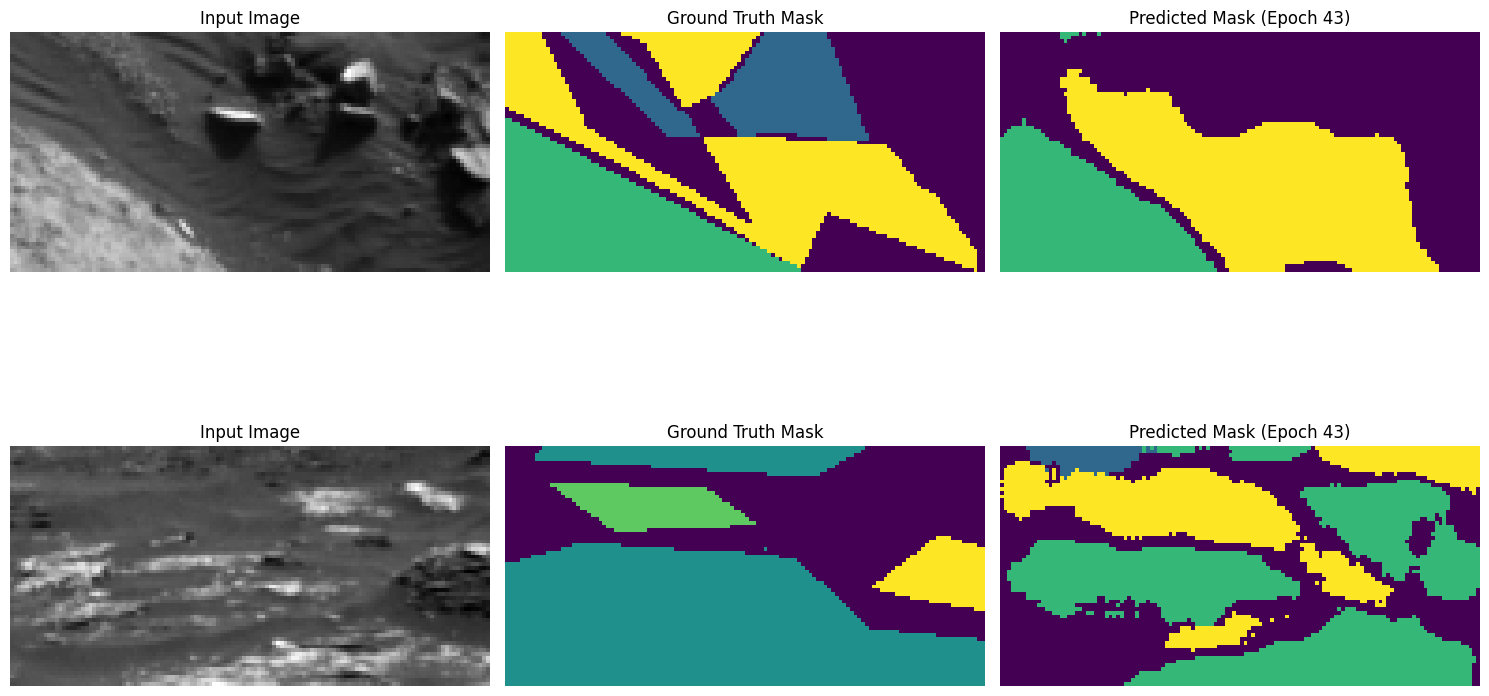

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.9088 - loss: 0.2416 - mean_io_u: 0.6141 - mean_iou: 0.6141 - val_accuracy: 0.7588 - val_loss: 0.8762 - val_mean_io_u: 0.4781 - val_mean_iou: 0.4781 - learning_rate: 3.1250e-06
Epoch 44/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9102 - loss: 0.2382 - mean_io_u: 0.6140 - mean_iou: 0.6140Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 44: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


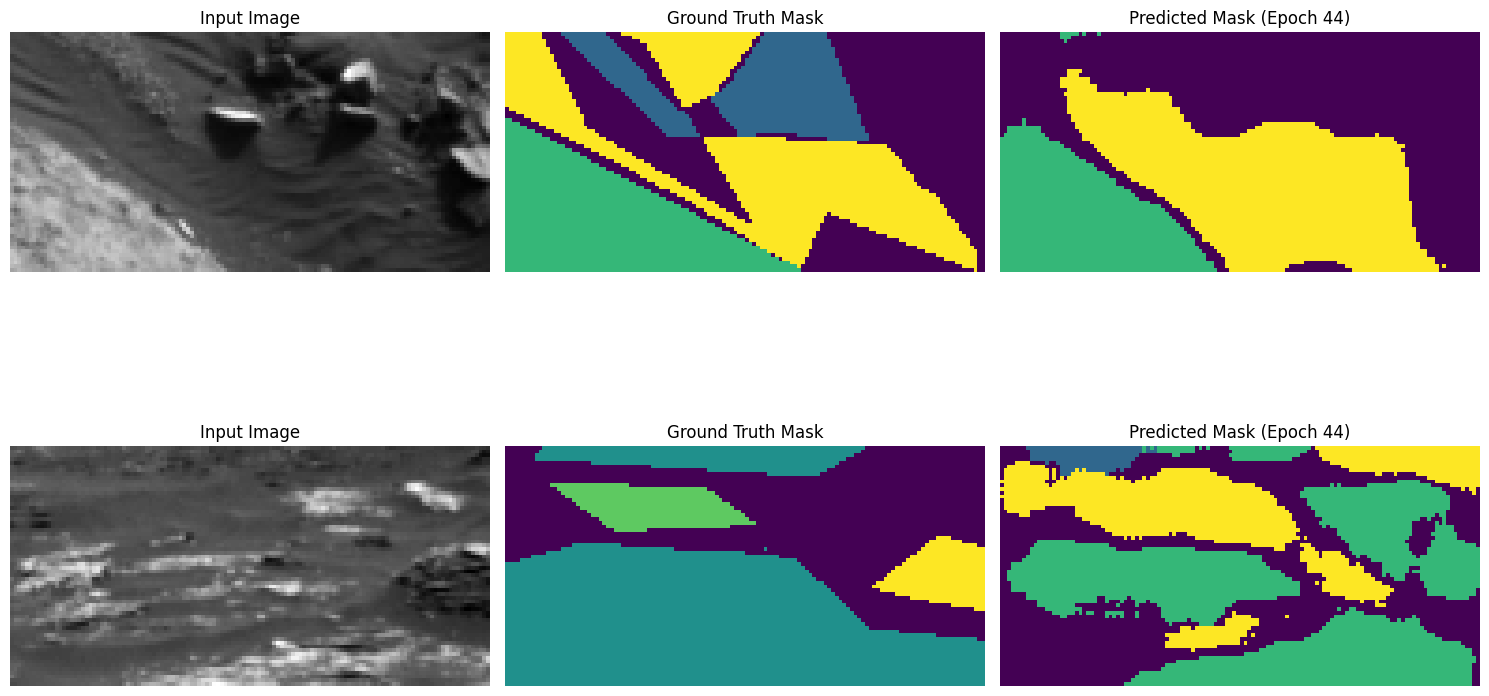

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.9102 - loss: 0.2382 - mean_io_u: 0.6140 - mean_iou: 0.6140 - val_accuracy: 0.7587 - val_loss: 0.8805 - val_mean_io_u: 0.4778 - val_mean_iou: 0.4778 - learning_rate: 3.1250e-06
Epoch 45/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9110 - loss: 0.2363 - mean_io_u: 0.6147 - mean_iou: 0.6147Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 45: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


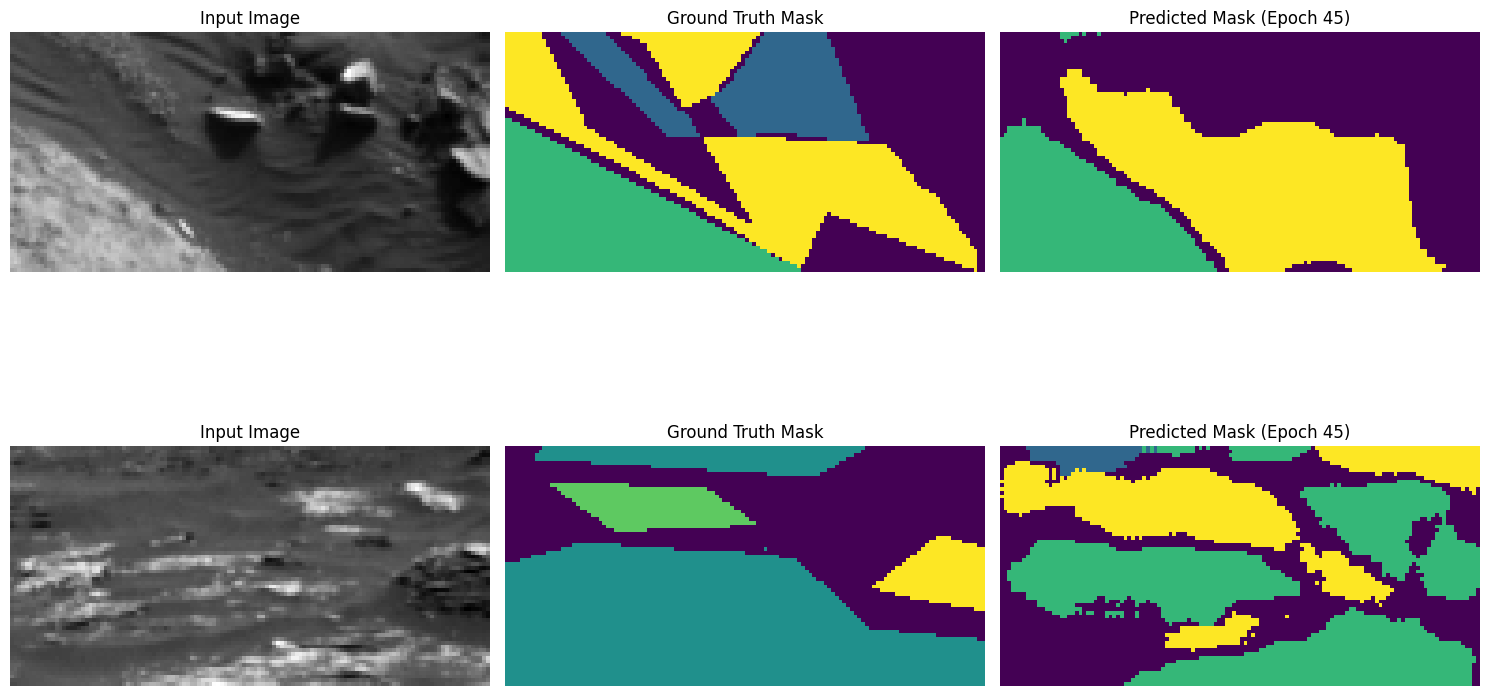

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.9110 - loss: 0.2363 - mean_io_u: 0.6147 - mean_iou: 0.6147 - val_accuracy: 0.7585 - val_loss: 0.8848 - val_mean_io_u: 0.4774 - val_mean_iou: 0.4774 - learning_rate: 3.1250e-06
Epoch 46/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9117 - loss: 0.2346 - mean_io_u: 0.6153 - mean_iou: 0.6153Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 46: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


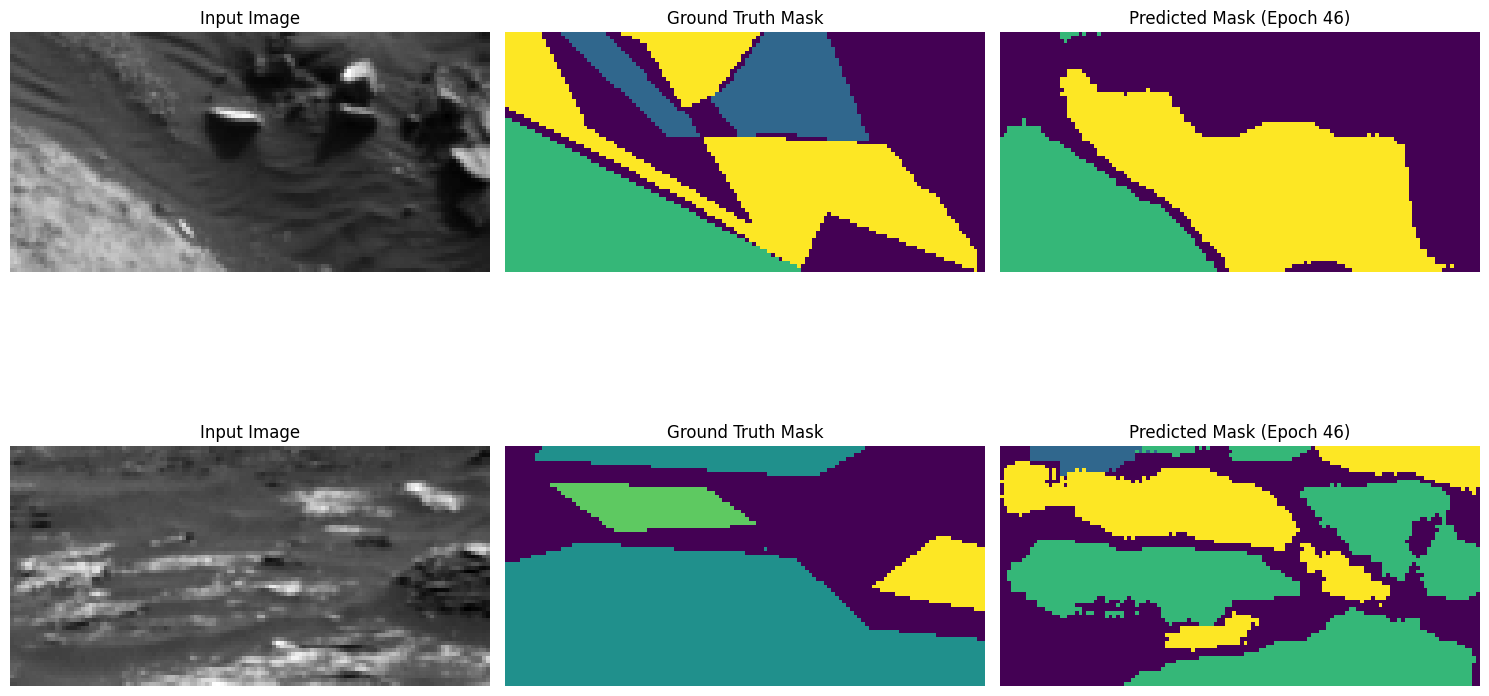

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9117 - loss: 0.2346 - mean_io_u: 0.6153 - mean_iou: 0.6153 - val_accuracy: 0.7584 - val_loss: 0.8891 - val_mean_io_u: 0.4772 - val_mean_iou: 0.4772 - learning_rate: 3.1250e-06
Epoch 47/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9123 - loss: 0.2330 - mean_io_u: 0.6159 - mean_iou: 0.6159Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 47: val_loss did not improve from 0.66986

Epoch 47: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


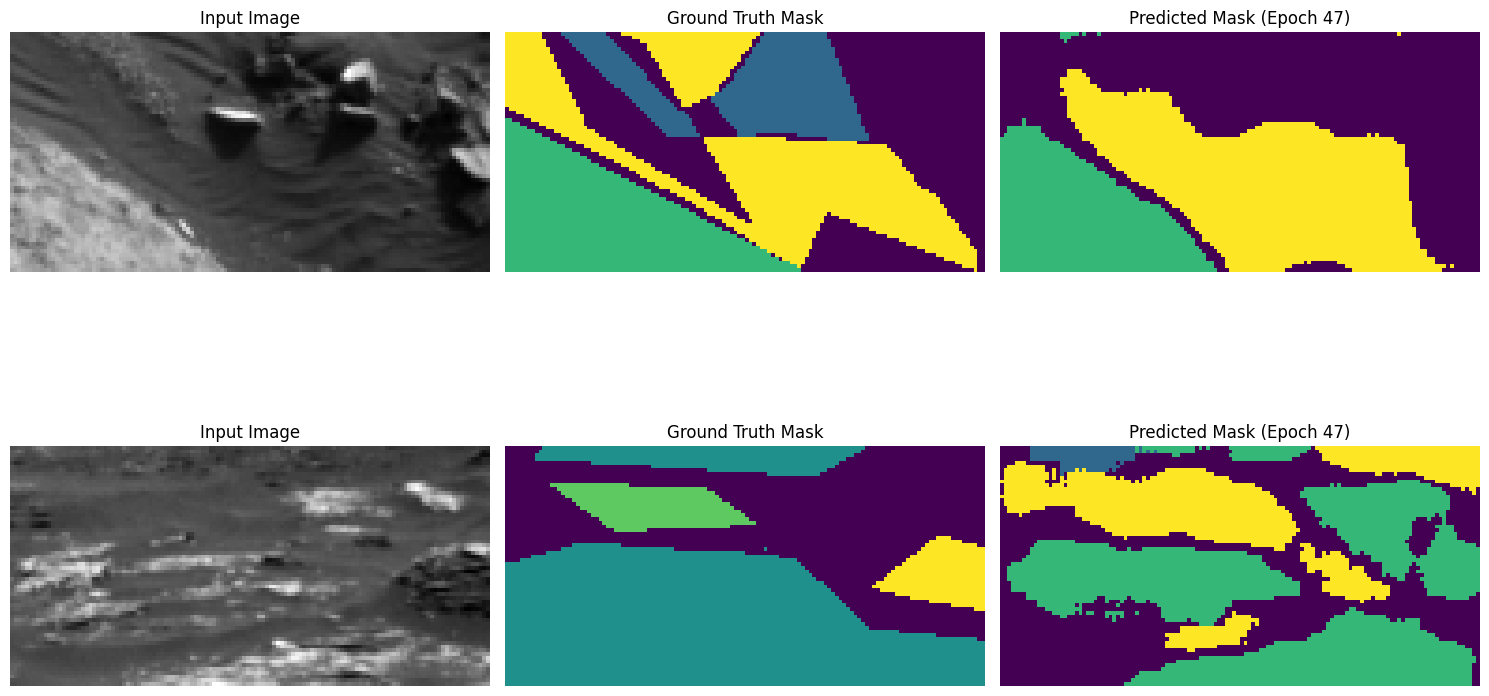

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9123 - loss: 0.2330 - mean_io_u: 0.6159 - mean_iou: 0.6159 - val_accuracy: 0.7582 - val_loss: 0.8935 - val_mean_io_u: 0.4768 - val_mean_iou: 0.4768 - learning_rate: 3.1250e-06
Epoch 48/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9129 - loss: 0.2313 - mean_io_u: 0.6163 - mean_iou: 0.6163Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 48: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


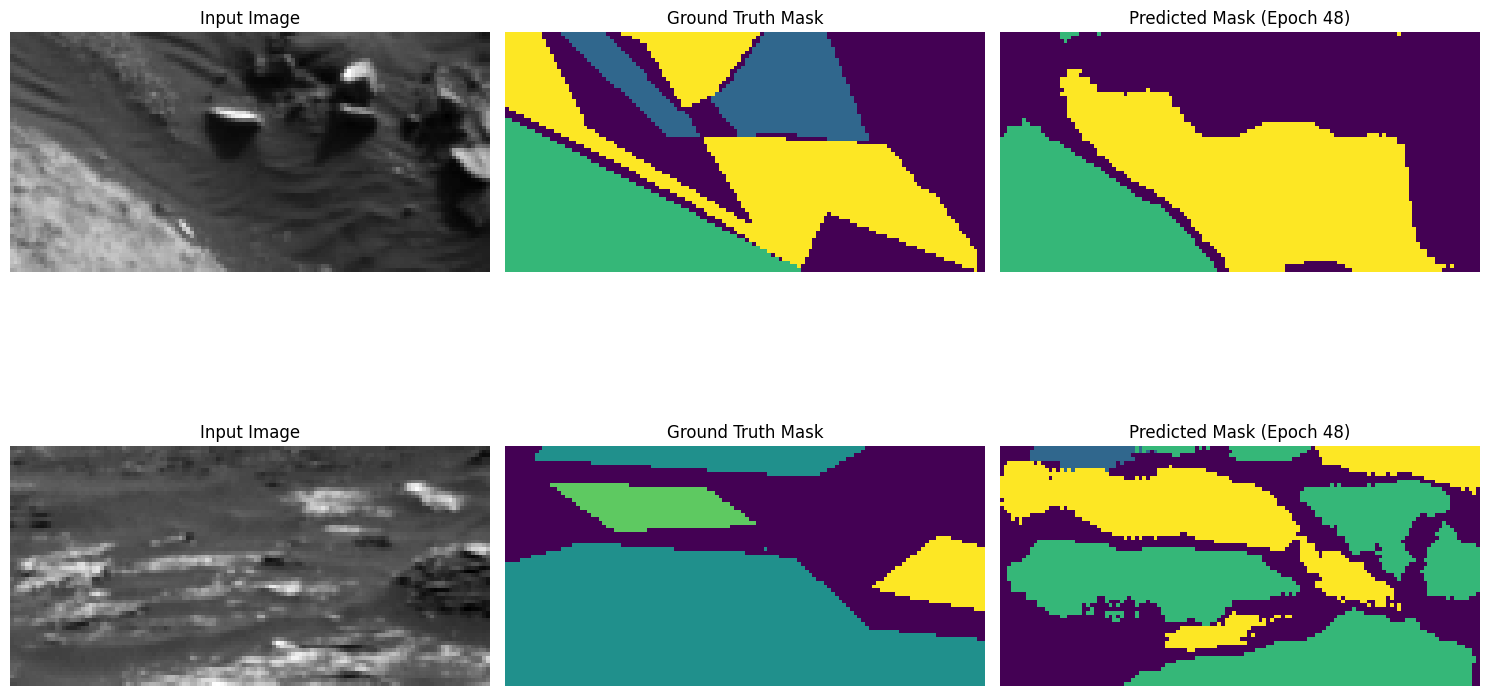

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.9129 - loss: 0.2312 - mean_io_u: 0.6163 - mean_iou: 0.6163 - val_accuracy: 0.7589 - val_loss: 0.8982 - val_mean_io_u: 0.4765 - val_mean_iou: 0.4765 - learning_rate: 1.5625e-06
Epoch 49/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9135 - loss: 0.2298 - mean_io_u: 0.6165 - mean_iou: 0.6165Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 49: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


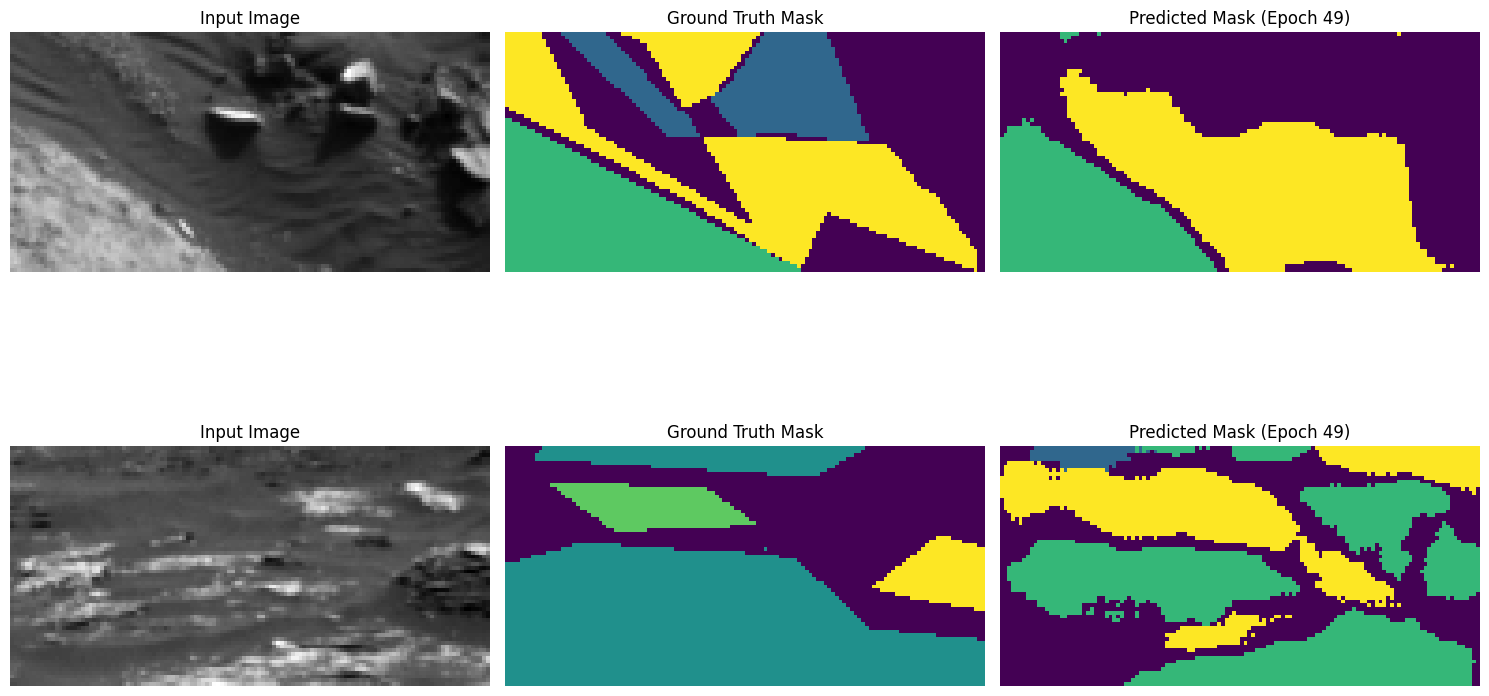

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9135 - loss: 0.2298 - mean_io_u: 0.6165 - mean_iou: 0.6165 - val_accuracy: 0.7588 - val_loss: 0.9002 - val_mean_io_u: 0.4764 - val_mean_iou: 0.4764 - learning_rate: 1.5625e-06
Epoch 50/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9139 - loss: 0.2289 - mean_io_u: 0.6168 - mean_iou: 0.6168Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 50: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


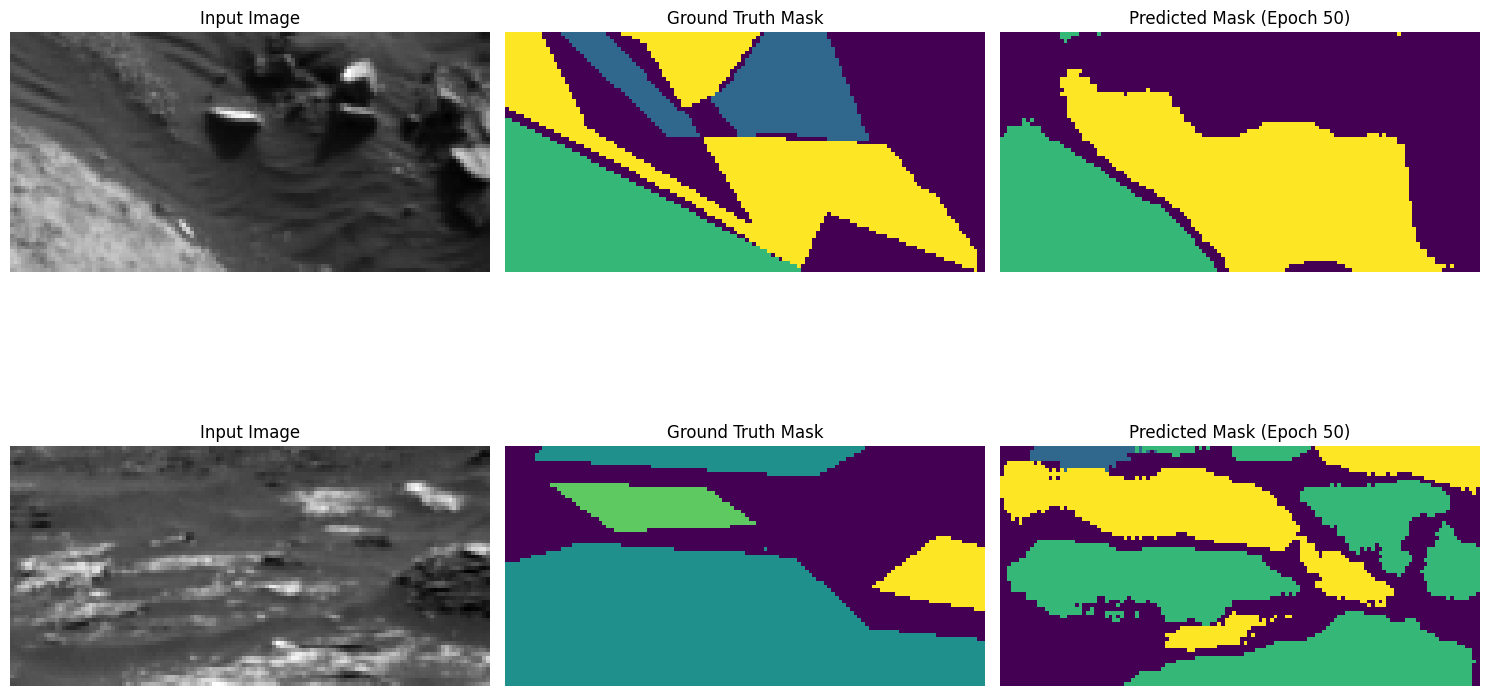

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.9139 - loss: 0.2289 - mean_io_u: 0.6168 - mean_iou: 0.6168 - val_accuracy: 0.7588 - val_loss: 0.9023 - val_mean_io_u: 0.4764 - val_mean_iou: 0.4764 - learning_rate: 1.5625e-06
Epoch 51/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9142 - loss: 0.2280 - mean_io_u: 0.6172 - mean_iou: 0.6172Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 51: val_loss did not improve from 0.66986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


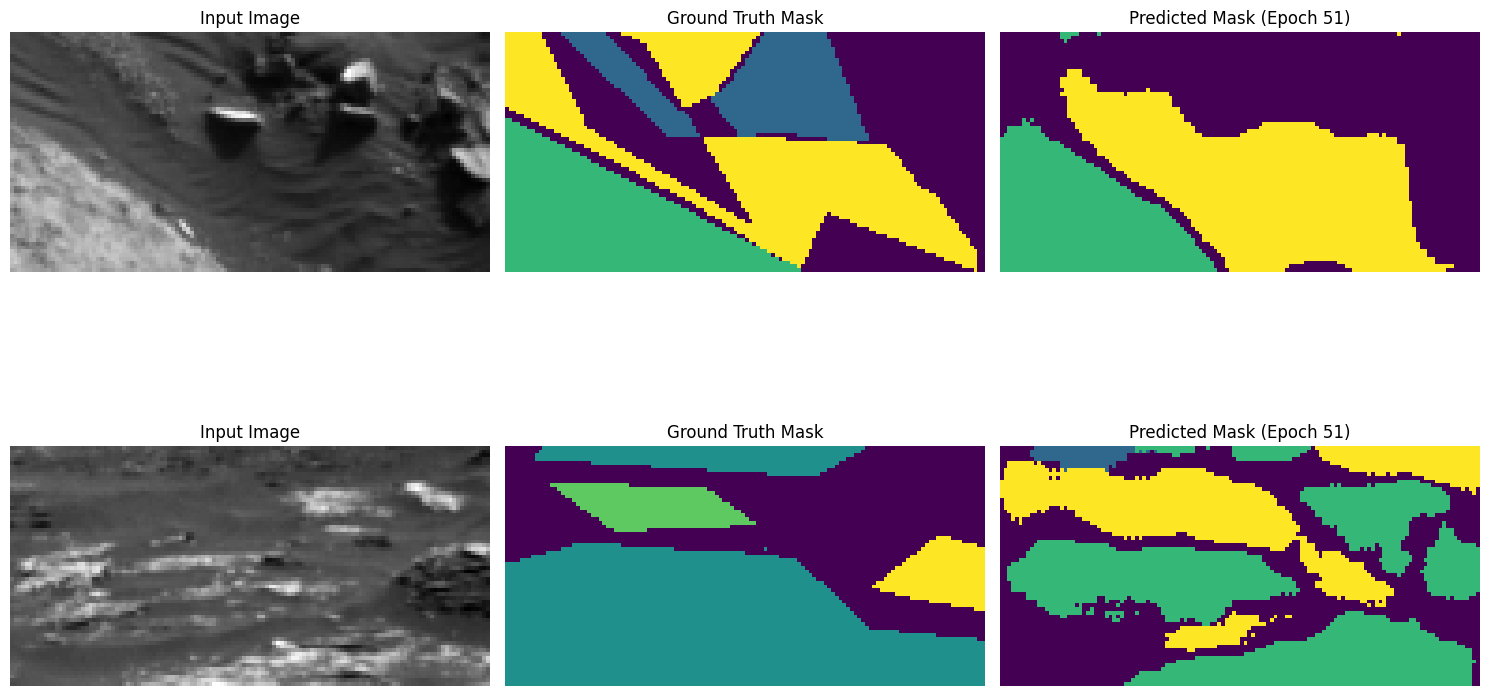

376/376 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9143 - loss: 0.2280 - mean_io_u: 0.6172 - mean_iou: 0.6172 - val_accuracy: 0.7588 - val_loss: 0.9045 - val_mean_io_u: 0.4763 - val_mean_iou: 0.4763 - learning_rate: 1.5625e-06
Epoch 52/1000
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9146 - loss: 0.2271 - mean_io_u: 0.6174 - mean_iou: 0.6174Available log keys: dict_keys(['accuracy', 'loss', 'mean_io_u', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_io_u', 'val_mean_iou'])

Epoch 52: val_loss did not improve from 0.66986

Epoch 52: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


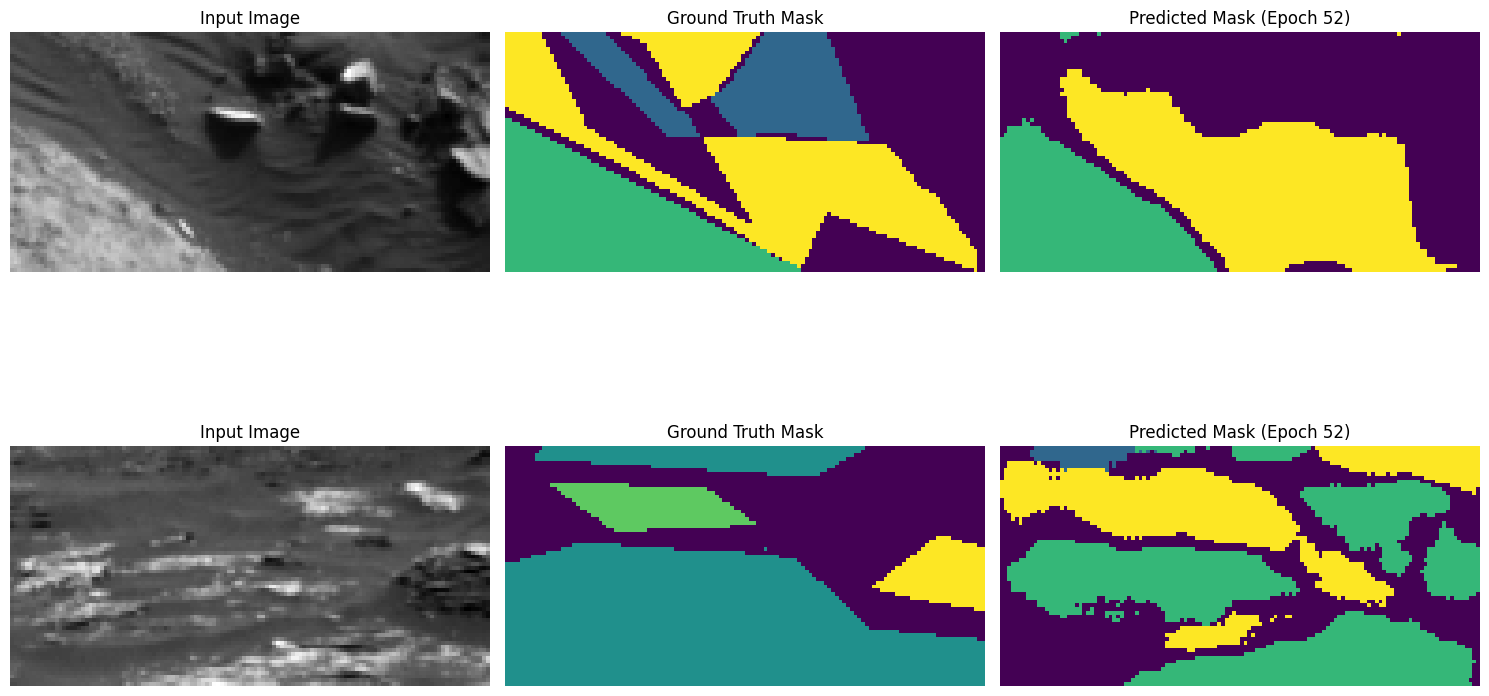

376/376 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.9146 - loss: 0.2271 - mean_io_u: 0.6174 - mean_iou: 0.6174 - val_accuracy: 0.7587 - val_loss: 0.9066 - val_mean_io_u: 0.4761 - val_mean_iou: 0.4761 - learning_rate: 1.5625e-06


In [23]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
num_classes = 5  # Replace with your number of classes
ignore_class = 0  # Class to ignore

#custom_mean_iou = CustomMeanIoU(num_classes=num_classes, ignore_class=0)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
# Compile the model
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy", mean_iou, MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])])

model.summary()
# Define callbacks
save_best_miou = SaveBestMeanIoU(filepath="best_model_mean_iou.h5", monitor="val_mean_iou", mode="max", verbose=1)


# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    #batch_size=32,
    epochs=1000,
    callbacks=[save_best_miou, early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


In [24]:
# Load the saved model
best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})



In [25]:
model=best_model

In [35]:
model_filename = f"model_augmented_hvr_best_invert_noise.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_augmented_hvr_best_invert_noise.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [36]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [37]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [38]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


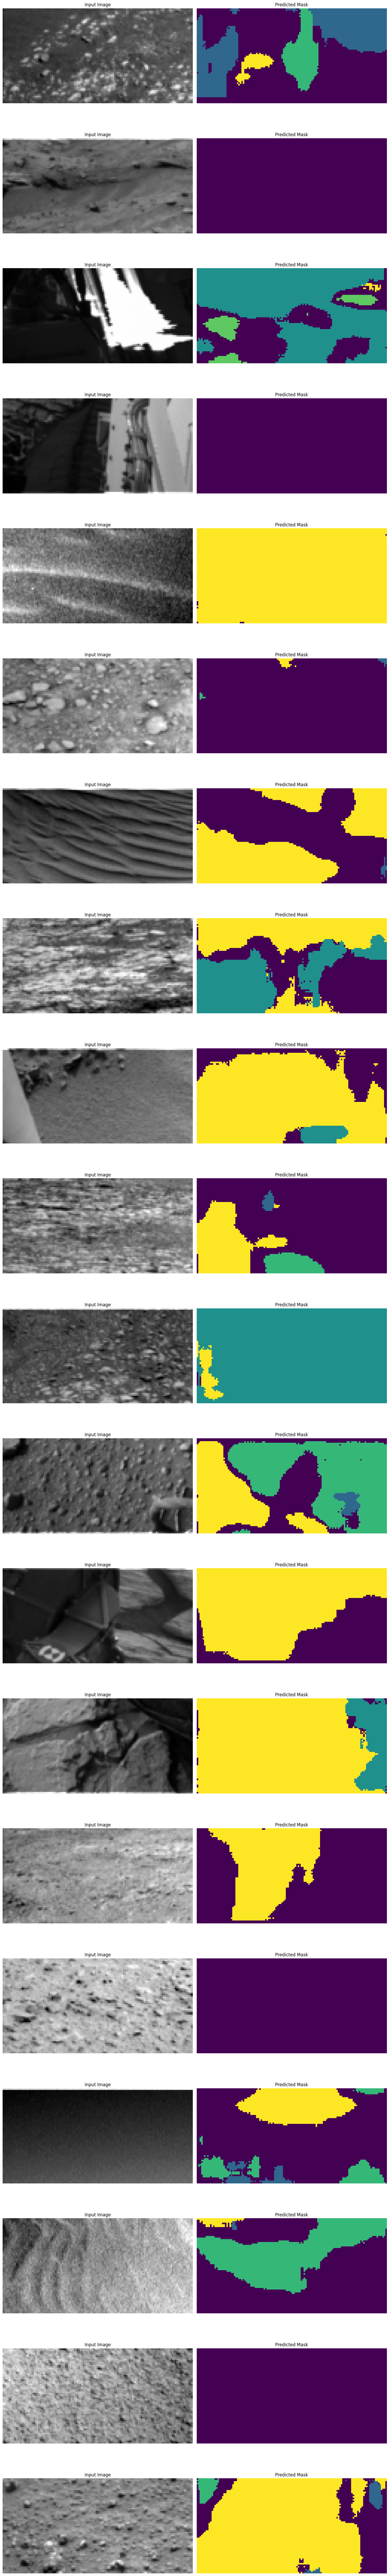

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [40]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [41]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [42]:
len(submission_df.columns)

8193

In [34]:
len(submission_df)

10022